<a href="https://colab.research.google.com/github/mohamed-bouchalkha/ligue1-match-prediction-Project/blob/main/Copy_of_Prediction_Ligue1_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ⚽ **Prédiction des Résultats de Ligue 1 (Saison 2023-2024)**

*Objectif :* Construire un modèle de classification pour prédire les résultats des matchs de Ligue 1 (victoire à domicile, nul, ou victoire à l'extérieur) en utilisant des données historiques et des statistiques sur les joueurs et les clubs. Le but est de produire des prédictions fiables pour la saison 2023-2024 à partir de données disponibles jusqu'à 2022.


# **Importation des bibliothèques python**:

In [4]:
# ====================
# Standard Library
# ====================
import os
import time
import pickle
import warnings
from datetime import datetime

# ====================
# Suppress Warnings
# ====================
warnings.filterwarnings('ignore')

# ====================
# Google Colab
# ====================
from google.colab import drive

# ====================
# Data Manipulation
# ====================
import numpy as np
import pandas as pd
from scipy import stats

# ====================
# Visualization
# ====================
import matplotlib.pyplot as plt
import seaborn as sns

# ====================
# Machine Learning - scikit-learn
# ====================
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    matthews_corrcoef,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    auc
)
from sklearn.model_selection import (
    KFold,
    RandomizedSearchCV,
    cross_val_score,
    train_test_split
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OrdinalEncoder,
    StandardScaler,
    LabelEncoder
)

# ====================
# Statistical Modeling - statsmodels
# ====================
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ====================
# Deep Learning - TensorFlow / Keras
# ====================
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical


In [5]:
drive.mount('/content/drive')
base_path = '/content/drive/MyDrive/ColabDatasets/Ligue1_Prediction/'
# Lire les datasets
df_match_hist = pd.read_csv(base_path + "matchs_2013_2022.csv")
df_match_2023 = pd.read_csv(base_path + "match_2023.csv")
df_clubs = pd.read_csv(base_path + "clubs_fr.csv")
df_valuations = pd.read_csv(base_path + "player_valuation_before_season.csv")
df_appearance = pd.read_csv(base_path + "player_appearance.csv")
df_lineups = pd.read_csv(base_path + "game_lineups.csv")
df_events = pd.read_csv(base_path + "game_events.csv")
df_sample = pd.read_csv(base_path + "sample_results.csv")
df_prediction_ex = pd.read_csv(base_path + "prediction_example.csv")
print ("****Les donnees charger avec succès****")

Mounted at /content/drive
****Les donnees charger avec succès****


In [ ]:
# Afficher les informations sur chaque DataFrame
print("📘 df_match_hist")
df_match_hist.info()
print("\n📘 df_match_2023")
df_match_2023.info()
print("\n📘 df_clubs")
df_clubs.info()
print("\n📘 df_valuations")
df_valuations.info()
print("\n📘 df_appearance")
df_appearance.info()
print("\n📘 df_lineups")
df_lineups.info()
print("\n📘 df_events")
df_events.info()
print("\n📘 df_sample")
df_sample.info()
print("\n📘 df_prediction_ex")
df_prediction_ex.info()


📘 df_match_hist
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4078 entries, 0 to 4077
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              4078 non-null   int64  
 1   game_id                 4078 non-null   int64  
 2   season                  4078 non-null   int64  
 3   round                   4078 non-null   object 
 4   date                    4078 non-null   object 
 5   home_club_id            4078 non-null   int64  
 6   away_club_id            4078 non-null   int64  
 7   home_club_goals         4078 non-null   int64  
 8   away_club_goals         4078 non-null   int64  
 9   home_club_position      4078 non-null   float64
 10  away_club_position      4078 non-null   float64
 11  home_club_manager_name  4078 non-null   object 
 12  away_club_manager_name  4078 non-null   object 
 13  stadium                 4078 non-null   object 
 14  attendance              

## **I- ANALYSE EXPLORATOIRE DES DONNÉES**




1. Analyse exploratoire de `matchs_2013_2022.csv`
2. Analyse exploratoire de `match_2023.csv`
3. Analyse exploratoire de `clubs_fr.csv`
4. Analyse exploratoire de `player_valuation_before_season.csv`
5. Analyse exploratoire de `player_appearance.csv`
6. Analyse exploratoire de `game_lineups.csv`
7. Analyse exploratoire de `game_events.csv`
8. Analyse exploratoire de `sample_results.csv`
9. Analyse exploratoire de `prediction_example.csv`


# **I.1. Analyse Exploratoire de `matchs_2013_2022.csv`**

In [ ]:
print("="*80)
print("EXPLORATION DES MATCHS HISTORIQUES (2013-2022)")
print("="*80)

# 1. APERÇU DE BASE DU DATASET
print("\n1. APERÇU DES DONNÉES\n")
print("Dimensions:", df_match_hist.shape)
print("\nPremières lignes:")
print(df_match_hist.head())
print("\nTypes de données:")
print(df_match_hist.dtypes)
print("\nStatistiques descriptives:")
print(df_match_hist.describe())
print("\nValeurs manquantes:")
print(df_match_hist.isnull().sum())

# 2. ANALYSE TEMPORELLE
print("\n" + "="*80)
print("2. ANALYSE TEMPORELLE")
print("="*80)

# Convertir les dates en format datetime
df_match_hist['date'] = pd.to_datetime(df_match_hist['date'])

# Distribution des matchs par saison
season_counts = df_match_hist['season'].value_counts().sort_index()
print("\nNombre de matchs par saison:")
print(season_counts)


EXPLORATION DES MATCHS HISTORIQUES (2013-2022)

1. APERÇU DES DONNÉES

Dimensions: (4078, 23)

Premières lignes:
   Unnamed: 0  game_id  season         round        date  home_club_id  \
0          12  2330874    2013   8. Matchday  2013-09-28           618   
1          13  2330880    2013  10. Matchday  2013-10-19         14171   
2          14  2330916    2013  15. Matchday  2013-11-30          1423   
3          15  2331018    2013  21. Matchday  2014-01-18           273   
4          16  2331034    2013  24. Matchday  2014-02-08          1147   

   away_club_id  home_club_goals  away_club_goals  home_club_position  ...  \
0           595                2                2                 6.0  ...   
1           855                1                2                16.0  ...   
2          1082                0                1                18.0  ...   
3         14171                0                0                15.0  ...   
4           273                3                1   


Distribution des matchs par jour de la semaine:
day_of_week
Saturday     1767
Sunday       1530
Friday        365
Wednesday     326
Tuesday        70
Thursday       14
Monday          6
Name: count, dtype: int64


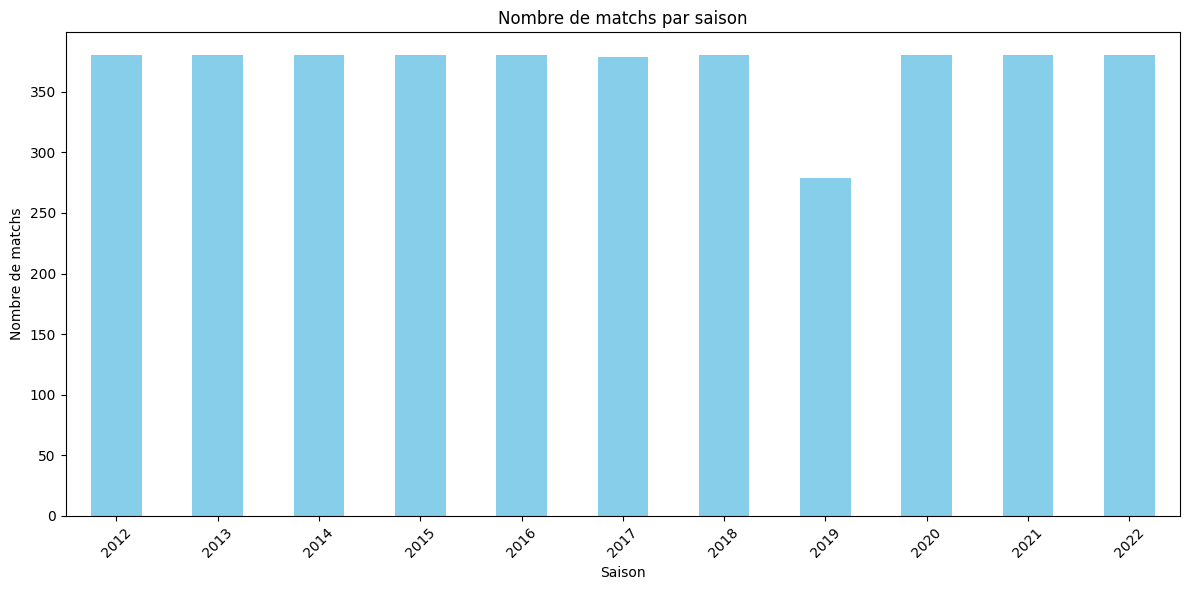

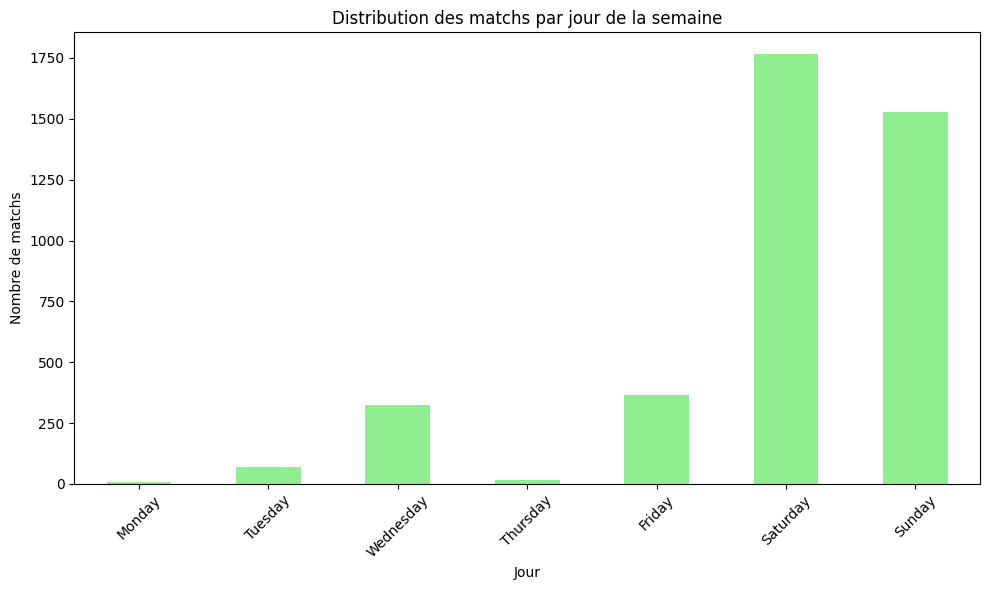

In [ ]:
plt.figure(figsize=(12, 6))
season_counts.plot(kind='bar', color='skyblue')
plt.title('Nombre de matchs par saison')
plt.xlabel('Saison')
plt.ylabel('Nombre de matchs')
plt.xticks(rotation=45)
plt.tight_layout()
# Distribution des matchs par jour de la semaine
df_match_hist['day_of_week'] = df_match_hist['date'].dt.day_name()
day_counts = df_match_hist['day_of_week'].value_counts()
print("\nDistribution des matchs par jour de la semaine:")
print(day_counts)



plt.figure(figsize=(10, 6))
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts = day_counts.reindex(day_order)
day_counts.plot(kind='bar', color='lightgreen')
plt.title('Distribution des matchs par jour de la semaine')
plt.xlabel('Jour')
plt.ylabel('Nombre de matchs')
plt.xticks(rotation=45)
plt.tight_layout()


3. ANALYSE DES RÉSULTATS

Distribution des résultats:
Victoire domicile (1): 1802
Match nul (0): 1073
Victoire extérieur (-1): 1203


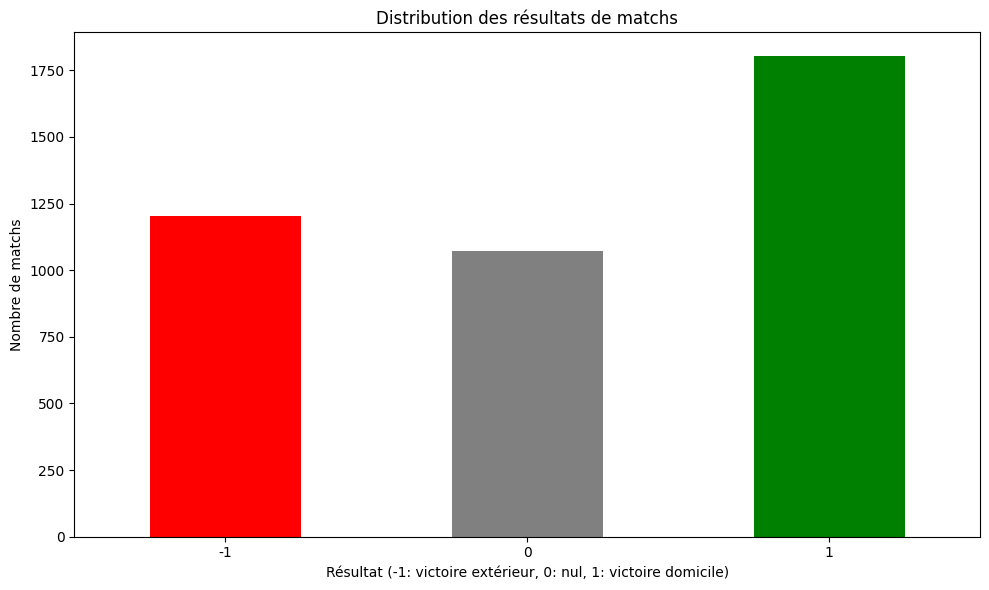

In [ ]:
# 3. ANALYSE DES RÉSULTATS
print("\n" + "="*80)
print("3. ANALYSE DES RÉSULTATS")
print("="*80)

# Distribution des résultats
result_counts = df_match_hist['results'].value_counts().sort_index()
print("\nDistribution des résultats:")
print(f"Victoire domicile (1): {result_counts.get(1, 0)}")
print(f"Match nul (0): {result_counts.get(0, 0)}")
print(f"Victoire extérieur (-1): {result_counts.get(-1, 0)}")
plt.figure(figsize=(10, 6))
result_counts.plot(kind='bar', color=['red', 'gray', 'green'])
plt.title('Distribution des résultats de matchs')
plt.xlabel('Résultat (-1: victoire extérieur, 0: nul, 1: victoire domicile)')
plt.ylabel('Nombre de matchs')
plt.xticks(rotation=0)
plt.tight_layout()


Moyenne de buts marqués par match:
Équipe à domicile: 1.4759686120647375
Équipe à l'extérieur: 1.1436978911230995
Total: 2.619666503187837


Text(0, 0.5, 'Fréquence')

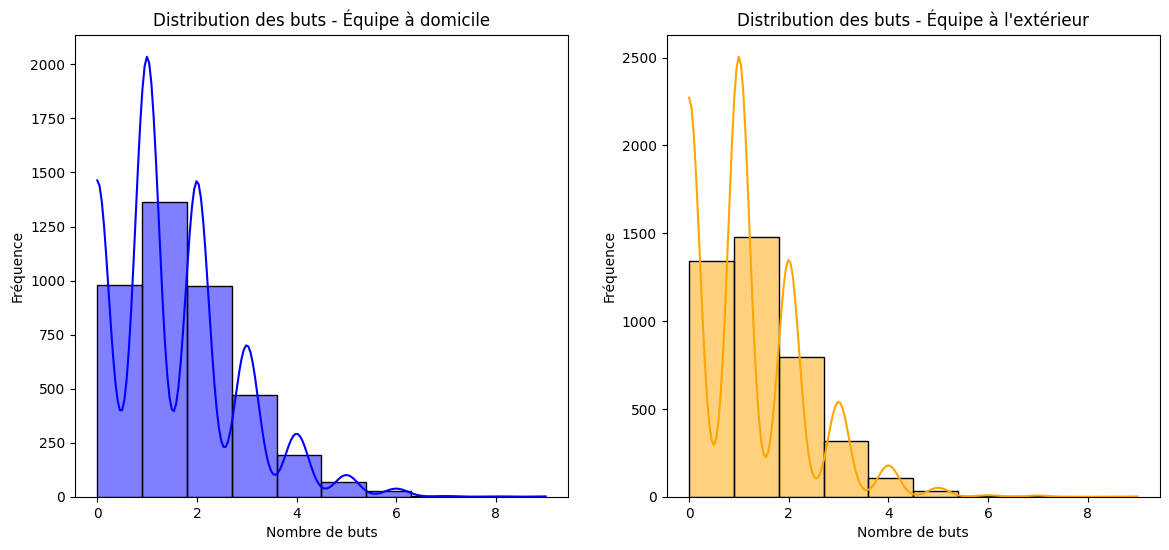

In [ ]:
# Moyenne de buts marqués par match
print("\nMoyenne de buts marqués par match:")
print("Équipe à domicile:", df_match_hist['home_club_goals'].mean())
print("Équipe à l'extérieur:", df_match_hist['away_club_goals'].mean())
print("Total:", df_match_hist['home_club_goals'].mean() + df_match_hist['away_club_goals'].mean())

# Distribution des buts
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(df_match_hist['home_club_goals'], kde=True, color='blue', bins=10)
plt.title('Distribution des buts - Équipe à domicile')
plt.xlabel('Nombre de buts')
plt.ylabel('Fréquence')

plt.subplot(1, 2, 2)
sns.histplot(df_match_hist['away_club_goals'], kde=True, color='orange', bins=10)
plt.title('Distribution des buts - Équipe à l\'extérieur')
plt.xlabel('Nombre de buts')
plt.ylabel('Fréquence')


4. ANALYSE DES ÉQUIPES

Nombre de matchs par équipe:
                                               Home  Away  Total
Olympique de Marseille                          204   204    408
Lille Olympique Sporting Club Lille Métropole   205   203    408
Stade Rennais Football Club                     204   204    408
Montpellier Hérault Sport Club                  204   204    408
Olympique Gymnaste Club Nice Côte d'Azur        205   203    408
Paris Saint-Germain Football Club               204   203    407
Olympique Lyonnais                              203   204    407
Football Club de Nantes                         185   185    370
FC Girondins Bordeaux                           184   186    370
Association sportive de Monaco Football Club    185   185    370


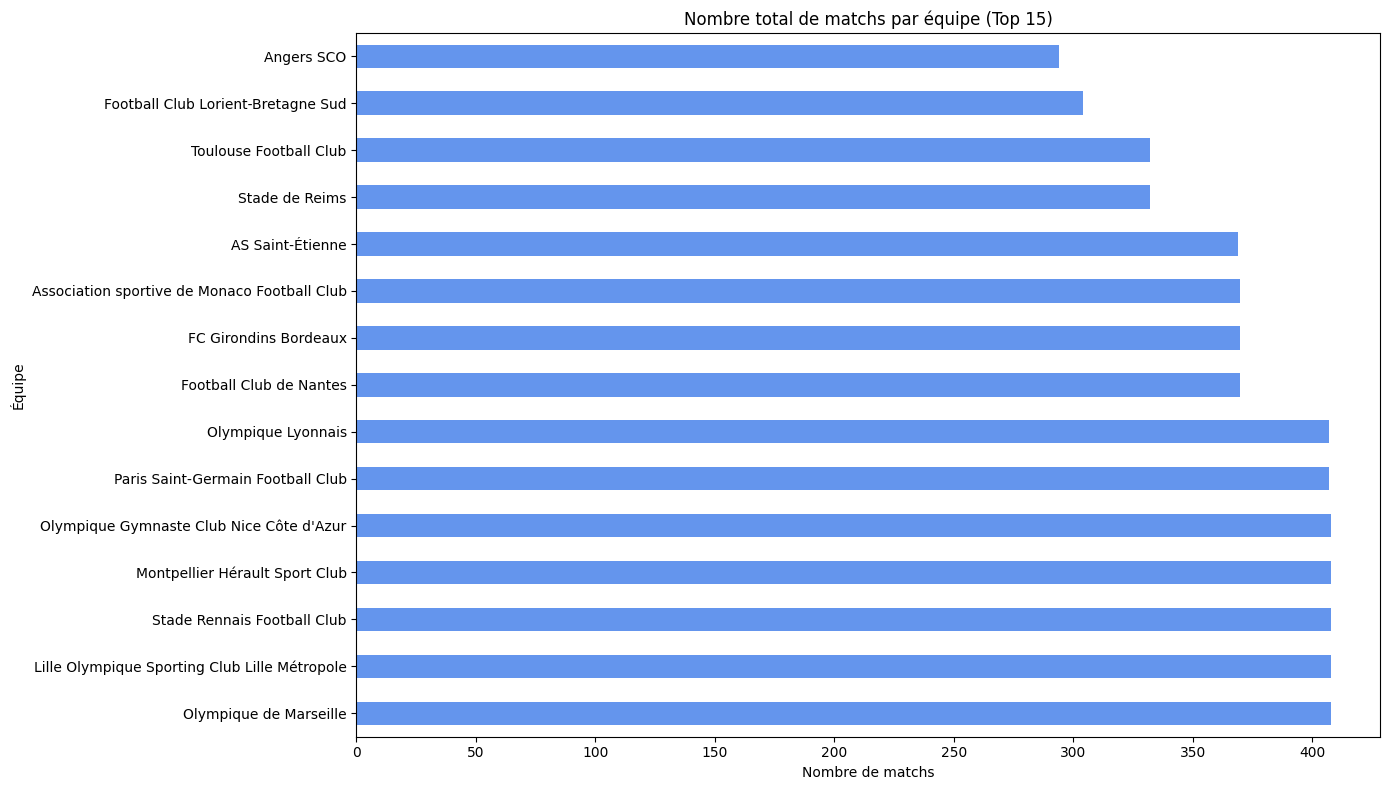

In [ ]:
# 4. ANALYSE DES ÉQUIPES
print("\n" + "="*80)
print("4. ANALYSE DES ÉQUIPES")
print("="*80)

# Nombre de matchs par équipe
home_team_counts = df_match_hist['home_club_name'].value_counts()
away_team_counts = df_match_hist['away_club_name'].value_counts()
total_team_counts = pd.DataFrame({
    'Home': home_team_counts,
    'Away': away_team_counts
}).fillna(0)
total_team_counts['Total'] = total_team_counts['Home'] + total_team_counts['Away']
total_team_counts = total_team_counts.sort_values('Total', ascending=False)

print("\nNombre de matchs par équipe:")
print(total_team_counts.head(10))

# Visualisation du nombre de matchs par équipe
plt.figure(figsize=(14, 8))
total_team_counts['Total'].head(15).plot(kind='barh', color='cornflowerblue')
plt.title('Nombre total de matchs par équipe (Top 15)')
plt.xlabel('Nombre de matchs')
plt.ylabel('Équipe')
plt.tight_layout()

In [ ]:
# 5. PERFORMANCES DES ÉQUIPES
print("\n" + "="*80)
print("5. PERFORMANCES DES ÉQUIPES")
print("="*80)

# Performances à domicile
home_team_performance = pd.DataFrame()
for team in df_match_hist['home_club_name'].unique():
    team_matches = df_match_hist[df_match_hist['home_club_name'] == team]
    total_matches = len(team_matches)
    wins = len(team_matches[team_matches['results'] == 1])
    draws = len(team_matches[team_matches['results'] == 0])
    losses = len(team_matches[team_matches['results'] == -1])

    home_team_performance = pd.concat([home_team_performance, pd.DataFrame({
        'Team': [team],
        'TotalMatches': [total_matches],
        'Wins': [wins],
        'WinRate': [wins / total_matches if total_matches > 0 else 0],
        'Draws': [draws],
        'DrawRate': [draws / total_matches if total_matches > 0 else 0],
        'Losses': [losses],
        'LossRate': [losses / total_matches if total_matches > 0 else 0],
        'GoalsScored': [team_matches['home_club_goals'].sum()],
        'GoalsConceded': [team_matches['away_club_goals'].sum()],
        'GoalDifference': [team_matches['home_club_goals'].sum() - team_matches['away_club_goals'].sum()]
    })], ignore_index=True)

# Trier par taux de victoire
home_team_performance = home_team_performance.sort_values('WinRate', ascending=False)

print("\nPerformances des équipes à domicile (Top 10):")
print(home_team_performance[['Team', 'TotalMatches', 'WinRate', 'DrawRate', 'LossRate']].head(10))

# Performances à l'extérieur
away_team_performance = pd.DataFrame()
for team in df_match_hist['away_club_name'].unique():
    team_matches = df_match_hist[df_match_hist['away_club_name'] == team]
    total_matches = len(team_matches)
    wins = len(team_matches[team_matches['results'] == -1])
    draws = len(team_matches[team_matches['results'] == 0])
    losses = len(team_matches[team_matches['results'] == 1])

    away_team_performance = pd.concat([away_team_performance, pd.DataFrame({
        'Team': [team],
        'TotalMatches': [total_matches],
        'Wins': [wins],
        'WinRate': [wins / total_matches if total_matches > 0 else 0],
        'Draws': [draws],
        'DrawRate': [draws / total_matches if total_matches > 0 else 0],
        'Losses': [losses],
        'LossRate': [losses / total_matches if total_matches > 0 else 0],
        'GoalsScored': [team_matches['away_club_goals'].sum()],
        'GoalsConceded': [team_matches['home_club_goals'].sum()],
        'GoalDifference': [team_matches['away_club_goals'].sum() - team_matches['home_club_goals'].sum()]
    })], ignore_index=True)

# Trier par taux de victoire
away_team_performance = away_team_performance.sort_values('WinRate', ascending=False)

print("\nPerformances des équipes à l'extérieur (Top 10):")
print(away_team_performance[['Team', 'TotalMatches', 'WinRate', 'DrawRate', 'LossRate']].head(10))



5. PERFORMANCES DES ÉQUIPES

Performances des équipes à domicile (Top 10):
                                             Team  TotalMatches   WinRate  \
20              Paris Saint-Germain Football Club           204  0.779412   
17                             Olympique Lyonnais           203  0.581281   
9    Association sportive de Monaco Football Club           185  0.578378   
5                          Olympique de Marseille           204  0.544118   
24  Lille Olympique Sporting Club Lille Métropole           205  0.531707   
8        Olympique Gymnaste Club Nice Côte d'Azur           205  0.512195   
12                            Racing Club de Lens            76  0.500000   
3                     Stade Rennais Football Club           204  0.480392   
0                                AS Saint-Étienne           184  0.467391   
11                                      SC Bastia            95  0.452632   

    DrawRate  LossRate  
20  0.147059  0.073529  
17  0.221675  0.197044  
9


6. ANALYSE DES FORMATIONS TACTIQUES

Formations les plus utilisées à domicile:
home_club_formation
4-2-3-1            1082
4-3-3 Attacking     762
4-4-2 double 6      469
4-1-4-1             225
4-3-1-2             190
4-4-2               150
5-3-2               148
3-4-1-2             106
3-4-2-1              97
5-4-1                87
Name: count, dtype: int64

Formations les plus utilisées à l'extérieur:
away_club_formation
4-2-3-1            1018
4-3-3 Attacking     773
4-4-2 double 6      366
4-1-4-1             261
5-3-2               192
4-3-1-2             166
4-4-2               147
5-4-1               130
3-4-1-2             112
3-4-2-1             107
Name: count, dtype: int64


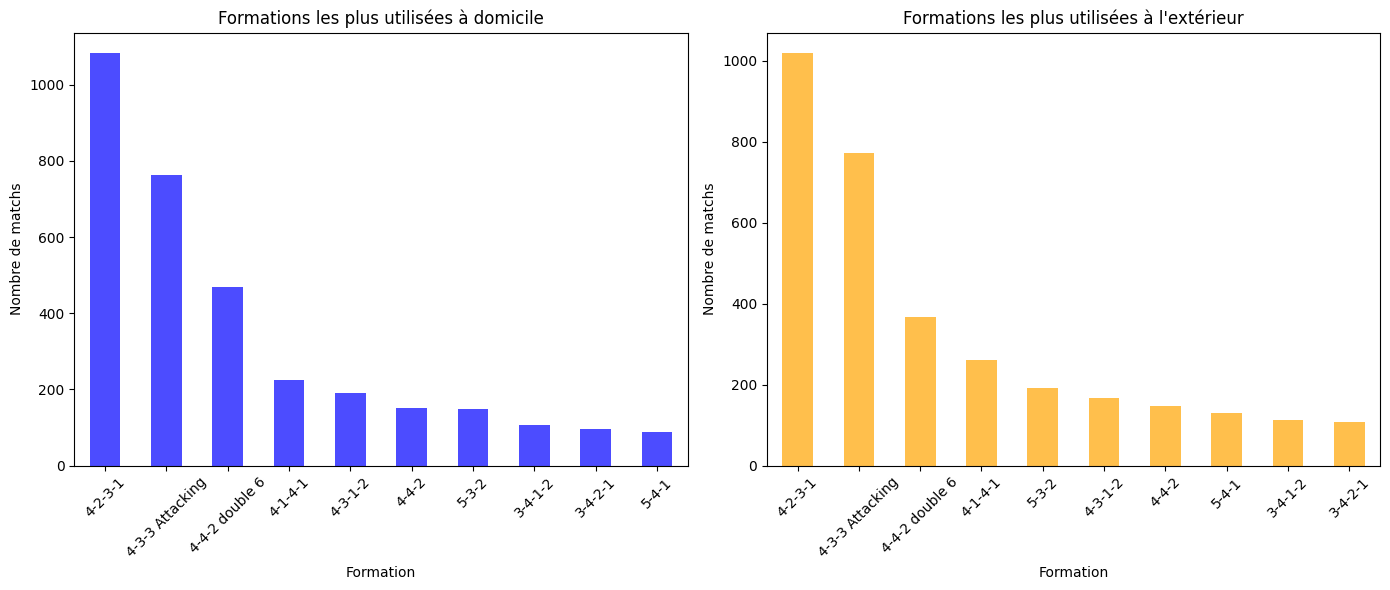

In [ ]:
# 6. ANALYSE DES FORMATIONS TACTIQUES
print("\n" + "="*80)
print("6. ANALYSE DES FORMATIONS TACTIQUES")
print("="*80)

# Formations les plus utilisées à domicile
home_formations = df_match_hist['home_club_formation'].value_counts().head(10)
print("\nFormations les plus utilisées à domicile:")
print(home_formations)

# Formations les plus utilisées à l'extérieur
away_formations = df_match_hist['away_club_formation'].value_counts().head(10)
print("\nFormations les plus utilisées à l'extérieur:")
print(away_formations)

# Visualisation des formations
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
home_formations.plot(kind='bar', color='blue', alpha=0.7)
plt.title('Formations les plus utilisées à domicile')
plt.xlabel('Formation')
plt.ylabel('Nombre de matchs')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
away_formations.plot(kind='bar', color='orange', alpha=0.7)
plt.title('Formations les plus utilisées à l\'extérieur')
plt.xlabel('Formation')
plt.ylabel('Nombre de matchs')
plt.xticks(rotation=45)

plt.tight_layout()


7. CORRÉLATIONS ENTRE VARIABLES


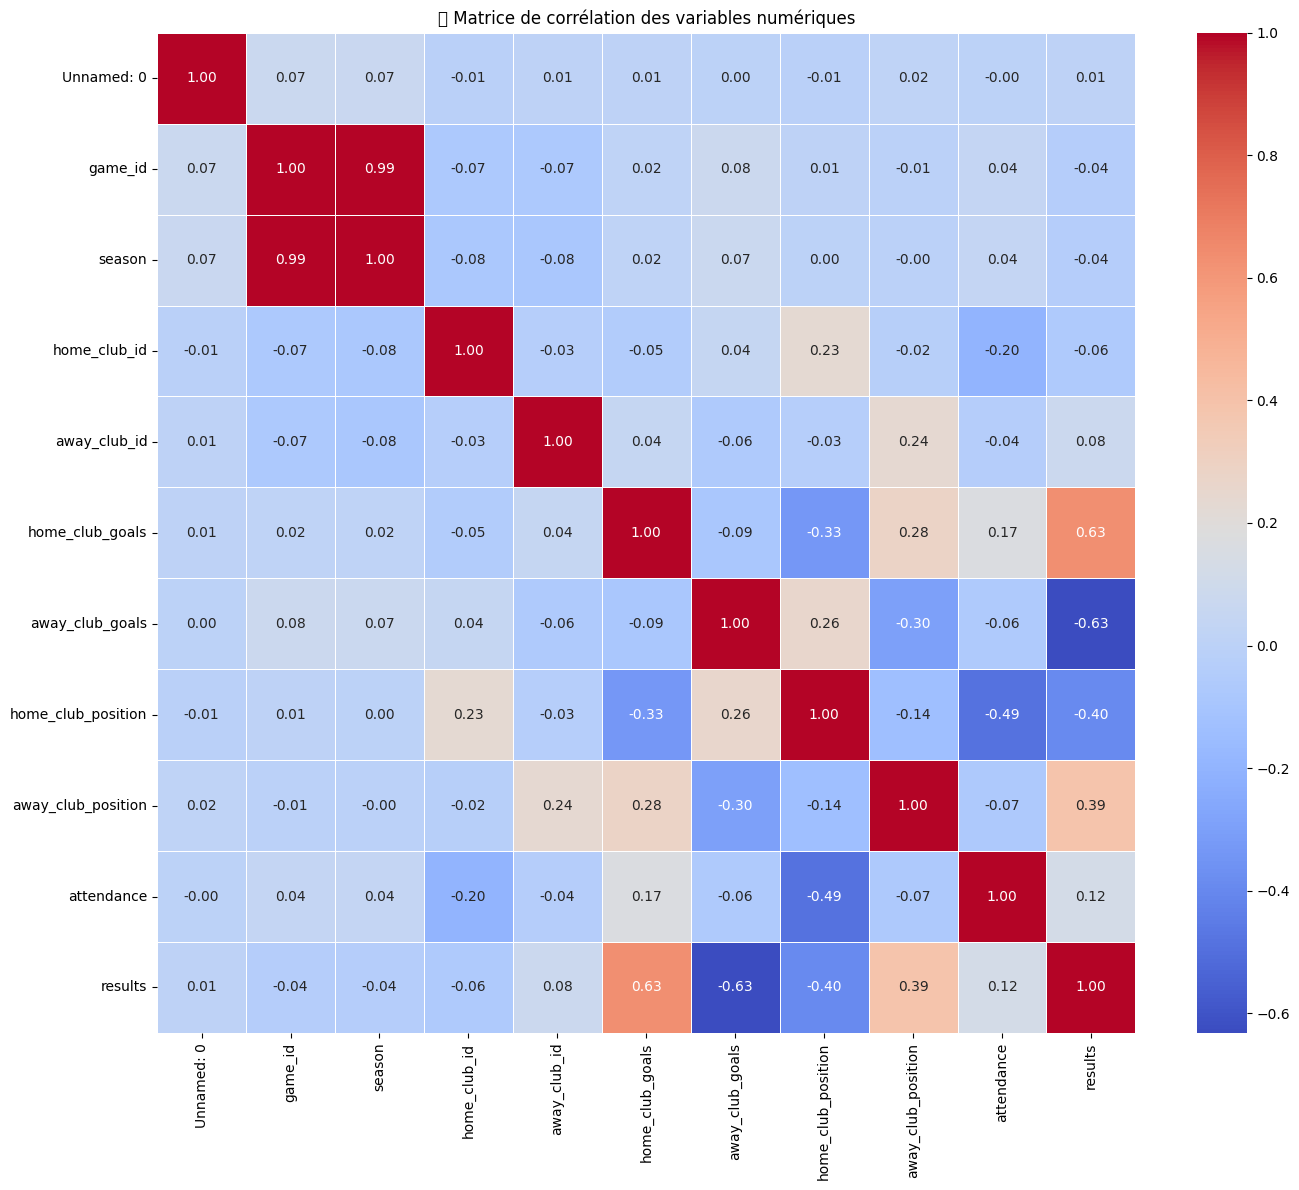


✅ Tableau complet des corrélations (ou type non numérique) :
                  Variable Correlation_with_results
0               Unnamed: 0                   0.0116
1                  game_id                  -0.0385
2                   season                  -0.0372
3                    round            Non numérique
4                     date            Non numérique
5             home_club_id                  -0.0633
6             away_club_id                   0.0808
7          home_club_goals                   0.6314
8          away_club_goals                  -0.6322
9       home_club_position                  -0.3956
10      away_club_position                   0.3928
11  home_club_manager_name            Non numérique
12  away_club_manager_name            Non numérique
13                 stadium            Non numérique
14              attendance                   0.1229
15                 referee            Non numérique
16     home_club_formation            Non numérique
17

In [ ]:
# 7. CORRÉLATIONS ENTRE VARIABLES
print("\n" + "="*80)
print("7. CORRÉLATIONS ENTRE VARIABLES")
print("="*80)

# Sélection des colonnes numériques
numeric_columns = df_match_hist.select_dtypes(include=['int64', 'float64']).columns

# Matrice de corrélation
correlation_matrix = df_match_hist[numeric_columns].corr()

# 🔍 Affichage de la matrice de corrélation complète en heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('🔍 Matrice de corrélation des variables numériques')
plt.tight_layout()
plt.show()

# Liste de toutes les colonnes
all_columns = df_match_hist.columns.tolist()

# Obtenir corrélations uniquement pour colonnes numériques
corr_numeric = df_match_hist.select_dtypes(include=['int64', 'float64']).corr()['results']

# Construction du tableau complet
correlation_results = []
for col in all_columns:
    if col == 'results':
        continue
    if col in corr_numeric:
        correlation_results.append({'Variable': col, 'Correlation_with_results': round(corr_numeric[col], 4)})
    else:
        correlation_results.append({'Variable': col, 'Correlation_with_results': 'Non numérique'})

# Transformation en DataFrame
correlation_table_full = pd.DataFrame(correlation_results)

# Affichage
print("\n✅ Tableau complet des corrélations (ou type non numérique) :")
print(correlation_table_full)



## Autre approche avec l'encodage des variables non numeriques avec `OrdinalEncoder`

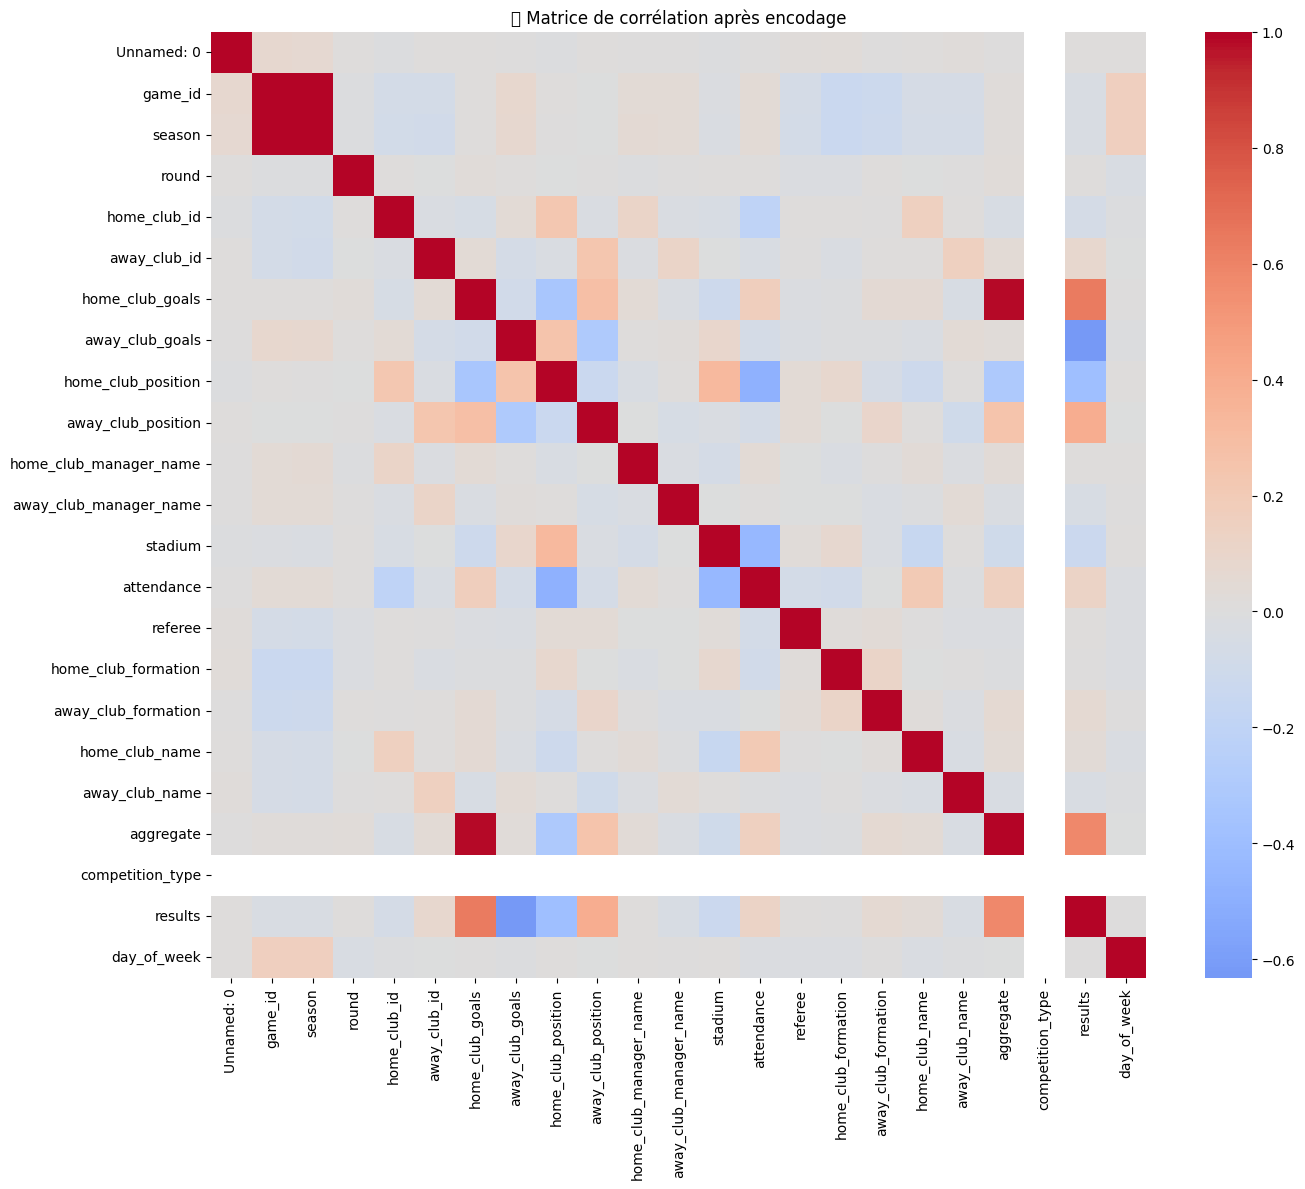


✅ Tableau complet des corrélations (après encodage) :


Variable Correlation_with_results
0               Unnamed: 0                   0.0116
1                  game_id                  -0.0385
2                   season                  -0.0372
3                    round                   0.0135
4                     date  Non numérique (ignorée)
5             home_club_id                  -0.0633
6             away_club_id                   0.0808
7          home_club_goals                   0.6314
8          away_club_goals                  -0.6322
9       home_club_position                  -0.3956
10      away_club_position                   0.3928
11  home_club_manager_name                   0.0094
12  away_club_manager_name                  -0.0444
13                 stadium                  -0.1261
14              attendance                   0.1229
15                 referee                   0.0085
16     home_club_formation                   0.0016
17     away_club_formation                   0.0569
18          home_club_name                   0.0372
19          away_club_name                   -0.038
20               aggregate                   0.5824
21        competition_type                      NaN
22             day_of_week                   0.0049

In [ ]:
# 1. Copier le dataset
df_encoded = df_match_hist.copy()

# 2. Identifier les colonnes non numériques
non_numeric_cols = df_encoded.select_dtypes(include=['object']).columns.tolist()
# 3. Encoder les colonnes non numériques avec OrdinalEncoder
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
df_encoded[non_numeric_cols] = encoder.fit_transform(df_encoded[non_numeric_cols])

# 4. Calculer la matrice de corrélation
correlation_matrix = df_encoded.corr(numeric_only=True)

# 5. Extraire la colonne des corrélations avec 'results'
corr_with_target = correlation_matrix['results'].drop('results').sort_values(ascending=False)

# 6. Affichage du heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
plt.title("✅ Matrice de corrélation après encodage")
plt.tight_layout()
plt.show()

# 7. Créer le tableau final : toutes les colonnes avec leurs corrélations ou une note
result_table = []
for col in df_match_hist.columns:
    if col == 'results':
        continue
    if col in correlation_matrix.columns:
        corr_value = round(correlation_matrix.at[col, 'results'], 4)
        result_table.append({'Variable': col, 'Correlation_with_results': corr_value})
    else:
        result_table.append({'Variable': col, 'Correlation_with_results': 'Non numérique (ignorée)'})

# 8. Affichage du tableau des corrélations complet
correlation_df_full = pd.DataFrame(result_table)
print("\n✅ Tableau complet des corrélations (après encodage) :")
display(correlation_df_full)


<h3>🔍 Interprétation de la matrice de corrélation</h3>

<table>
  <thead>
    <tr>
      <th>Variable</th>
      <th>Corrélation avec <code>results</code></th>
      <th>Interprétation</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><code>home_club_goals</code></td>
      <td>+0.63</td>
      <td>Corrélation forte positive – Plus l’équipe à domicile marque, plus elle a de chances de gagner.</td>
    </tr>
    <tr>
      <td><code>away_goals</code></td>
      <td>-0.63</td>
      <td>Corrélation forte négative – Plus l’équipe adverse marque, moins l’équipe à domicile gagne.</td>
    </tr>
    <tr>
      <td><code>home_club_position</code></td>
      <td>-0.40</td>
      <td>Corrélation modérée – Une meilleure position du club à domicile est liée à de meilleurs résultats.</td>
    </tr>
    <tr>
      <td><code>away_club_position</code></td>
      <td>+0.39</td>
      <td>Corrélation modérée – Une mauvaise position du club adverse favorise l’équipe à domicile.</td>
    </tr>
    <tr>
      <td><code>Unnamed: 0</code>, <code>game_id</code>, <code>season</code>, <code>home_club_id</code>, <code>away_club_id</code>, <code>attendance</code></td>
      <td>≈ 0</td>
      <td>Corrélation très faible – Ces variables peuvent être supprimées pour simplifier le modèle.</td>
    </tr>
  </tbody>
</table>


# **I.2. Analyse Exploratoire de `match_2023.csv`**

In [ ]:
print("="*80)
print("EXPLORATION DES MATCHS À PRÉDIRE (2023)")
print("="*80)

# 1. APERÇU DE BASE DU DATASET
print("\n1. APERÇU DES DONNÉES\n")
print("Dimensions:", df_match_2023.shape)
print("\nPremières lignes:")
print(df_match_2023.head())
print("\nTypes de données:")
print(df_match_2023.dtypes)
print("\nStatistiques descriptives:")
print(df_match_2023.describe())
print("\nValeurs manquantes:")
print(df_match_2023.isnull().sum())

EXPLORATION DES MATCHS À PRÉDIRE (2023)

1. APERÇU DES DONNÉES

Dimensions: (270, 12)

Premières lignes:
   game_id        date  home_club_id  away_club_id home_club_manager_name  \
0  4094596  2023-08-26           583           826           Luis Enrique   
1  4094622  2023-09-16           826           347           Franck Haise   
2  4094630  2023-09-24           969           273    Michel Der Zakarian   
3  4094647  2023-10-07           347           417          László Bölöni   
4  4094696  2023-12-03           244           273        Gennaro Gattuso   

  away_club_manager_name                 stadium  attendance  \
0           Franck Haise        Parc des Princes     47000.0   
1          László Bölöni  Stade Bollaert-Delelis     37988.0   
2          Bruno Génésio      Stade de la Mosson     15430.0   
3      Francesco Farioli  Stade Saint-Symphorien     23160.0   
4         Julien Stéphan        Orange Vélodrome     54162.0   

              referee                     home_


2. ANALYSE TEMPORELLE

Distribution des matchs par mois:
month_name
August       27.0
September    30.0
October      31.0
November     27.0
December     38.0
January      18.0
February     36.0
March        36.0
April        27.0
May           NaN
Name: count, dtype: float64

Distribution des matchs par jour de la semaine:
day_of_week
Sunday       167
Saturday      58
Friday        29
Wednesday     14
Thursday       1
Tuesday        1
Name: count, dtype: int64


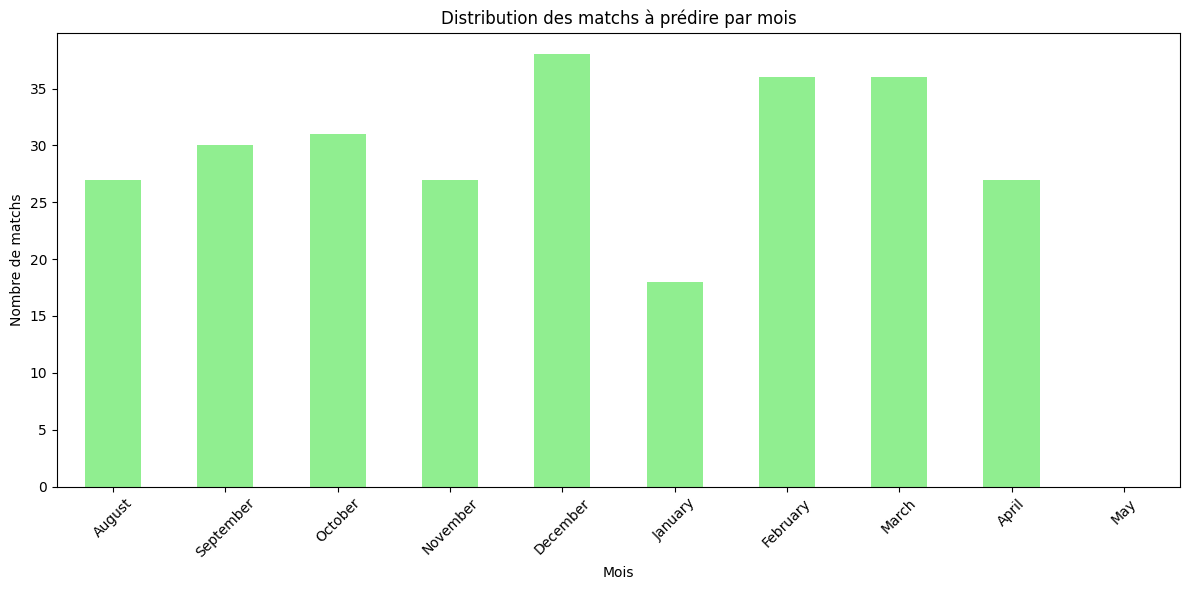

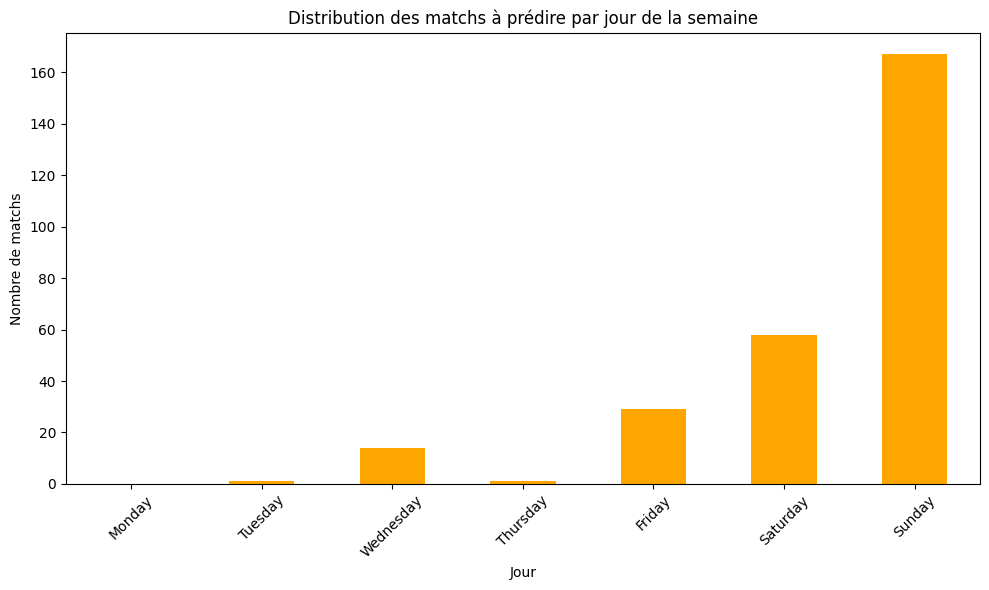

In [ ]:
# 2. ANALYSE TEMPORELLE
print("\n" + "="*80)
print("2. ANALYSE TEMPORELLE")
print("="*80)

# Convertir les dates en format datetime
df_match_2023['date'] = pd.to_datetime(df_match_2023['date'])

# Distribution des matchs par mois
df_match_2023['month'] = df_match_2023['date'].dt.month
df_match_2023['month_name'] = df_match_2023['date'].dt.month_name()
month_counts = df_match_2023['month_name'].value_counts().reindex(['August', 'September', 'October', 'November', 'December', 'January', 'February', 'March', 'April', 'May'])
print("\nDistribution des matchs par mois:")
print(month_counts)

plt.figure(figsize=(12, 6))
month_counts.plot(kind='bar', color='lightgreen')
plt.title('Distribution des matchs à prédire par mois')
plt.xlabel('Mois')
plt.ylabel('Nombre de matchs')
plt.xticks(rotation=45)
plt.tight_layout()
# Distribution des matchs par jour de la semaine
df_match_2023['day_of_week'] = df_match_2023['date'].dt.day_name()
day_counts = df_match_2023['day_of_week'].value_counts()
print("\nDistribution des matchs par jour de la semaine:")
print(day_counts)

plt.figure(figsize=(10, 6))
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts = day_counts.reindex(day_order)
day_counts.plot(kind='bar', color='orange')
plt.title('Distribution des matchs à prédire par jour de la semaine')
plt.xlabel('Jour')
plt.ylabel('Nombre de matchs')
plt.xticks(rotation=45)
plt.tight_layout()



6. ANALYSE DES ÉQUIPES PARTICULIÈRES

Matchs impliquant Le Havre (à prédire):
         date                  home_club_name  \
26 2023-08-13  Montpellier Hérault Sport Club   
38 2023-09-03          Le Havre Athletic Club   
41 2024-04-14          Le Havre Athletic Club   
48 2023-11-26         Football Club de Nantes   
49 2023-09-17              Olympique Lyonnais   

                        away_club_name  
26              Le Havre Athletic Club  
38  Football Club Lorient-Bretagne Sud  
41             Football Club de Nantes  
48              Le Havre Athletic Club  
49              Le Havre Athletic Club  
Nombre total de matchs avec Le Havre: 30


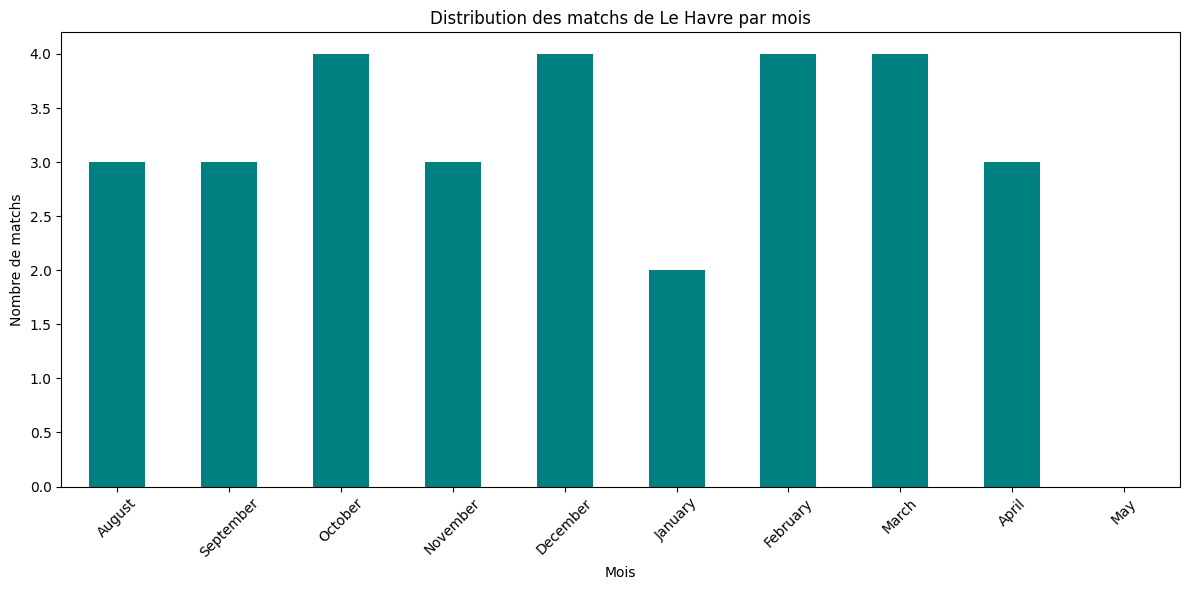

In [ ]:
# 6. ANALYSE DES ÉQUIPES PARTICULIÈRES
print("\n" + "="*80)
print("6. ANALYSE DES ÉQUIPES PARTICULIÈRES")
print("="*80)

# Identifier Le Havre et autres équipes nouvelles dans les matchs à prédire
le_havre_matches = df_match_2023[
    (df_match_2023['home_club_name'] == 'Le Havre Athletic Club') |
    (df_match_2023['away_club_name'] == 'Le Havre Athletic Club')
]

print("\nMatchs impliquant Le Havre (à prédire):")
print(le_havre_matches[['date', 'home_club_name', 'away_club_name']].head())
print(f"Nombre total de matchs avec Le Havre: {len(le_havre_matches)}")

# Distribution des matchs de Le Havre par mois
if len(le_havre_matches) > 0:
    le_havre_month_counts = le_havre_matches['month_name'].value_counts().reindex(['August', 'September', 'October', 'November', 'December', 'January', 'February', 'March', 'April', 'May'])

    plt.figure(figsize=(12, 6))
    le_havre_month_counts.plot(kind='bar', color='teal')
    plt.title('Distribution des matchs de Le Havre par mois')
    plt.xlabel('Mois')
    plt.ylabel('Nombre de matchs')
    plt.xticks(rotation=45)
    plt.tight_layout()


In [ ]:
print("2013-2022   :")
df_match_hist.info()
print("2023      :")
df_match_2023.info()

2013-2022   :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4078 entries, 0 to 4077
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Unnamed: 0              4078 non-null   int64         
 1   game_id                 4078 non-null   int64         
 2   season                  4078 non-null   int64         
 3   round                   4078 non-null   object        
 4   date                    4078 non-null   datetime64[ns]
 5   home_club_id            4078 non-null   int64         
 6   away_club_id            4078 non-null   int64         
 7   home_club_goals         4078 non-null   int64         
 8   away_club_goals         4078 non-null   int64         
 9   home_club_position      4078 non-null   float64       
 10  away_club_position      4078 non-null   float64       
 11  home_club_manager_name  4078 non-null   object        
 12  away_club_manager_name  4078 non-n

# **I.3. Analyse Exploratoire de `clubs_fr.csv`**

In [ ]:
print("="*80)
print("EXPLORATION DES INFORMATIONS SUR LES CLUBS")
print("="*80)

# 1. APERÇU DE BASE DU DATASET
print("\n1. APERÇU DES DONNÉES\n")
print("Dimensions:", df_clubs.shape)
print("\nPremières lignes:")
print(df_clubs.head())
print("\nTypes de données:")
print(df_clubs.dtypes)
print("\nStatistiques descriptives:")
print(df_clubs.describe())
print("\nValeurs manquantes:")
print(df_clubs.isnull().sum())


EXPLORATION DES INFORMATIONS SUR LES CLUBS

1. APERÇU DES DONNÉES

Dimensions: (35, 13)

Premières lignes:
   club_id        club_code                                           name  \
0      969  montpellier-hsc                 Montpellier Hérault Sport Club   
1     1082       losc-lille  Lille Olympique Sporting Club Lille Métropole   
2     1160  nimes-olympique                                Nîmes Olympique   
3     3911   stade-brest-29                              Stade brestois 29   
4      595        sc-bastia                                      SC Bastia   

  domestic_competition_id  squad_size  average_age  foreigners_number  \
0                     FR1          25         25.7                 12   
1                     FR1          25         25.4                 18   
2                     FR1          26         25.4                 12   
3                     FR1          24         26.0                  6   
4                     FR1          25         27.6         


2. ANALYSE DES EFFECTIFS

Statistiques sur les effectifs des clubs:
Taille moyenne des effectifs: 25.8
Âge moyen des joueurs: 25.20857142857143
Nombre moyen de joueurs étrangers: 13.028571428571428
Pourcentage moyen de joueurs étrangers: 49.973143185951066


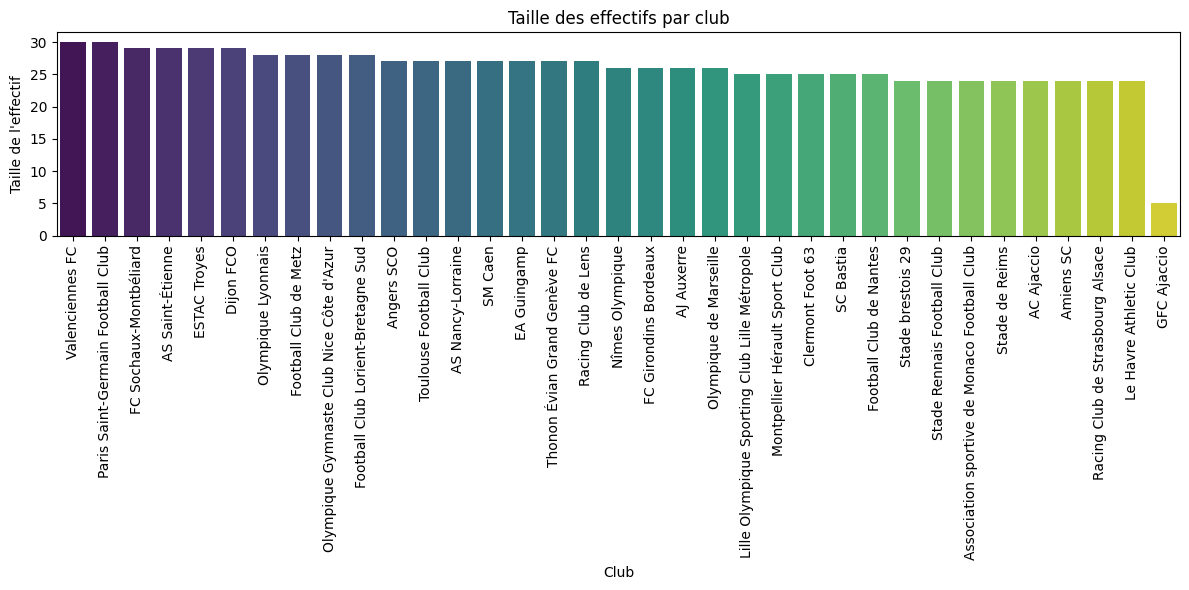

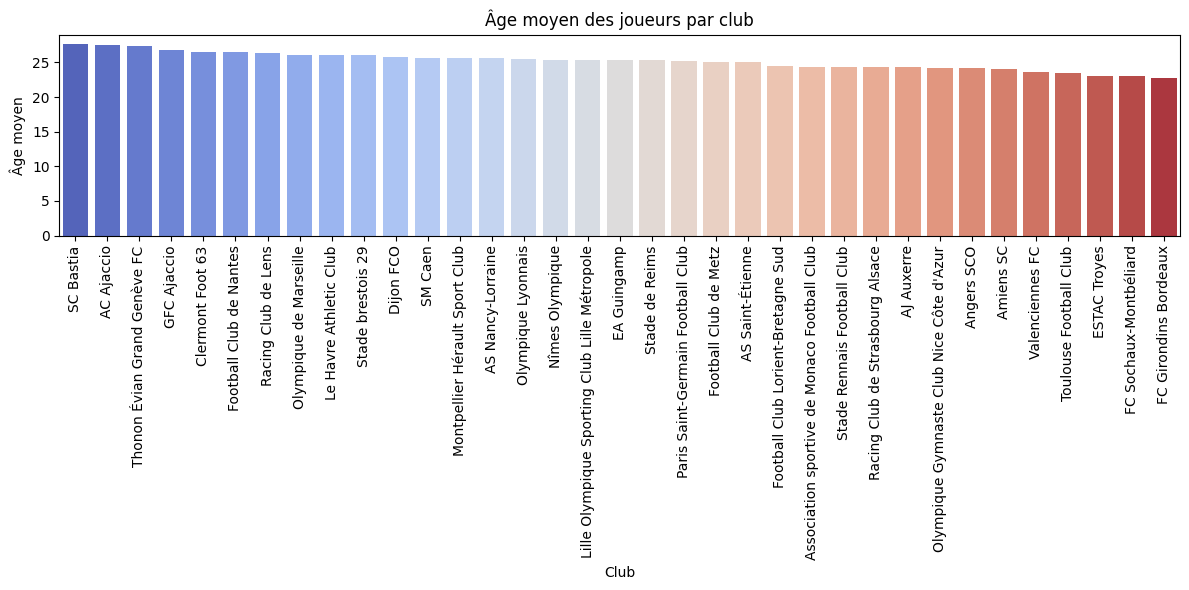

In [ ]:
# 2. ANALYSE DES EFFECTIFS
print("\n" + "="*80)
print("2. ANALYSE DES EFFECTIFS")
print("="*80)

# Statistiques sur les effectifs
print("\nStatistiques sur les effectifs des clubs:")
print("Taille moyenne des effectifs:", df_clubs['squad_size'].mean())
print("Âge moyen des joueurs:", df_clubs['average_age'].mean())
print("Nombre moyen de joueurs étrangers:", df_clubs['foreigners_number'].mean())
print("Pourcentage moyen de joueurs étrangers:", (df_clubs['foreigners_number'] / df_clubs['squad_size'] * 100).mean())

# Visualisation de la taille des effectifs
plt.figure(figsize=(12, 6))
df_clubs = df_clubs.sort_values('squad_size', ascending=False)
sns.barplot(x='name', y='squad_size', data=df_clubs, palette='viridis')
plt.title('Taille des effectifs par club')
plt.xlabel('Club')
plt.ylabel('Taille de l\'effectif')
plt.xticks(rotation=90)
plt.tight_layout()

# Visualisation de l'âge moyen
plt.figure(figsize=(12, 6))
df_clubs = df_clubs.sort_values('average_age', ascending=False)
sns.barplot(x='name', y='average_age', data=df_clubs, palette='coolwarm')
plt.title('Âge moyen des joueurs par club')
plt.xlabel('Club')
plt.ylabel('Âge moyen')
plt.xticks(rotation=90)
plt.tight_layout()



3. ANALYSE DES JOUEURS ÉTRANGERS


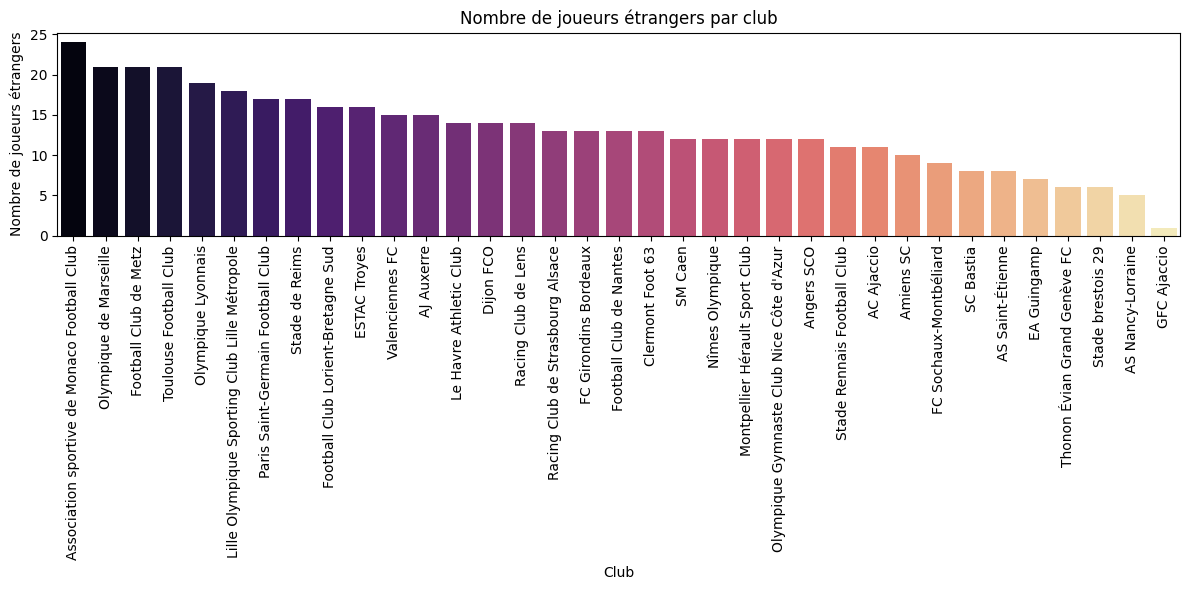

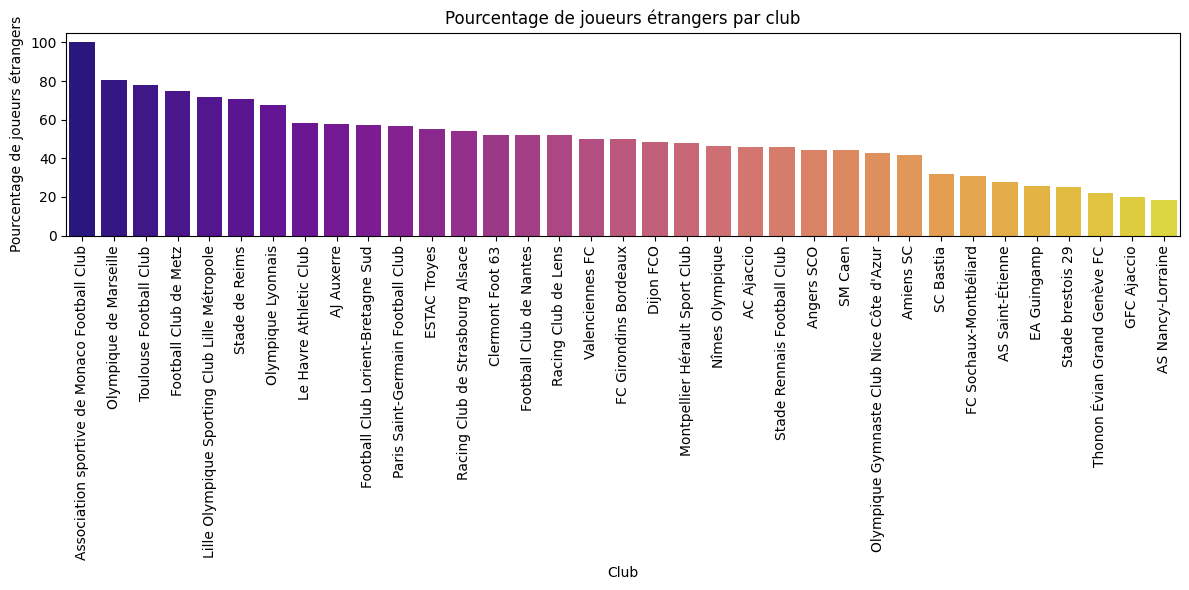

In [ ]:
# 3. ANALYSE DES JOUEURS ÉTRANGERS
print("\n" + "="*80)
print("3. ANALYSE DES JOUEURS ÉTRANGERS")
print("="*80)

# Nombre de joueurs étrangers
plt.figure(figsize=(12, 6))
df_clubs = df_clubs.sort_values('foreigners_number', ascending=False)
sns.barplot(x='name', y='foreigners_number', data=df_clubs, palette='magma')
plt.title('Nombre de joueurs étrangers par club')
plt.xlabel('Club')
plt.ylabel('Nombre de joueurs étrangers')
plt.xticks(rotation=90)
plt.tight_layout()

# Pourcentage de joueurs étrangers
df_clubs['foreigners_percentage'] = df_clubs['foreigners_number'] / df_clubs['squad_size'] * 100
plt.figure(figsize=(12, 6))
df_clubs = df_clubs.sort_values('foreigners_percentage', ascending=False)
sns.barplot(x='name', y='foreigners_percentage', data=df_clubs, palette='plasma')
plt.title('Pourcentage de joueurs étrangers par club')
plt.xlabel('Club')
plt.ylabel('Pourcentage de joueurs étrangers')
plt.xticks(rotation=90)
plt.tight_layout()


4. ANALYSE DES INFRASTRUCTURES

Statistiques sur les stades:
Capacité moyenne des stades: 26239.314285714285
Capacité médiane des stades: 21684.0
Plus grande capacité: 67394
Plus petite capacité: 2500


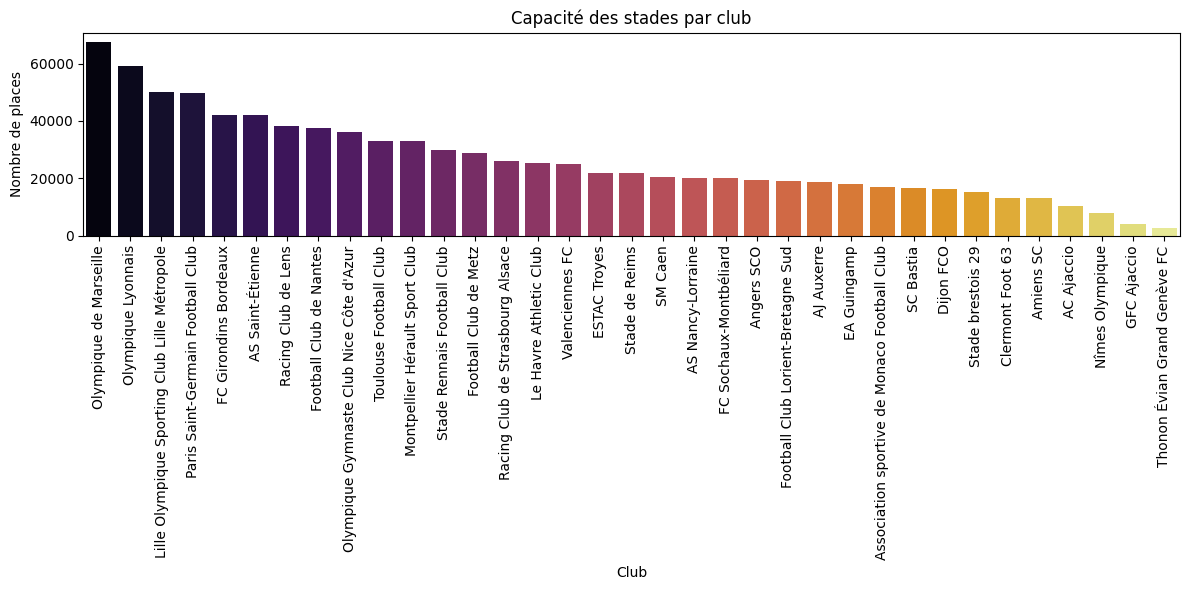

In [ ]:
# 4. ANALYSE DES INFRASTRUCTURES
print("\n" + "="*80)
print("4. ANALYSE DES INFRASTRUCTURES")
print("="*80)

# Capacité des stades
print("\nStatistiques sur les stades:")
print("Capacité moyenne des stades:", df_clubs['stadium_seats'].mean())
print("Capacité médiane des stades:", df_clubs['stadium_seats'].median())
print("Plus grande capacité:", df_clubs['stadium_seats'].max())
print("Plus petite capacité:", df_clubs['stadium_seats'].min())

plt.figure(figsize=(12, 6))
df_clubs = df_clubs.sort_values('stadium_seats', ascending=False)
sns.barplot(x='name', y='stadium_seats', data=df_clubs, palette='inferno')
plt.title('Capacité des stades par club')
plt.xlabel('Club')
plt.ylabel('Nombre de places')
plt.xticks(rotation=90)
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()



5. RELATIONS ENTRE VARIABLES


<Axes: >

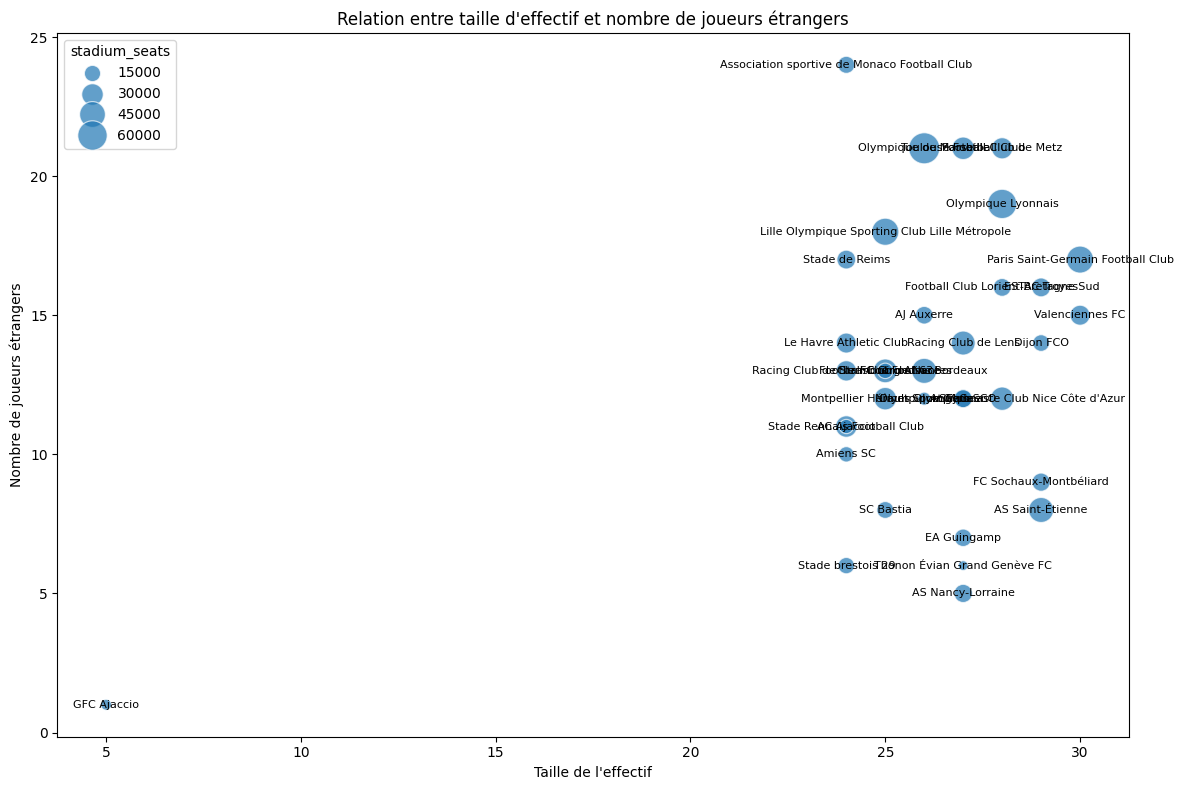

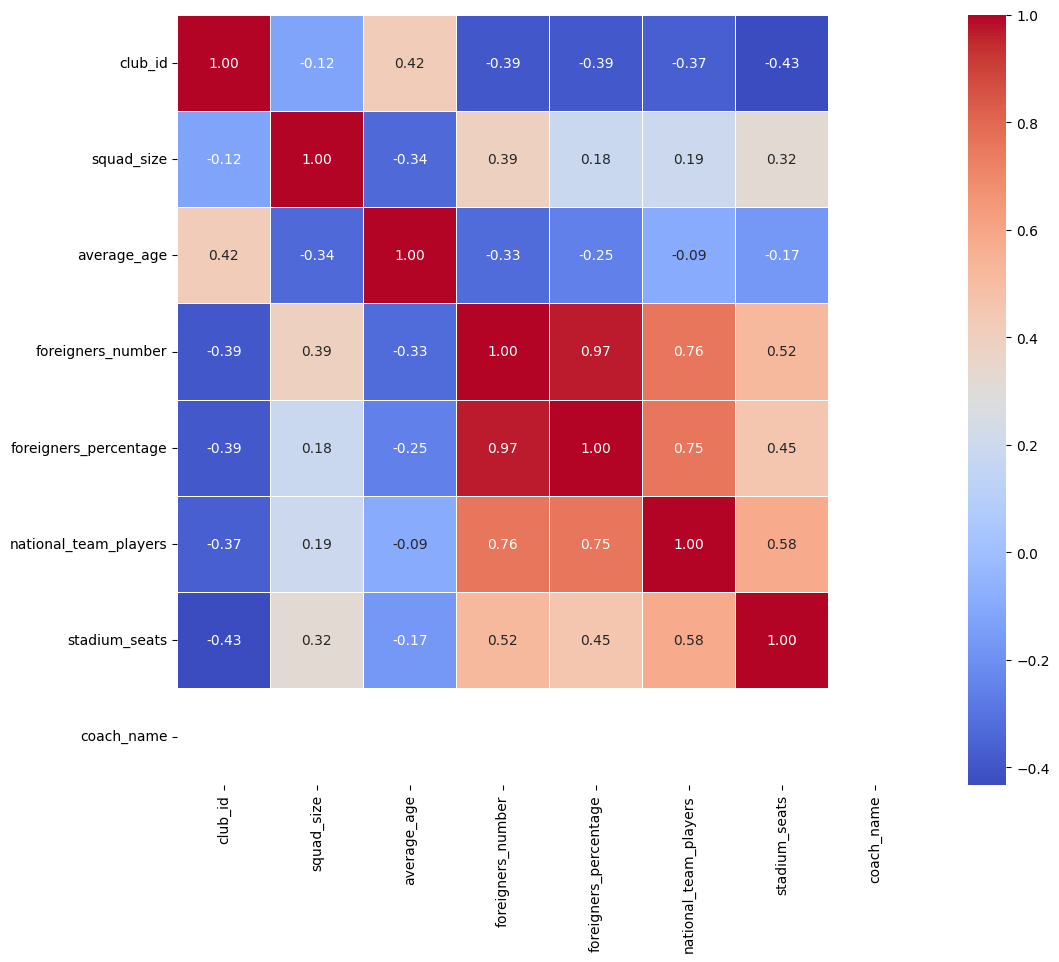

In [ ]:
# 5. RELATIONS ENTRE VARIABLES
print("\n" + "="*80)
print("5. RELATIONS ENTRE VARIABLES")
print("="*80)

# Relation entre la taille de l'effectif et le nombre de joueurs étrangers
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_clubs, x='squad_size', y='foreigners_number',
                size='stadium_seats', sizes=(50, 500), alpha=0.7)
plt.title('Relation entre taille d\'effectif et nombre de joueurs étrangers')
plt.xlabel('Taille de l\'effectif')
plt.ylabel('Nombre de joueurs étrangers')
for i, row in df_clubs.iterrows():
    plt.text(row['squad_size'], row['foreigners_number'], row['name'],
             fontsize=8, ha='center', va='center')
plt.tight_layout()

# Matrice de corrélation
numeric_columns = df_clubs.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = df_clubs[numeric_columns].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# **I.4. Analyse Exploratoire de `player_valuation_before_season.csv`**

In [ ]:
# 1. APERÇU DE BASE DU DATASET
df_valuations.info()
print("\n1. APERÇU DES DONNÉES\n")
print("Dimensions:", df_valuations.shape)
print("\nPremières lignes:")
print(df_valuations.head())
print("\nTypes de données:")
print(df_valuations.dtypes)
print("\nStatistiques descriptives:")
print(df_valuations.describe())
print("\nValeurs manquantes:")
print(df_valuations.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30215 entries, 0 to 30214
Data columns (total 5 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   player_id                            30215 non-null  int64 
 1   date                                 30215 non-null  object
 2   market_value_in_eur                  30215 non-null  int64 
 3   current_club_id                      30215 non-null  int64 
 4   player_club_domestic_competition_id  30215 non-null  object
dtypes: int64(3), object(2)
memory usage: 1.2+ MB

1. APERÇU DES DONNÉES

Dimensions: (30215, 5)

Premières lignes:
   player_id        date  market_value_in_eur  current_club_id  \
0        773  2004-10-04              3500000            14171   
1       1327  2004-10-04              4000000             1159   
2       1423  2004-10-04              1000000              855   
3       1572  2004-10-04              1000000            

In [ ]:
df_valuations.head()

player_id        date  market_value_in_eur  current_club_id  \
0        773  2004-10-04              3500000            14171   
1       1327  2004-10-04              4000000             1159   
2       1423  2004-10-04              1000000              855   
3       1572  2004-10-04              1000000              162   
4       1613  2004-10-04               200000              855   

  player_club_domestic_competition_id  
0                                 FR1  
1                                 FR1  
2                                 FR1  
3                                 FR1  
4                                 FR1

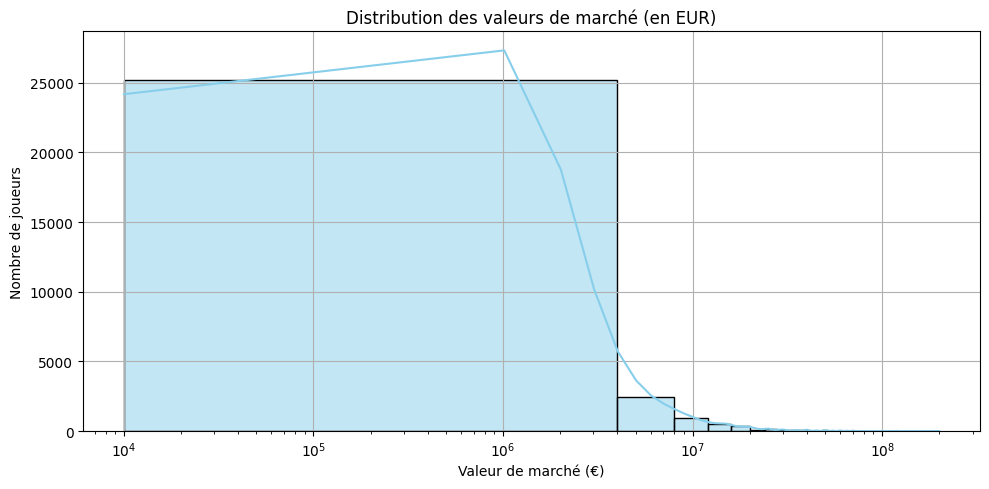

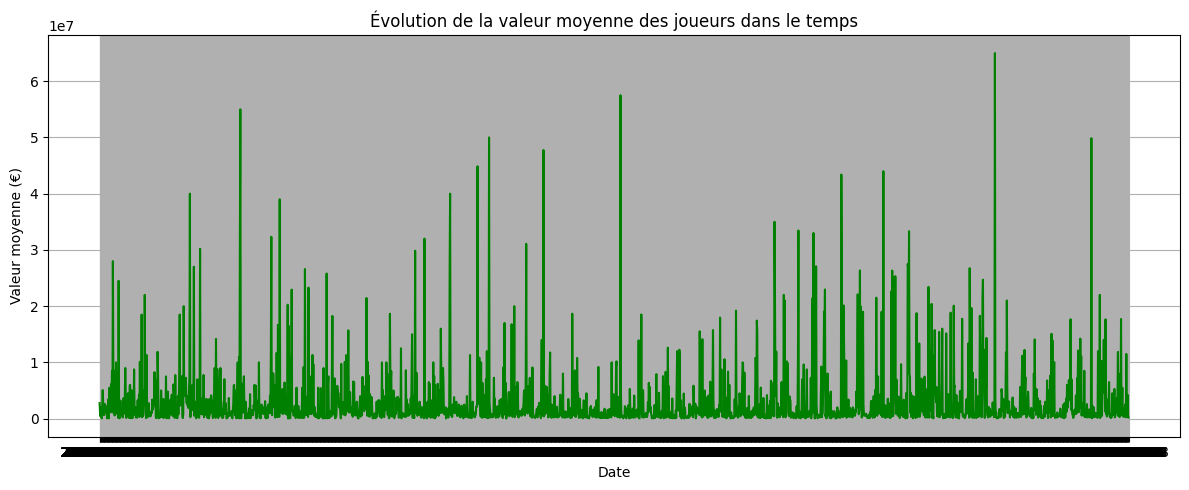

🔝 Joueurs avec les plus fortes valeurs de marché à la date la plus récente :
       player_id  market_value_in_eur  current_club_id
30214     696598               300000              417
30212     363717               150000             1162
30213     396131               150000             1421


In [ ]:
# Distribution des valeurs de marché
plt.figure(figsize=(10, 5))
sns.histplot(df_valuations['market_value_in_eur'], bins=50, kde=True, color='skyblue')
plt.title("Distribution des valeurs de marché (en EUR)")
plt.xlabel("Valeur de marché (€)")
plt.ylabel("Nombre de joueurs")
plt.xscale("log")  # car les valeurs varient beaucoup
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------------------
# Évolution de la valeur moyenne des joueurs dans le temps
df_avg_per_date = df_valuations.groupby('date')['market_value_in_eur'].mean().reset_index()

plt.figure(figsize=(12, 5))
sns.lineplot(data=df_avg_per_date, x='date', y='market_value_in_eur', color='green')
plt.title("Évolution de la valeur moyenne des joueurs dans le temps")
plt.xlabel("Date")
plt.ylabel("Valeur moyenne (€)")
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------------------
# Joueurs avec les valeurs les plus élevées (dernière date)
latest_date = df_valuations['date'].max()
df_latest = df_valuations[df_valuations['date'] == latest_date]
top_players = df_latest.sort_values(by='market_value_in_eur', ascending=False).head(10)

print("🔝 Joueurs avec les plus fortes valeurs de marché à la date la plus récente :")
print(top_players[['player_id', 'market_value_in_eur', 'current_club_id']])

# **I.5. Analyse Exploratoire de `player_appearance.csv`**

In [ ]:

print("="*80)
print("EXPLORATION DES APPARITIONS DES JOUEURS")
print("="*80)

# 1. APERÇU DE BASE DU DATASET
print("\n1. APERÇU DES DONNÉES\n")
print("Dimensions:", df_appearance.shape)
print("\nPremières lignes:")
print(df_appearance.head())
print("\nTypes de données:")
print(df_appearance.dtypes)
print("\nStatistiques descriptives:")
print(df_appearance.describe())
print("\nValeurs manquantes:")
print(df_appearance.isnull().sum())

# Convertir les dates en format datetime si nécessaire
if 'match_date' in df_appearance.columns and df_appearance['match_date'].dtype == object:
    df_appearance['match_date'] = pd.to_datetime(df_appearance['match_date'])

EXPLORATION DES APPARITIONS DES JOUEURS

1. APERÇU DES DONNÉES

Dimensions: (115182, 13)

Premières lignes:
    appearance_id  game_id  player_id  player_club_id  player_current_club_id  \
0  2229837_108830  2229837     108830             415                    3205   
1  2229837_113707  2229837     113707             969                    1082   
2  2229837_126767  2229837     126767             415                    3205   
3  2229837_126796  2229837     126796             415                   60949   
4  2229837_127032  2229837     127032             415                     141   

         date      player_name competition_id  yellow_cards  red_cards  goals  \
0  2012-08-10  Aymen Abdennour            FR1             1          0      0   
1  2012-08-10     Rémy Cabella            FR1             1          0      0   
2  2012-08-10      Ali Ahamada            FR1             0          0      0   
3  2012-08-10  Adrien Regattin            FR1             0          1      0   



2. ANALYSE DES APPARITIONS


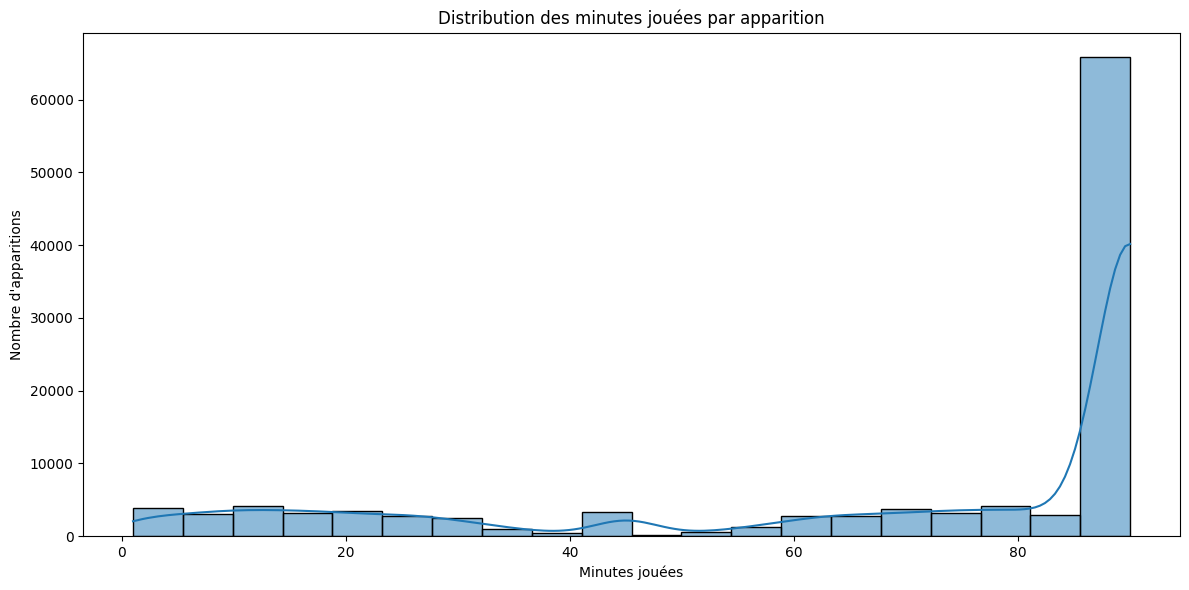

In [ ]:
# 2. ANALYSE DES APPARITIONS
print("\n" + "="*80)
print("2. ANALYSE DES APPARITIONS")
print("="*80)

# Nombre d'apparitions par saison
if 'season' in df_appearance.columns:
    season_counts = df_appearance['season'].value_counts().sort_index()
    print("\nNombre d'apparitions par saison:")
    print(season_counts)

    plt.figure(figsize=(12, 6))
    season_counts.plot(kind='bar', color='skyblue')
    plt.title('Nombre d\'apparitions de joueurs par saison')
    plt.xlabel('Saison')
    plt.ylabel('Nombre d\'apparitions')
    plt.xticks(rotation=45)
    plt.tight_layout()

# Distribution des minutes jouées
plt.figure(figsize=(12, 6))
sns.histplot(df_appearance['minutes_played'], bins=20, kde=True)
plt.title('Distribution des minutes jouées par apparition')
plt.xlabel('Minutes jouées')
plt.ylabel('Nombre d\'apparitions')
plt.tight_layout()


4. ANALYSE PAR JOUEUR
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115182 entries, 0 to 115181
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   appearance_id           115182 non-null  object
 1   game_id                 115182 non-null  int64 
 2   player_id               115182 non-null  int64 
 3   player_club_id          115182 non-null  int64 
 4   player_current_club_id  115182 non-null  int64 
 5   date                    115182 non-null  object
 6   player_name             115182 non-null  object
 7   competition_id          115182 non-null  object
 8   yellow_cards            115182 non-null  int64 
 9   red_cards               115182 non-null  int64 
 10  goals                   115182 non-null  int64 
 11  assists                 115182 non-null  int64 
 12  minutes_played          115182 non-null  int64 
dtypes: int64(9), object(4)
memory usage: 11.4+ MB

Joueurs avec le plu

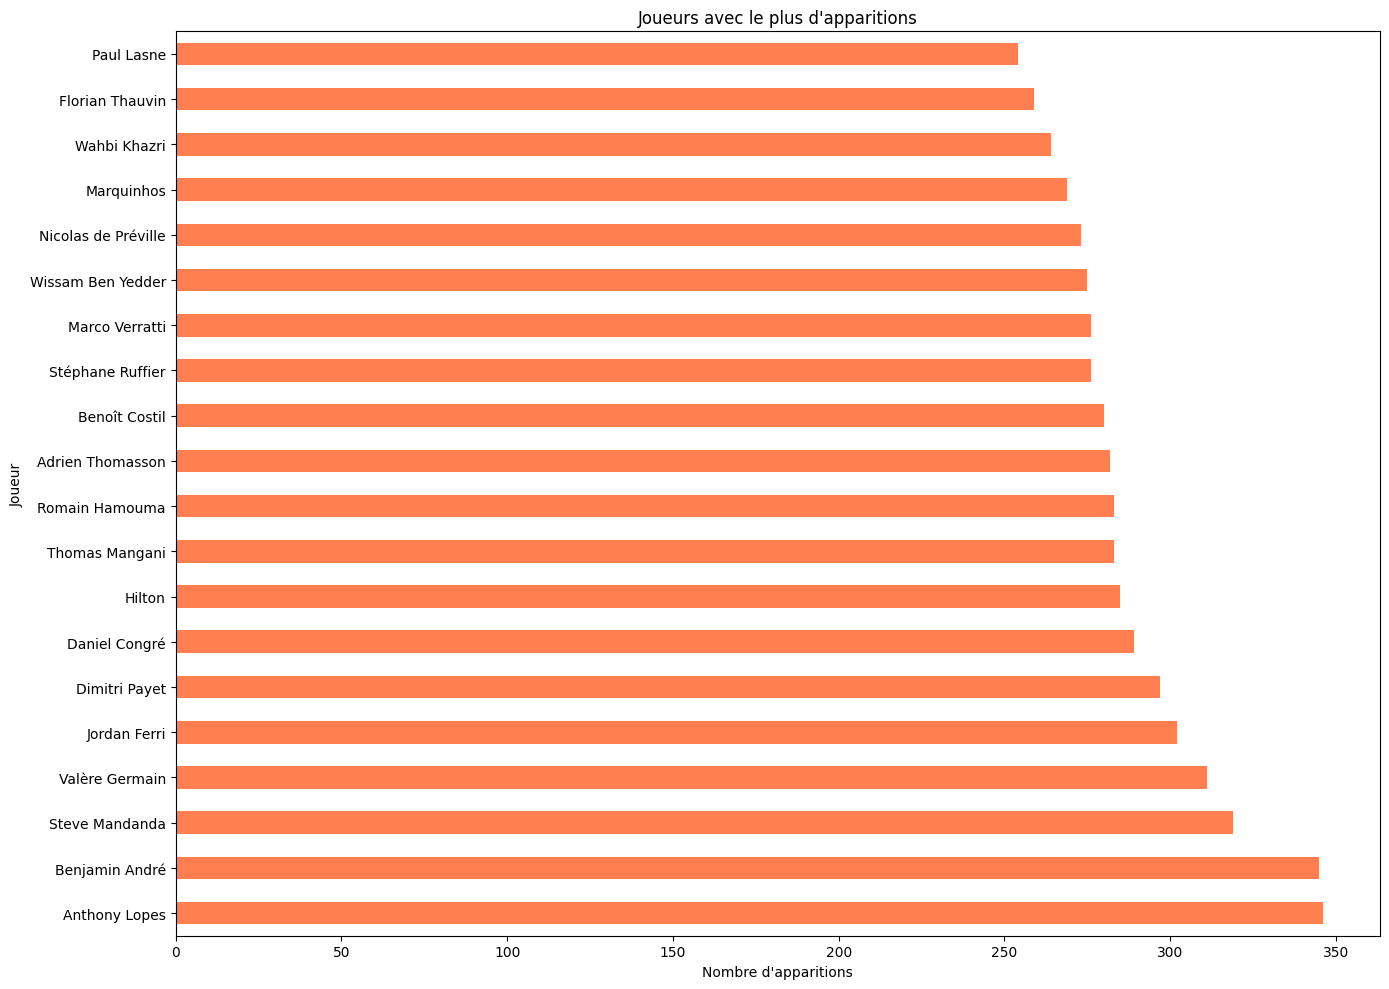

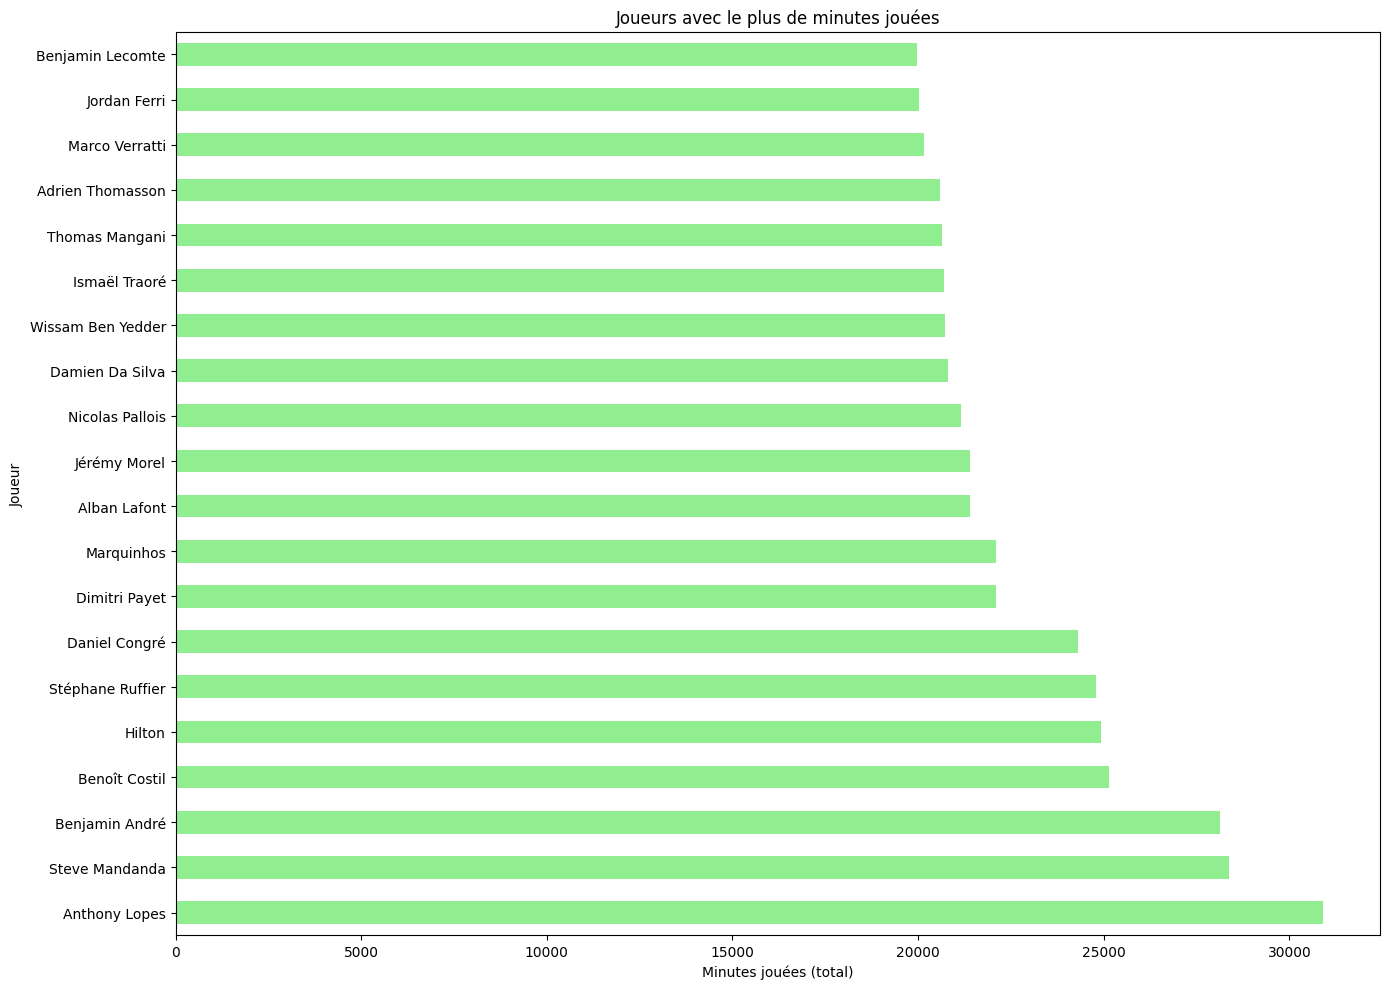

In [ ]:
# 4. ANALYSE PAR JOUEUR
print("\n" + "="*80)
print("4. ANALYSE PAR JOUEUR")
print("="*80)
df_appearance.info()
if 'player_name' in df_appearance.columns:
    # Joueurs avec le plus d'apparitions
    player_counts = df_appearance['player_name'].value_counts().head(20)
    print("\nJoueurs avec le plus d'apparitions:")
    print(player_counts)

    plt.figure(figsize=(14, 10))
    player_counts.plot(kind='barh', color='coral')
    plt.title('Joueurs avec le plus d\'apparitions')
    plt.xlabel('Nombre d\'apparitions')
    plt.ylabel('Joueur')
    plt.tight_layout()

    # Joueurs avec le plus de minutes jouées
    player_minutes = df_appearance.groupby('player_name')['minutes_played'].sum().sort_values(ascending=False).head(20)
    print("\nJoueurs avec le plus de minutes jouées:")
    print(player_minutes)

    plt.figure(figsize=(14, 10))
    player_minutes.plot(kind='barh', color='lightgreen')
    plt.title('Joueurs avec le plus de minutes jouées')
    plt.xlabel('Minutes jouées (total)')
    plt.ylabel('Joueur')
    plt.tight_layout()


6. ANALYSE DES PERFORMANCES

Distribution des buts marqués par apparition:
goals
0    105876
1      8392
2       826
3        80
4         7
5         1
Name: count, dtype: int64

Top buteurs:
player_name
Kylian Mbappé          164
Wissam Ben Yedder      144
Edinson Cavani         138
Alexandre Lacazette    121
Zlatan Ibrahimović     113
Florian Thauvin         86
Andy Delort             85
Neymar                  82
Dimitri Payet           73
Wahbi Khazri            73
Gaëtan Laborde          72
Radamel Falcao          65
Memphis Depay           62
Valère Germain          61
Karl Toko Ekambi        59
Nolan Roux              58
Ángel Di María          57
Moussa Dembélé          56
Jimmy Briand            54
Habib Diallo            53
Name: goals, dtype: int64

Distribution des passes décisives par apparition:
assists
0    107864
1      6871
2       418
3        28
4         1
Name: count, dtype: int64

Top passeurs:
player_name
Dimitri Payet          95
Ángel Di María         76
Kyli

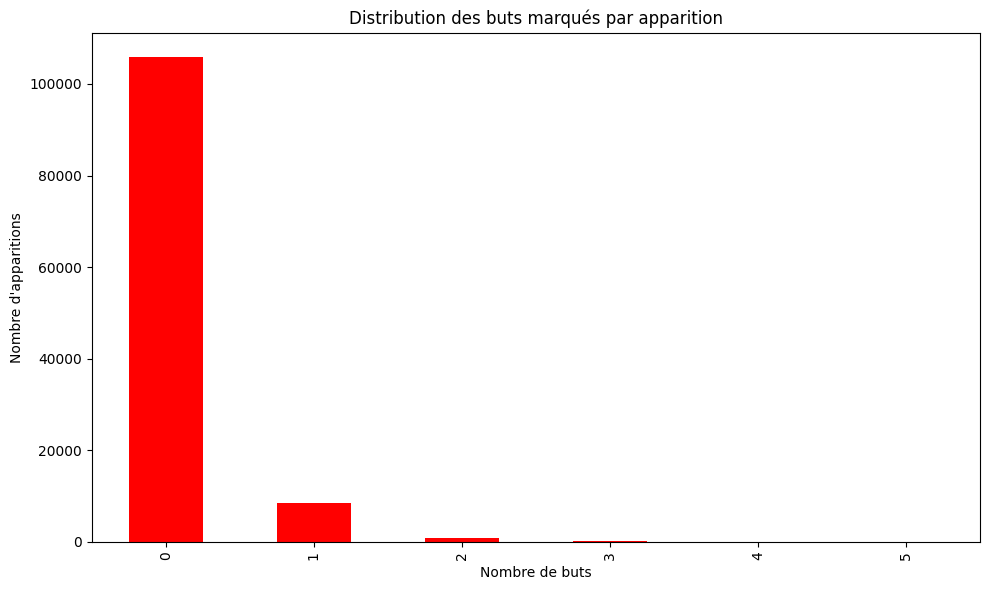

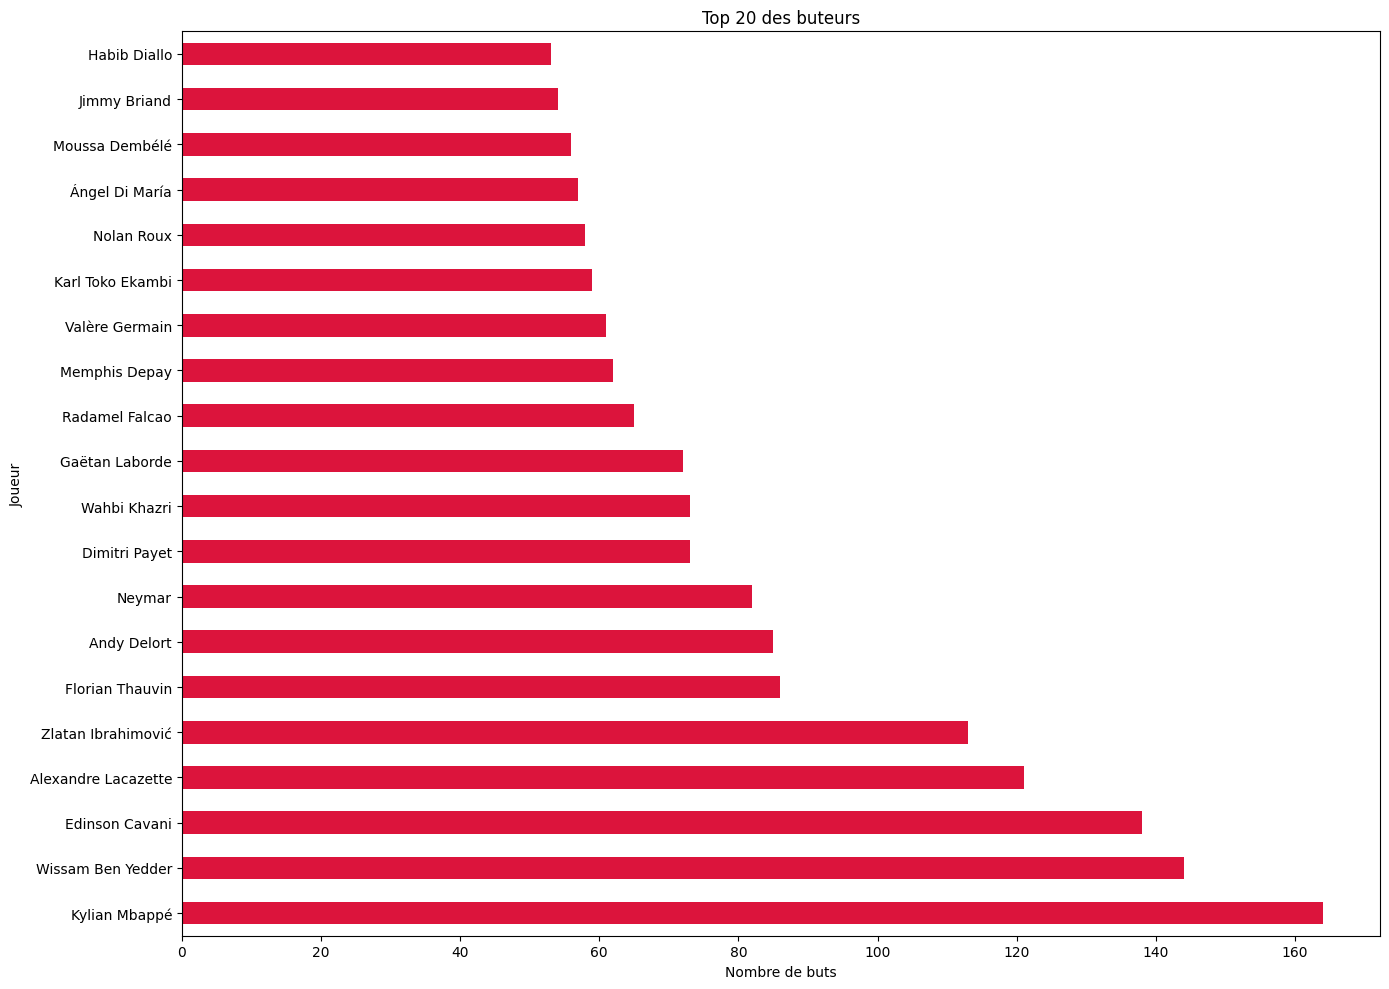

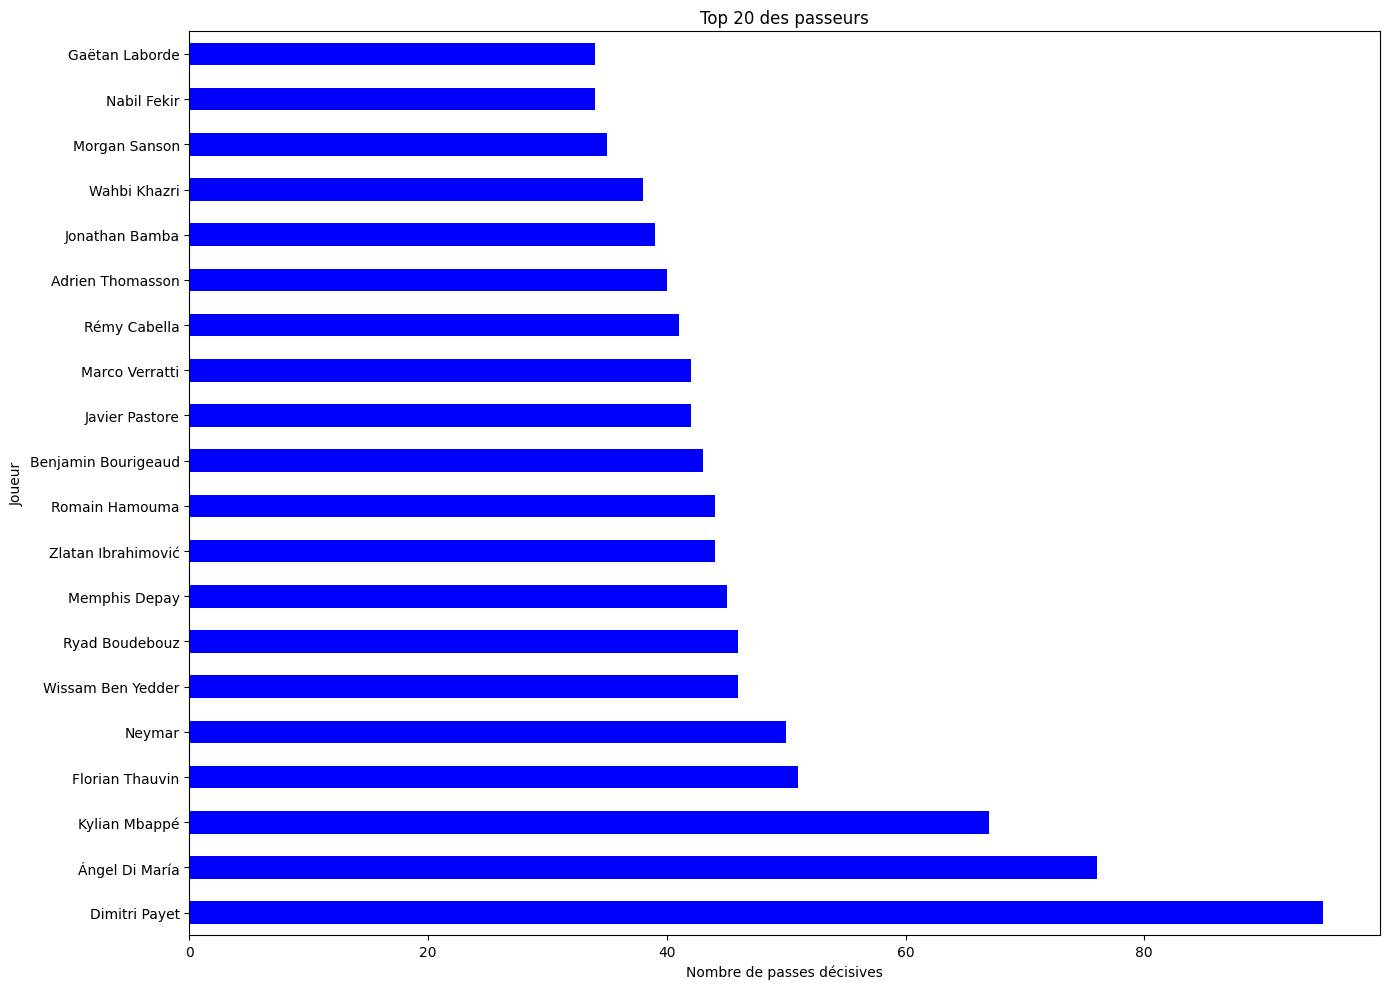

In [ ]:

# 6. ANALYSE DES PERFORMANCES
print("\n" + "="*80)
print("6. ANALYSE DES PERFORMANCES")
print("="*80)

if 'goals' in df_appearance.columns:
    # Distribution des buts
    goals_distribution = df_appearance['goals'].value_counts().sort_index()
    print("\nDistribution des buts marqués par apparition:")
    print(goals_distribution)

    plt.figure(figsize=(10, 6))
    goals_distribution.plot(kind='bar', color='red')
    plt.title('Distribution des buts marqués par apparition')
    plt.xlabel('Nombre de buts')
    plt.ylabel('Nombre d\'apparitions')
    plt.tight_layout()

    # Top buteurs
    players_goals = df_appearance.groupby('player_name')['goals'].sum().sort_values(ascending=False).head(20)
    print("\nTop buteurs:")
    print(players_goals)

    plt.figure(figsize=(14, 10))
    players_goals.plot(kind='barh', color='crimson')
    plt.title('Top 20 des buteurs')
    plt.xlabel('Nombre de buts')
    plt.ylabel('Joueur')
    plt.tight_layout()

if 'assists' in df_appearance.columns:
    # Distribution des passes décisives
    assists_distribution = df_appearance['assists'].value_counts().sort_index()
    print("\nDistribution des passes décisives par apparition:")
    print(assists_distribution)

    # Top passeurs
    players_assists = df_appearance.groupby('player_name')['assists'].sum().sort_values(ascending=False).head(20)
    print("\nTop passeurs:")
    print(players_assists)

    plt.figure(figsize=(14, 10))
    players_assists.plot(kind='barh', color='blue')
    plt.title('Top 20 des passeurs')
    plt.xlabel('Nombre de passes décisives')
    plt.ylabel('Joueur')
    plt.tight_layout()


# **I.6:. Analyse Exploratoire de `game_lineups.csv` `&` `game_events.csv`**

In [ ]:

# -------------------------------------------------------------------------------
# PARTIE 1: EXPLORATION DES DONNÉES
# -------------------------------------------------------------------------------

print("="*80)
print("PARTIE 1: EXPLORATION DES DONNÉES")
print("="*80)

# -------------------------------------------------------------------------------
# 1.1 EXPLORATION DES DONNÉES DE COMPOSITION (df_lineups)
# -------------------------------------------------------------------------------

print("\n" + "="*80)
print("1.1 EXPLORATION DES DONNÉES DE COMPOSITION (df_lineups)")
print("="*80)

# Aperçu de la structure de df_lineups
print("\nInformations sur df_lineups:")
print(df_lineups.info())

# Aperçu des premières lignes
print("\nAperçu des premières lignes de df_lineups:")
print(df_lineups.head())

# Statistiques descriptives
print("\nStatistiques descriptives de df_lineups:")
print(df_lineups.describe(include='all'))

# Distribution des valeurs dans les colonnes catégorielles
print("\nDistribution des joueurs par type (titulaire/remplaçant):")
print(df_lineups['type'].value_counts())

print("\nDistribution des joueurs par position:")
print(df_lineups['position'].value_counts())

print("\nNombre de capitaines:")
print(df_lineups['team_captain'].value_counts())

# Nombre de matchs uniques
print("\nNombre de matchs uniques:", df_lineups['game_id'].nunique())

# Nombre d'équipes uniques
print("\nNombre d'équipes uniques:", df_lineups['club_id'].nunique())

# Nombre de joueurs uniques
print("\nNombre de joueurs uniques:", df_lineups['player_id'].nunique())


PARTIE 1: EXPLORATION DES DONNÉES

1.1 EXPLORATION DES DONNÉES DE COMPOSITION (df_lineups)

Informations sur df_lineups:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137132 entries, 0 to 137131
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Unnamed: 0       137132 non-null  int64 
 1   game_lineups_id  137132 non-null  object
 2   date             137132 non-null  object
 3   game_id          137132 non-null  int64 
 4   player_id        137132 non-null  int64 
 5   club_id          137132 non-null  int64 
 6   player_name      137132 non-null  object
 7   type             137132 non-null  object
 8   position         137132 non-null  object
 9   number           137132 non-null  object
 10  team_captain     137132 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 11.5+ MB
None

Aperçu des premières lignes de df_lineups:
   Unnamed: 0                   game_lineups_id        date  game_id  

In [ ]:
# -------------------------------------------------------------------------------
# 1.2 EXPLORATION DES DONNÉES D'ÉVÉNEMENTS (df_events)
# -------------------------------------------------------------------------------

print("\n" + "="*80)
print("1.2 EXPLORATION DES DONNÉES D'ÉVÉNEMENTS (df_events)")
print("="*80)

# Aperçu de la structure de df_events
print("\nInformations sur df_events:")
print(df_events.info())

# Aperçu des premières lignes
print("\nAperçu des premières lignes de df_events:")
print(df_events.head())

# Statistiques descriptives
print("\nStatistiques descriptives de df_events:")
print(df_events.describe(include='all'))

# Distribution des types d'événements
print("\nDistribution des types d'événements:")
print(df_events['type'].value_counts())

# Analyse des minutes où se produisent les événements
print("\nStatistiques sur les minutes des événements:")
print(df_events['minute'].describe())

# Valeurs manquantes
print("\nValeurs manquantes dans df_events:")
print(df_events.isnull().sum())

# Analyse des descriptions disponibles
print("\nNombre d'événements avec description:", df_events['description'].notna().sum())
print("\nExemples de descriptions:")
print(df_events['description'].dropna().sample(10))

# Analyse des remplacements
print("\nNombre de remplacements:", df_events['player_in_id'].notna().sum())

# Analyse des passes décisives
print("\nNombre de passes décisives:", df_events['player_assist_id'].notna().sum())


1.2 EXPLORATION DES DONNÉES D'ÉVÉNEMENTS (df_events)

Informations sur df_events:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40995 entries, 0 to 40994
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        40995 non-null  int64  
 1   game_event_id     40995 non-null  object 
 2   date              40995 non-null  object 
 3   game_id           40995 non-null  int64  
 4   minute            40995 non-null  int64  
 5   type              40995 non-null  object 
 6   club_id           40995 non-null  int64  
 7   player_id         40995 non-null  int64  
 8   description       19667 non-null  object 
 9   player_in_id      26092 non-null  float64
 10  player_assist_id  2268 non-null   float64
dtypes: float64(2), int64(5), object(4)
memory usage: 3.4+ MB
None

Aperçu des premières lignes de df_events:
   Unnamed: 0                     game_event_id        date  game_id  minute  \
0      

In [ ]:
# -------------------------------------------------------------------------------
# 1.3 ANALYSE CROISÉE DES DATASETS
# -------------------------------------------------------------------------------

print("\n" + "="*80)
print("1.3 ANALYSE CROISÉE DES DATASETS")
print("="*80)

# Matchs communs aux deux datasets
common_games = set(df_lineups['game_id']).intersection(set(df_events['game_id']))
print("\nNombre de matchs communs aux deux datasets:", len(common_games))

# Joueurs communs aux deux datasets
common_players = set(df_lineups['player_id']).intersection(set(df_events['player_id']))
print("\nNombre de joueurs communs aux deux datasets:", len(common_players))

# Dates communes aux deux datasets
df_lineups['date'] = pd.to_datetime(df_lineups['date'])
df_events['date'] = pd.to_datetime(df_events['date'])

date_range_lineups = (df_lineups['date'].min(), df_lineups['date'].max())
date_range_events = (df_events['date'].min(), df_events['date'].max())

print("\nPériode couverte par df_lineups:", date_range_lineups)
print("Période couverte par df_events:", date_range_events)



1.3 ANALYSE CROISÉE DES DATASETS

Nombre de matchs communs aux deux datasets: 3695

Nombre de joueurs communs aux deux datasets: 1829

Période couverte par df_lineups: (Timestamp('2013-08-09 00:00:00'), Timestamp('2023-06-03 00:00:00'))
Période couverte par df_events: (Timestamp('2012-08-10 00:00:00'), Timestamp('2023-06-03 00:00:00'))



PARTIE 2: VISUALISATION DES DONNÉES

2.1 VISUALISATION DES DONNÉES DE COMPOSITION (df_lineups)


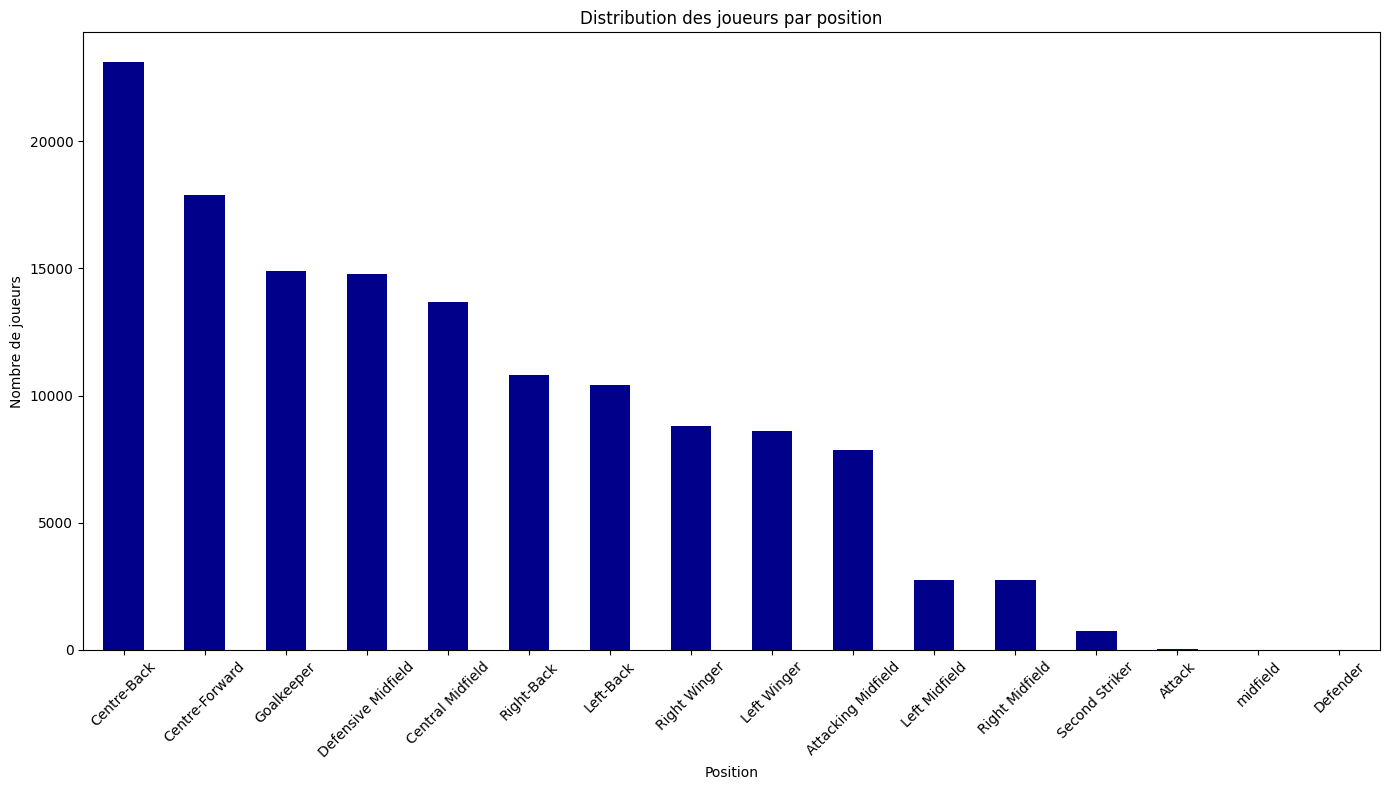

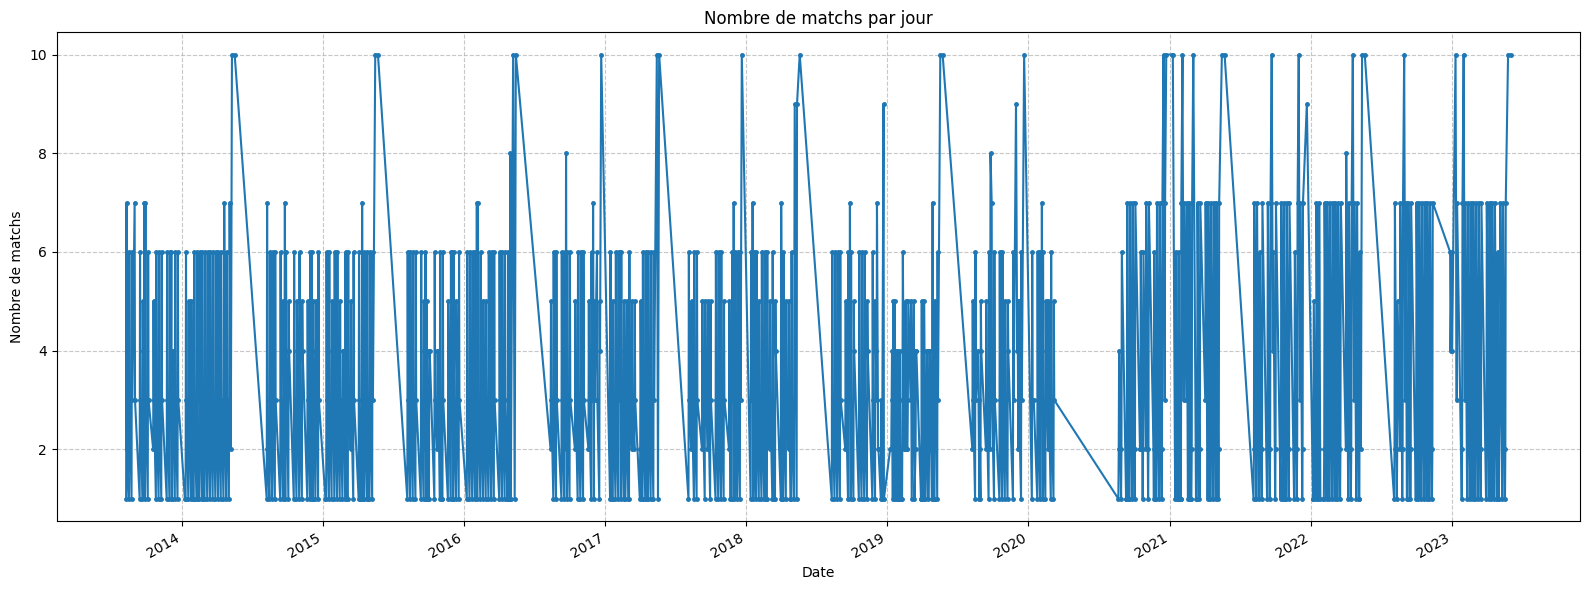

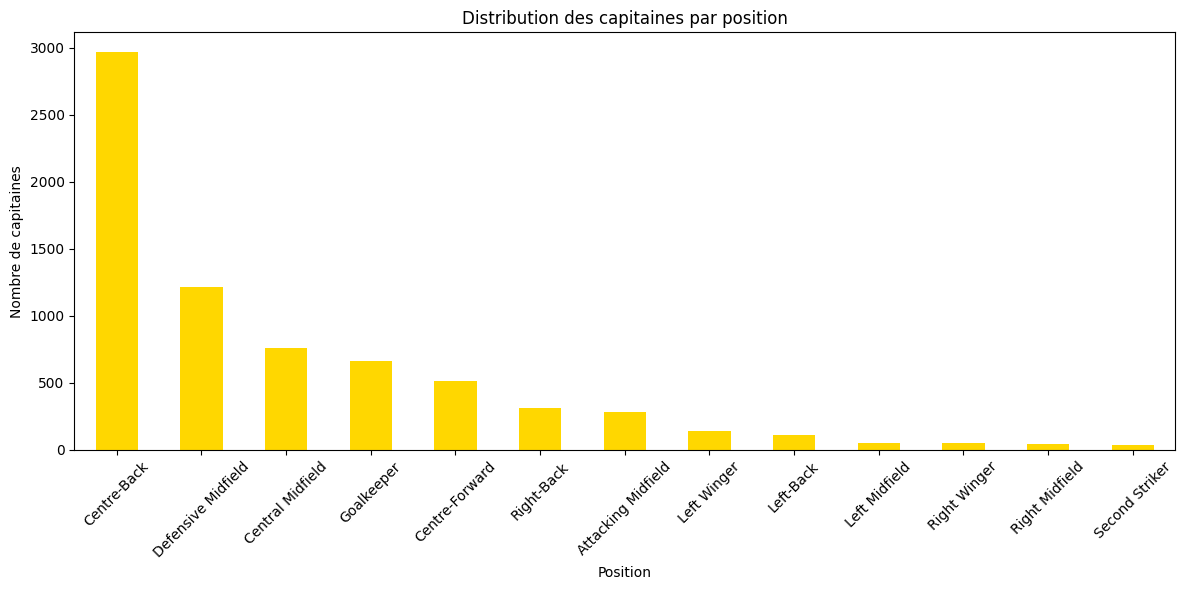

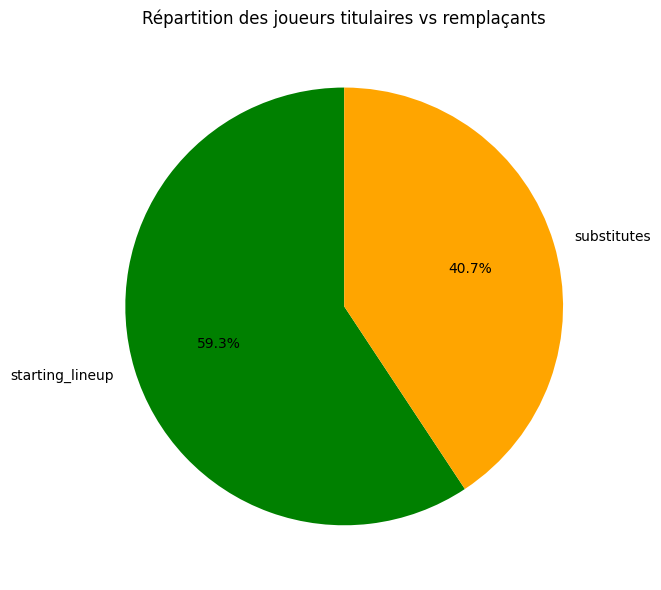

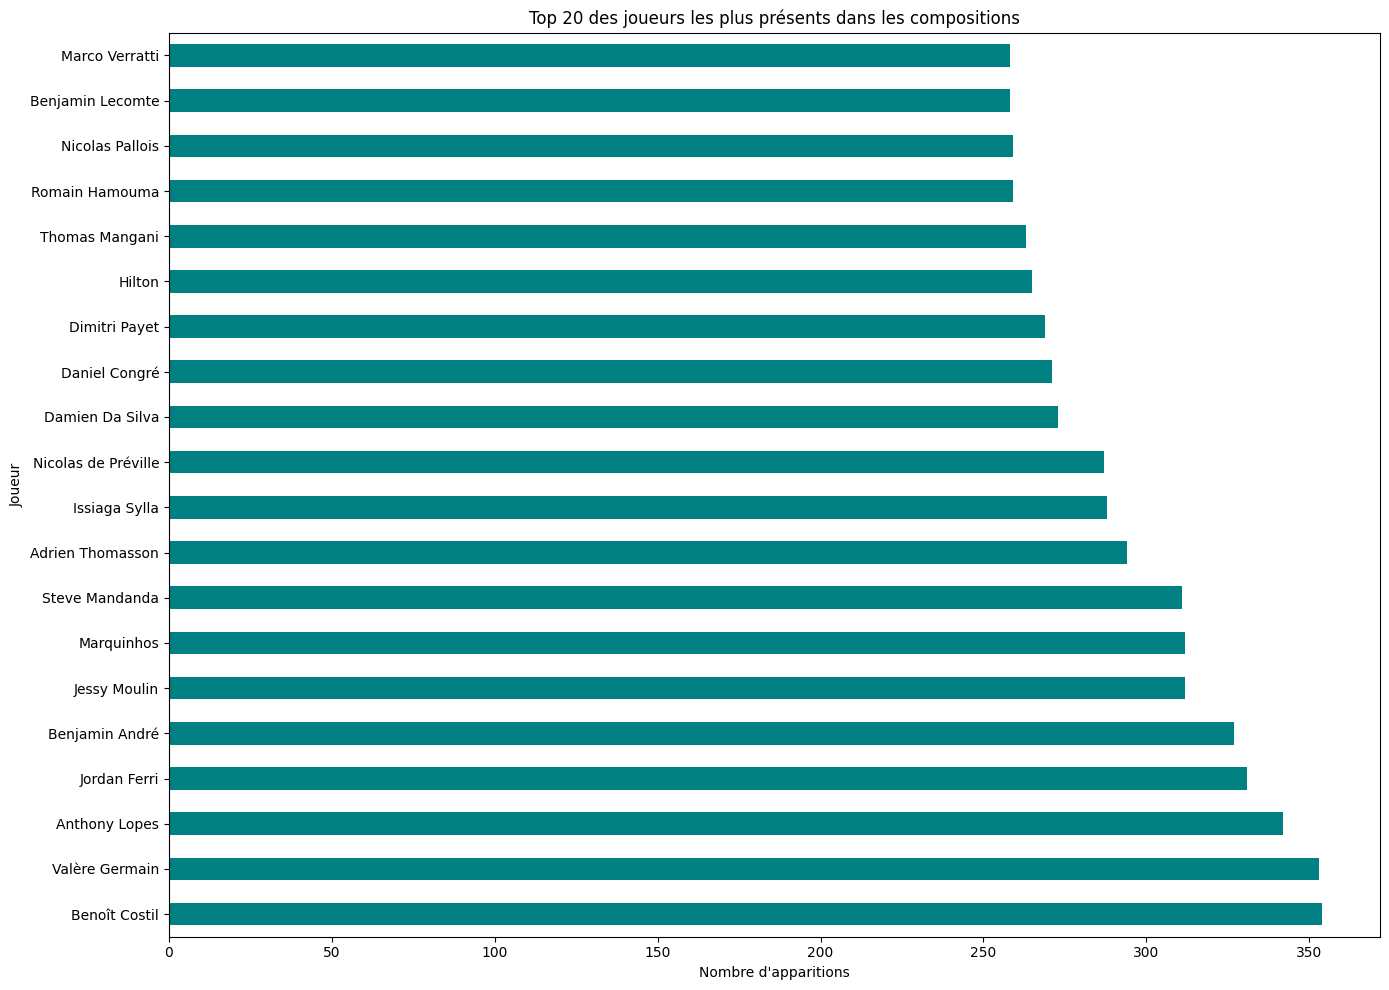

In [ ]:
# -------------------------------------------------------------------------------
# PARTIE 2: VISUALISATION DES DONNÉES
# -------------------------------------------------------------------------------

print("\n" + "="*80)
print("PARTIE 2: VISUALISATION DES DONNÉES")
print("="*80)

# -------------------------------------------------------------------------------
# 2.1 VISUALISATION DES DONNÉES DE COMPOSITION (df_lineups)
# -------------------------------------------------------------------------------

print("\n" + "="*80)
print("2.1 VISUALISATION DES DONNÉES DE COMPOSITION (df_lineups)")
print("="*80)

# Distribution des positions
plt.figure(figsize=(14, 8))
positions_count = df_lineups['position'].value_counts()
positions_count.plot(kind='bar', color='darkblue')
plt.title('Distribution des joueurs par position')
plt.xlabel('Position')
plt.ylabel('Nombre de joueurs')
plt.xticks(rotation=45)
plt.tight_layout()

# Évolution du nombre de matchs par date
plt.figure(figsize=(16, 6))
matches_per_date = df_lineups.groupby('date')['game_id'].nunique()
matches_per_date.plot(kind='line', marker='.', markersize=5)
plt.title('Nombre de matchs par jour')
plt.xlabel('Date')
plt.ylabel('Nombre de matchs')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Distribution des capitaines par position
plt.figure(figsize=(12, 6))
captain_positions = df_lineups[df_lineups['team_captain'] == 1]['position'].value_counts()
captain_positions.plot(kind='bar', color='gold')
plt.title('Distribution des capitaines par position')
plt.xlabel('Position')
plt.ylabel('Nombre de capitaines')
plt.xticks(rotation=45)
plt.tight_layout()

# Nombre de joueurs titulaires vs remplaçants
plt.figure(figsize=(10, 6))
player_types = df_lineups['type'].value_counts()
player_types.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['green', 'orange'])
plt.title('Répartition des joueurs titulaires vs remplaçants')
plt.ylabel('')
plt.tight_layout()

# Top 20 des joueurs les plus présents
top_players = df_lineups['player_name'].value_counts().head(20)
plt.figure(figsize=(14, 10))
top_players.plot(kind='barh', color='teal')
plt.title('Top 20 des joueurs les plus présents dans les compositions')
plt.xlabel('Nombre d\'apparitions')
plt.ylabel('Joueur')
plt.tight_layout()



2.2 VISUALISATION DES DONNÉES D'ÉVÉNEMENTS (df_events)


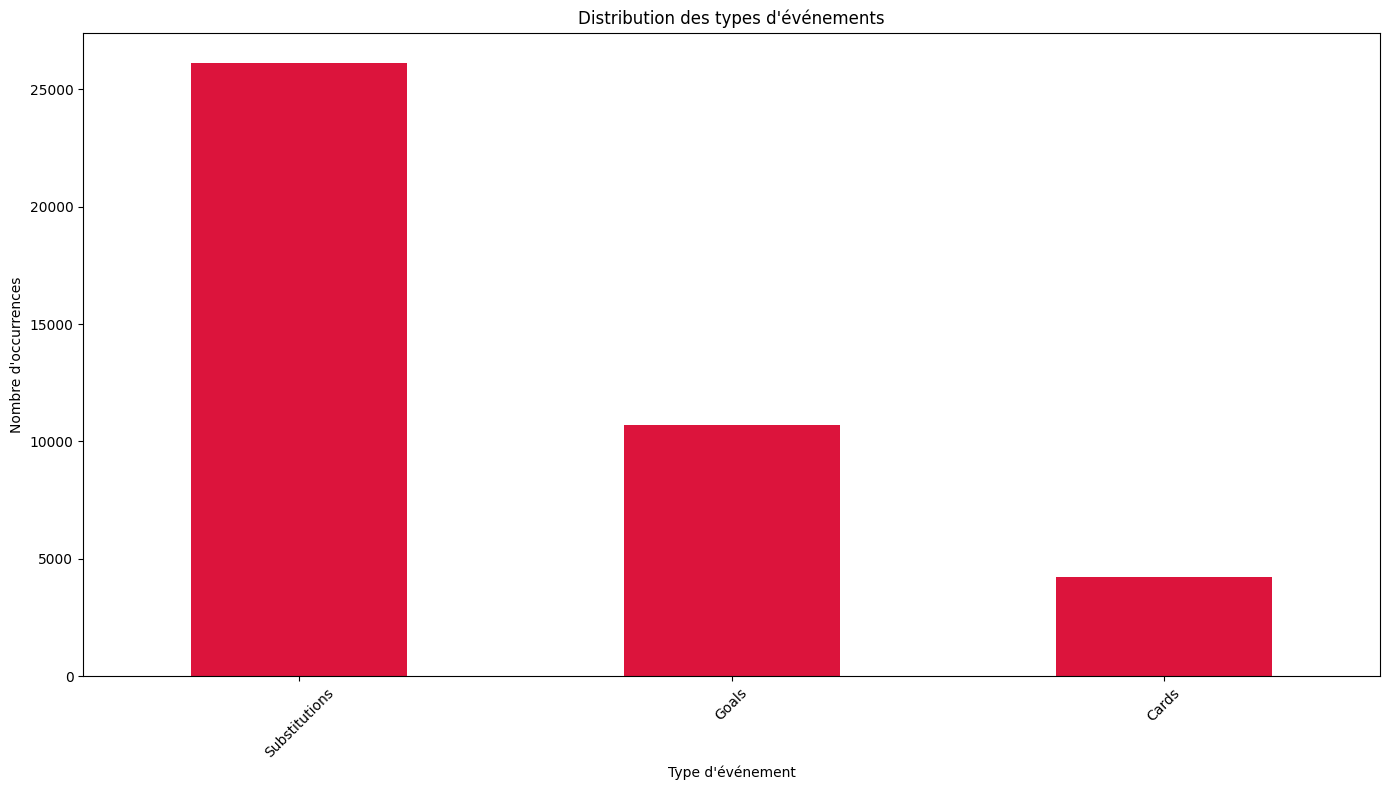

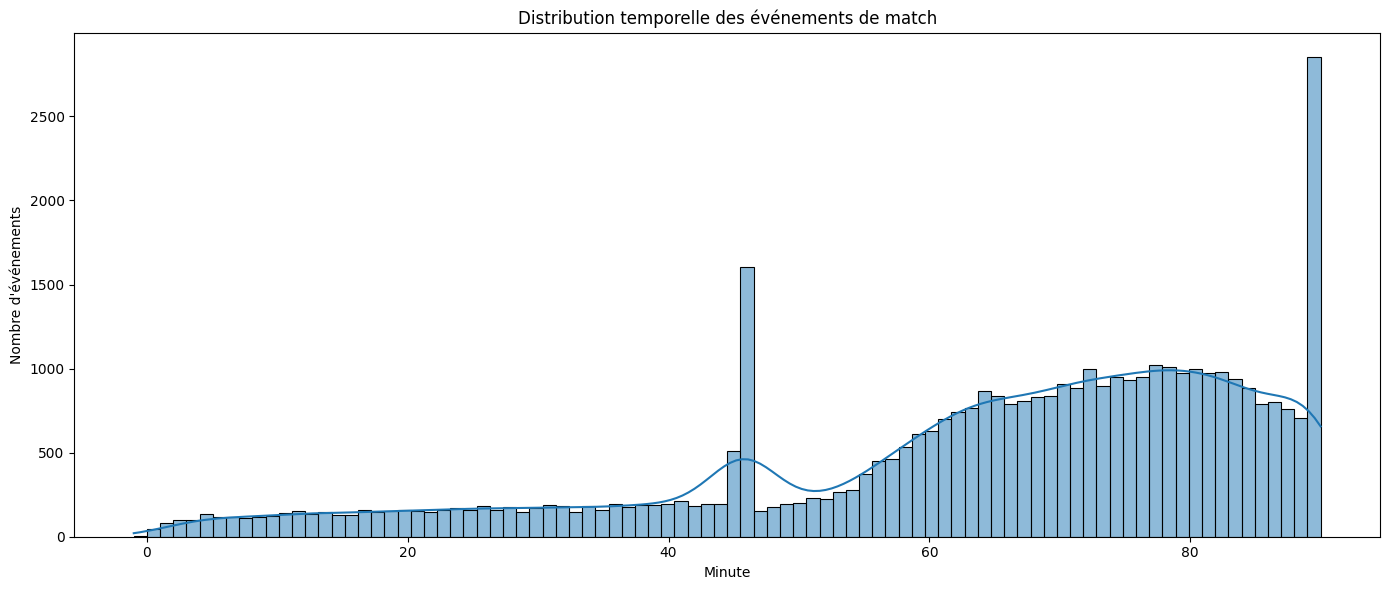

<Figure size 1600x1000 with 0 Axes>

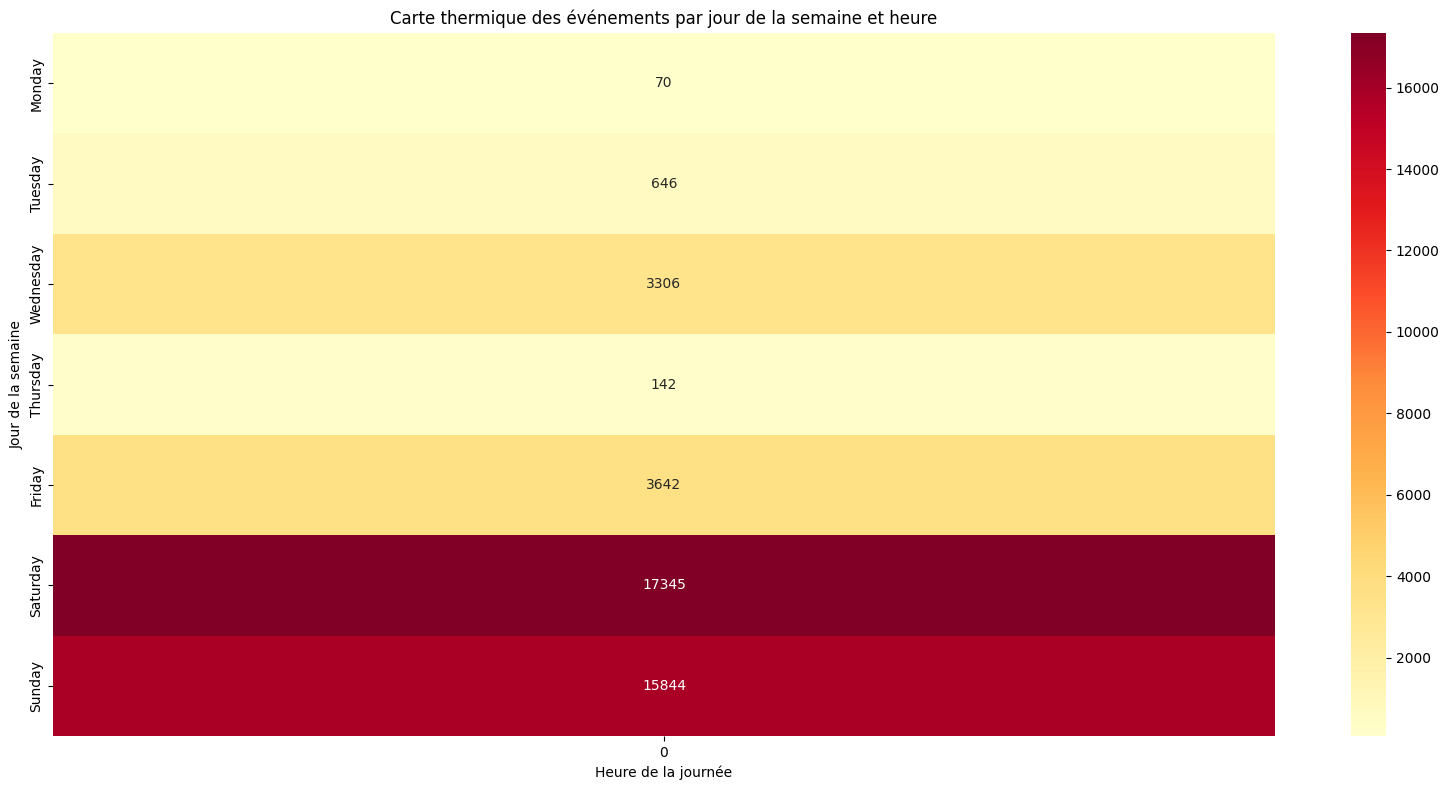

In [ ]:
# -------------------------------------------------------------------------------
# 2.2 VISUALISATION DES DONNÉES D'ÉVÉNEMENTS (df_events)
# -------------------------------------------------------------------------------

print("\n" + "="*80)
print("2.2 VISUALISATION DES DONNÉES D'ÉVÉNEMENTS (df_events)")
print("="*80)

# Distribution des types d'événements
plt.figure(figsize=(14, 8))
event_types = df_events['type'].value_counts()
event_types.plot(kind='bar', color='crimson')
plt.title('Distribution des types d\'événements')
plt.xlabel('Type d\'événement')
plt.ylabel('Nombre d\'occurrences')
plt.xticks(rotation=45)
plt.tight_layout()


# Distribution temporelle des événements
plt.figure(figsize=(14, 6))
sns.histplot(df_events['minute'], bins=90, kde=True)
plt.title('Distribution temporelle des événements de match')
plt.xlabel('Minute')
plt.ylabel('Nombre d\'événements')
plt.tight_layout()


# Distribution temporelle par type d'événement
plt.figure(figsize=(16, 10))
main_events = ['Goal', 'Substitution', 'Yellow Card', 'Red Card']
event_data = df_events[df_events['type'].isin(main_events)]

if not event_data.empty:
    sns.histplot(data=event_data, x='minute', hue='type', bins=90, element='step', common_norm=False)
    plt.title('Distribution temporelle par type d\'événement')
    plt.xlabel('Minute')
    plt.ylabel('Nombre d\'événements')
    plt.tight_layout()


# Carte thermique des événements par jour de la semaine et heure
df_events['dow'] = df_events['date'].dt.day_name()
df_events['hour'] = pd.to_datetime(df_events['date']).dt.hour

dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

events_by_time = pd.crosstab(df_events['dow'], df_events['hour'])
events_by_time = events_by_time.reindex(dow_order)

plt.figure(figsize=(16, 8))
sns.heatmap(events_by_time, cmap='YlOrRd', annot=True, fmt='d')
plt.title('Carte thermique des événements par jour de la semaine et heure')
plt.xlabel('Heure de la journée')
plt.ylabel('Jour de la semaine')
plt.tight_layout()

# Top 20 des buteurs
if 'Goal' in df_events['type'].values:
    goal_scorers = df_events[df_events['type'] == 'Goal']['player_id'].value_counts().head(20)

    # Récupérer les noms des joueurs depuis df_lineups
    player_names = df_lineups[['player_id', 'player_name']].drop_duplicates().set_index('player_id')
    goal_scorers_named = pd.Series(index=[player_names.loc[pid, 'player_name'] if pid in player_names.index else f"Joueur {pid}"
                                         for pid in goal_scorers.index], data=goal_scorers.values)

    plt.figure(figsize=(14, 10))
    goal_scorers_named.plot(kind='barh', color='forestgreen')
    plt.title('Top 20 des buteurs')
    plt.xlabel('Nombre de buts')
    plt.ylabel('Joueur')
    plt.tight_layout()



In [ ]:
df_events.info()
df_lineups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40995 entries, 0 to 40994
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Unnamed: 0        40995 non-null  int64         
 1   game_event_id     40995 non-null  object        
 2   date              40995 non-null  datetime64[ns]
 3   game_id           40995 non-null  int64         
 4   minute            40995 non-null  int64         
 5   type              40995 non-null  object        
 6   club_id           40995 non-null  int64         
 7   player_id         40995 non-null  int64         
 8   description       19667 non-null  object        
 9   player_in_id      26092 non-null  float64       
 10  player_assist_id  2268 non-null   float64       
 11  dow               40995 non-null  object        
 12  hour              40995 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(5), object(4)
memory usage

## **II- Extraction des caractéristiques (Feature Engineering)**

Dans cette partie, on se focalise sur l’extraction des caractéristiques utiles et pertinentes, identifiées après l’exploration de chaque dataset.
L’objectif est de construire un petit data warehouse destiné à l’entraînement du modèle.

👉 Le script **ETL_Script.ipynb** illustre tout le processus :

Extraction,

Transformation,

et Chargement (ETL) des données.

Nous allons maintenant explorer ce dataset final **`finalDataWarehouse.csv`** afin de l’adapter à l'application du modèle.

## 🚀 ETL Process Architecture

Voici une vue d'ensemble du processus ETL mis en place :

- 📁 **Data Fetching** depuis plusieurs fichiers Excel.
- 📊 **Exploration** des données avec Seaborn.
- 🧹 **Extraction** des colonnes pertinentes avec Python.
- 🔗 **Fusion** des données par identifiants communs.
- 💾 **Chargement** final dans `finalDataWarehouse.csv`.

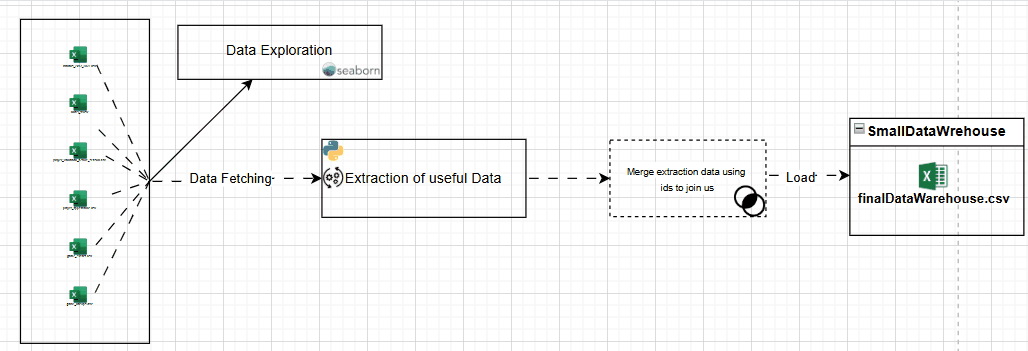


## **III- Exploration du dataset final  `finalDataWarehouse.csv`**
🧹 **1. Statistiques descriptives**  
Vue d'ensemble des matches et des résultats.

**📈 2. Analyse des corrélations**  
Matrices de corrélations et relations avec la variable cible.

🔗 **3. Préparation des données**  
Nettoyage, transformation et enrichissement du data warehouse.


## III-1. STATISTIQUES DESCRIPTIVES

In [ ]:
df = pd.read_csv(base_path + "finalDataWarehouse.csv")
# 1. STATISTIQUES DESCRIPTIVES
# ----------------------------

def print_descriptive_stats():
    """Affiche les statistiques descriptives principales"""
    print("STATISTIQUES DESCRIPTIVES DU DATAWAREHOUSE")
    print("=" * 50)

    # Statistiques globales
    print(f"Nombre total de matchs: {len(df)}")
    print(f"Nombre de saisons: {df['season'].nunique()}")

    # Statistiques des résultats
    result_counts = df['results'].value_counts()
    print("\nDistribution des résultats:")
    for result, count in result_counts.items():
        print(f"  {result}: {count} matchs ({count/len(df)*100:.1f}%)")

    # Statistiques des buts
    print(f"\nMoyenne des buts par match: {df['total_goals'].mean():.2f}")
    print(f"Moyenne des buts à domicile: {df['home_club_goals'].mean():.2f}")
    print(f"Moyenne des buts à l'extérieur: {df['away_club_goals'].mean():.2f}")

    # Top équipes à domicile
    top_home = df.groupby('home_club_name')['home_club_goals'].agg(['count', 'mean']).sort_values('mean', ascending=False)
    print("\nTop 5 équipes les plus prolifiques à domicile:")
    print(top_home.head(5))

    # Performance variable cible par saison
    seasonal_results = df.groupby(['season', 'results']).size().unstack().fillna(0)
    seasonal_results = seasonal_results.div(seasonal_results.sum(axis=1), axis=0) * 100
    print("\nÉvolution des résultats par saison (%):")
    print(seasonal_results.round(1))
print_descriptive_stats()

STATISTIQUES DESCRIPTIVES DU DATAWAREHOUSE
Nombre total de matchs: 4078
Nombre de saisons: 12

Distribution des résultats:
  1: 1802 matchs (44.2%)
  -1: 1203 matchs (29.5%)
  0: 1073 matchs (26.3%)

Moyenne des buts par match: 2.62
Moyenne des buts à domicile: 1.48
Moyenne des buts à l'extérieur: 1.14

Top 5 équipes les plus prolifiques à domicile:
                                              count      mean
home_club_name                                               
Paris Saint-Germain Football Club               204  2.710784
Olympique Lyonnais                              203  1.990148
Association sportive de Monaco Football Club    185  1.951351
Olympique de Marseille                          204  1.720588
Racing Club de Lens                              76  1.552632

Évolution des résultats par saison (%):
results    -1     0     1
season                   
2012     25.3  29.5  45.3
2013     27.2  28.2  44.6
2014     28.9  25.3  45.8
2015     29.4  27.8  42.8
2016     25.9  25

## III-2. ANALYSE DES CORRÉLATIONS




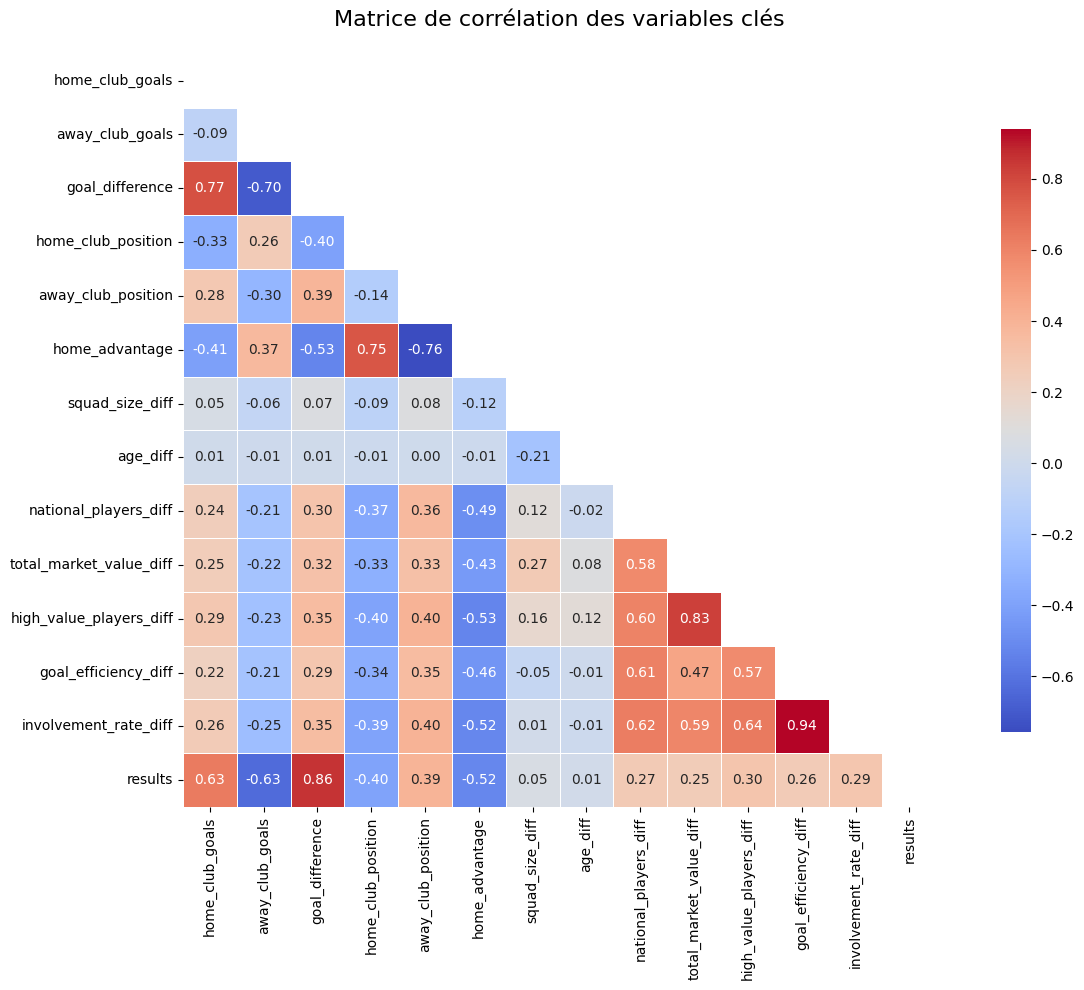


Variables les plus corrélées avec results:
results                    1.000000
goal_difference            0.855620
home_club_goals            0.631402
away_club_position         0.392833
high_value_players_diff    0.297909
involvement_rate_diff      0.294428
national_players_diff      0.267065
goal_efficiency_diff       0.257956
total_market_value_diff    0.254649
squad_size_diff            0.054359
age_diff                   0.014313
home_club_position        -0.395606
home_advantage            -0.522036
away_club_goals           -0.632213
Name: results, dtype: float64


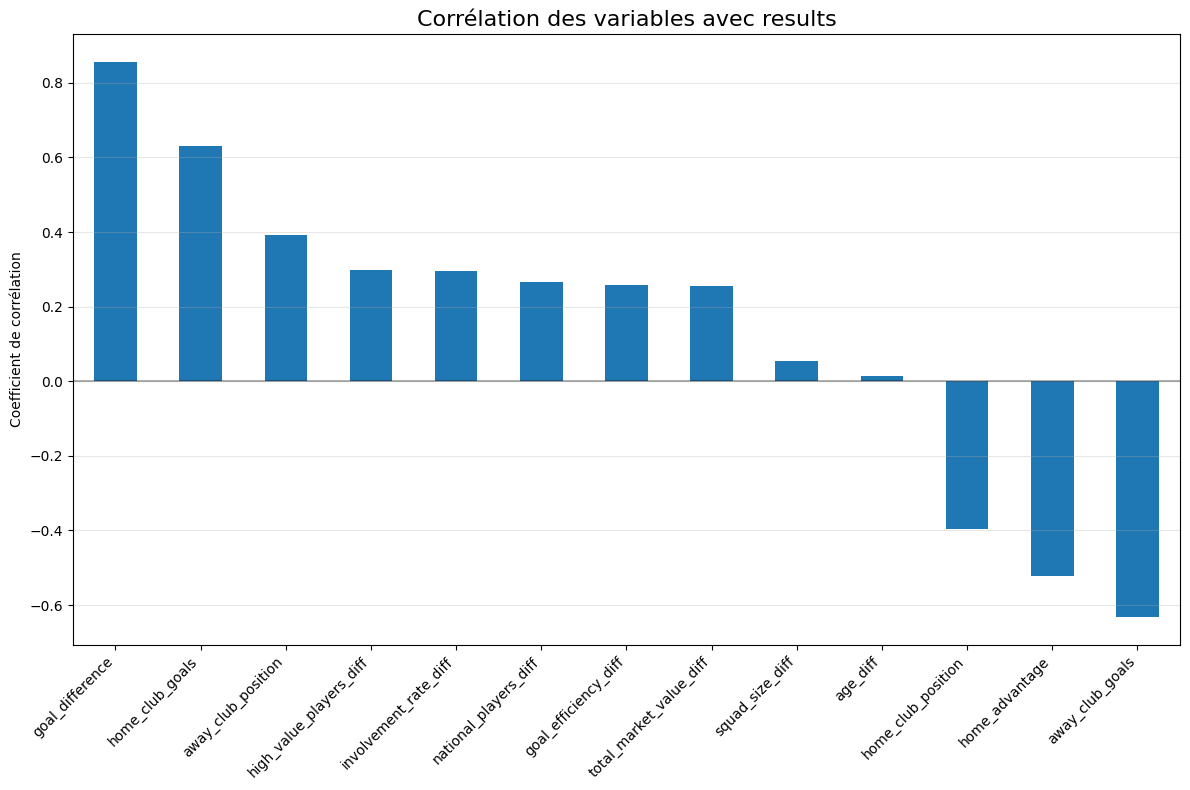

In [ ]:
# 2. ANALYSE DES CORRÉLATIONS
# ---------------------------

def plot_correlation_matrix(target_var='results'):
    """
    Affiche la matrice de corrélation pour les variables numériques sélectionnées
    et montre les variables les plus corrélées avec la variable cible.
    """
    # Sélection des variables importantes pour la matrice de corrélation
    key_vars = [
        'home_club_goals', 'away_club_goals', 'goal_difference',
        'home_club_position', 'away_club_position', 'home_advantage',
        'squad_size_diff', 'age_diff', 'national_players_diff',
        'total_market_value_diff', 'high_value_players_diff',
        'goal_efficiency_diff', 'involvement_rate_diff', target_var
    ]

    # Vérifier si toutes les colonnes existent dans le dataset
    missing_vars = [var for var in key_vars if var not in df.columns]
    if missing_vars:
        print(f"Attention : Les variables suivantes sont absentes : {missing_vars}")
        key_vars = [var for var in key_vars if var in df.columns]

    # Calcul de la matrice de corrélation
    corr_matrix = df[key_vars].corr()

    # Création du heatmap
    plt.figure(figsize=(14, 10))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
                square=True, linewidths=0.5, cbar_kws={"shrink": .8})
    plt.title('Matrice de corrélation des variables clés', fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()

    # Corrélations avec la variable cible
    target_corr = corr_matrix[target_var].sort_values(ascending=False)
    print(f"\nVariables les plus corrélées avec {target_var}:")
    print(target_corr)

    # Visualisation des corrélations avec la variable cible
    plt.figure(figsize=(12, 8))
    target_corr = target_corr.drop(target_var)  # Supprimer la corrélation avec elle-même
    target_corr.plot(kind='bar')
    plt.title(f'Corrélation des variables avec {target_var}', fontsize=16)
    plt.grid(axis='y', alpha=0.3)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.ylabel('Coefficient de corrélation')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Exécuter l'analyse
plot_correlation_matrix()

## III-3. Préparation des données





In [ ]:
df_to_clean=df.copy()
# Supprimer la colonne 'date'
df_to_clean.drop(columns=['date'], inplace=True)
print(df_to_clean.isna().sum())
print(df_to_clean.isnull().sum())
print(df_to_clean.duplicated().sum())
print("\n" + "="*80)
print("Aucune valeur nulle,nan ou dupliquer à traiter")
print("="*80)

game_id                       0
season                        0
home_club_id                  0
away_club_id                  0
home_club_name                0
away_club_name                0
home_club_goals               0
away_club_goals               0
goal_difference               0
total_goals                   0
home_advantage                0
month                         0
day_of_week                   0
home_club_position            0
away_club_position            0
results                       0
home_squad_size               0
home_average_age              0
home_national_team_players    0
home_stadium_seats            0
home_net_transfer_value       0
away_squad_size               0
away_average_age              0
away_national_team_players    0
away_stadium_seats            0
away_net_transfer_value       0
squad_size_diff               0
age_diff                      0
national_players_diff         0
transfer_value_diff           0
home_team_encoded             0
away_tea

In [ ]:
# Supprimer les colonnes inutiles
columns_to_drop = ['home_club_id', 'away_club_id', 'home_club_name', 'away_club_name']
df_to_clean= df_to_clean.drop(columns=columns_to_drop)
df_to_clean= df_to_clean.drop(columns='game_id')
df_to_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4078 entries, 0 to 4077
Data columns (total 39 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   season                      4078 non-null   int64  
 1   home_club_goals             4078 non-null   int64  
 2   away_club_goals             4078 non-null   int64  
 3   goal_difference             4078 non-null   int64  
 4   total_goals                 4078 non-null   int64  
 5   home_advantage              4078 non-null   float64
 6   month                       4078 non-null   int64  
 7   day_of_week                 4078 non-null   int64  
 8   home_club_position          4078 non-null   float64
 9   away_club_position          4078 non-null   float64
 10  results                     4078 non-null   int64  
 11  home_squad_size             4078 non-null   int64  
 12  home_average_age            4078 non-null   float64
 13  home_national_team_players  4078 

In [ ]:

numerical_cols = df_to_clean.select_dtypes(include=['number']).columns.tolist()
if 'results' in numerical_cols:
    numerical_cols.remove('results')  # Supprimer 'results' de la liste

# Appliquer la standardisation uniquement aux variables explicatives
scaler = StandardScaler()
df_to_clean[numerical_cols] = scaler.fit_transform(df_to_clean[numerical_cols])

# Vérifier que 'results' contient bien les valeurs originales
print(df_to_clean['results'].unique())

# Outlier Detection and Treatment (using IQR method)
def treat_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.clip(df[column], lower_bound, upper_bound)
    return df

for col in numerical_cols:
    df_to_clean = treat_outliers_iqr(df_to_clean, col)


[ 0 -1  1]


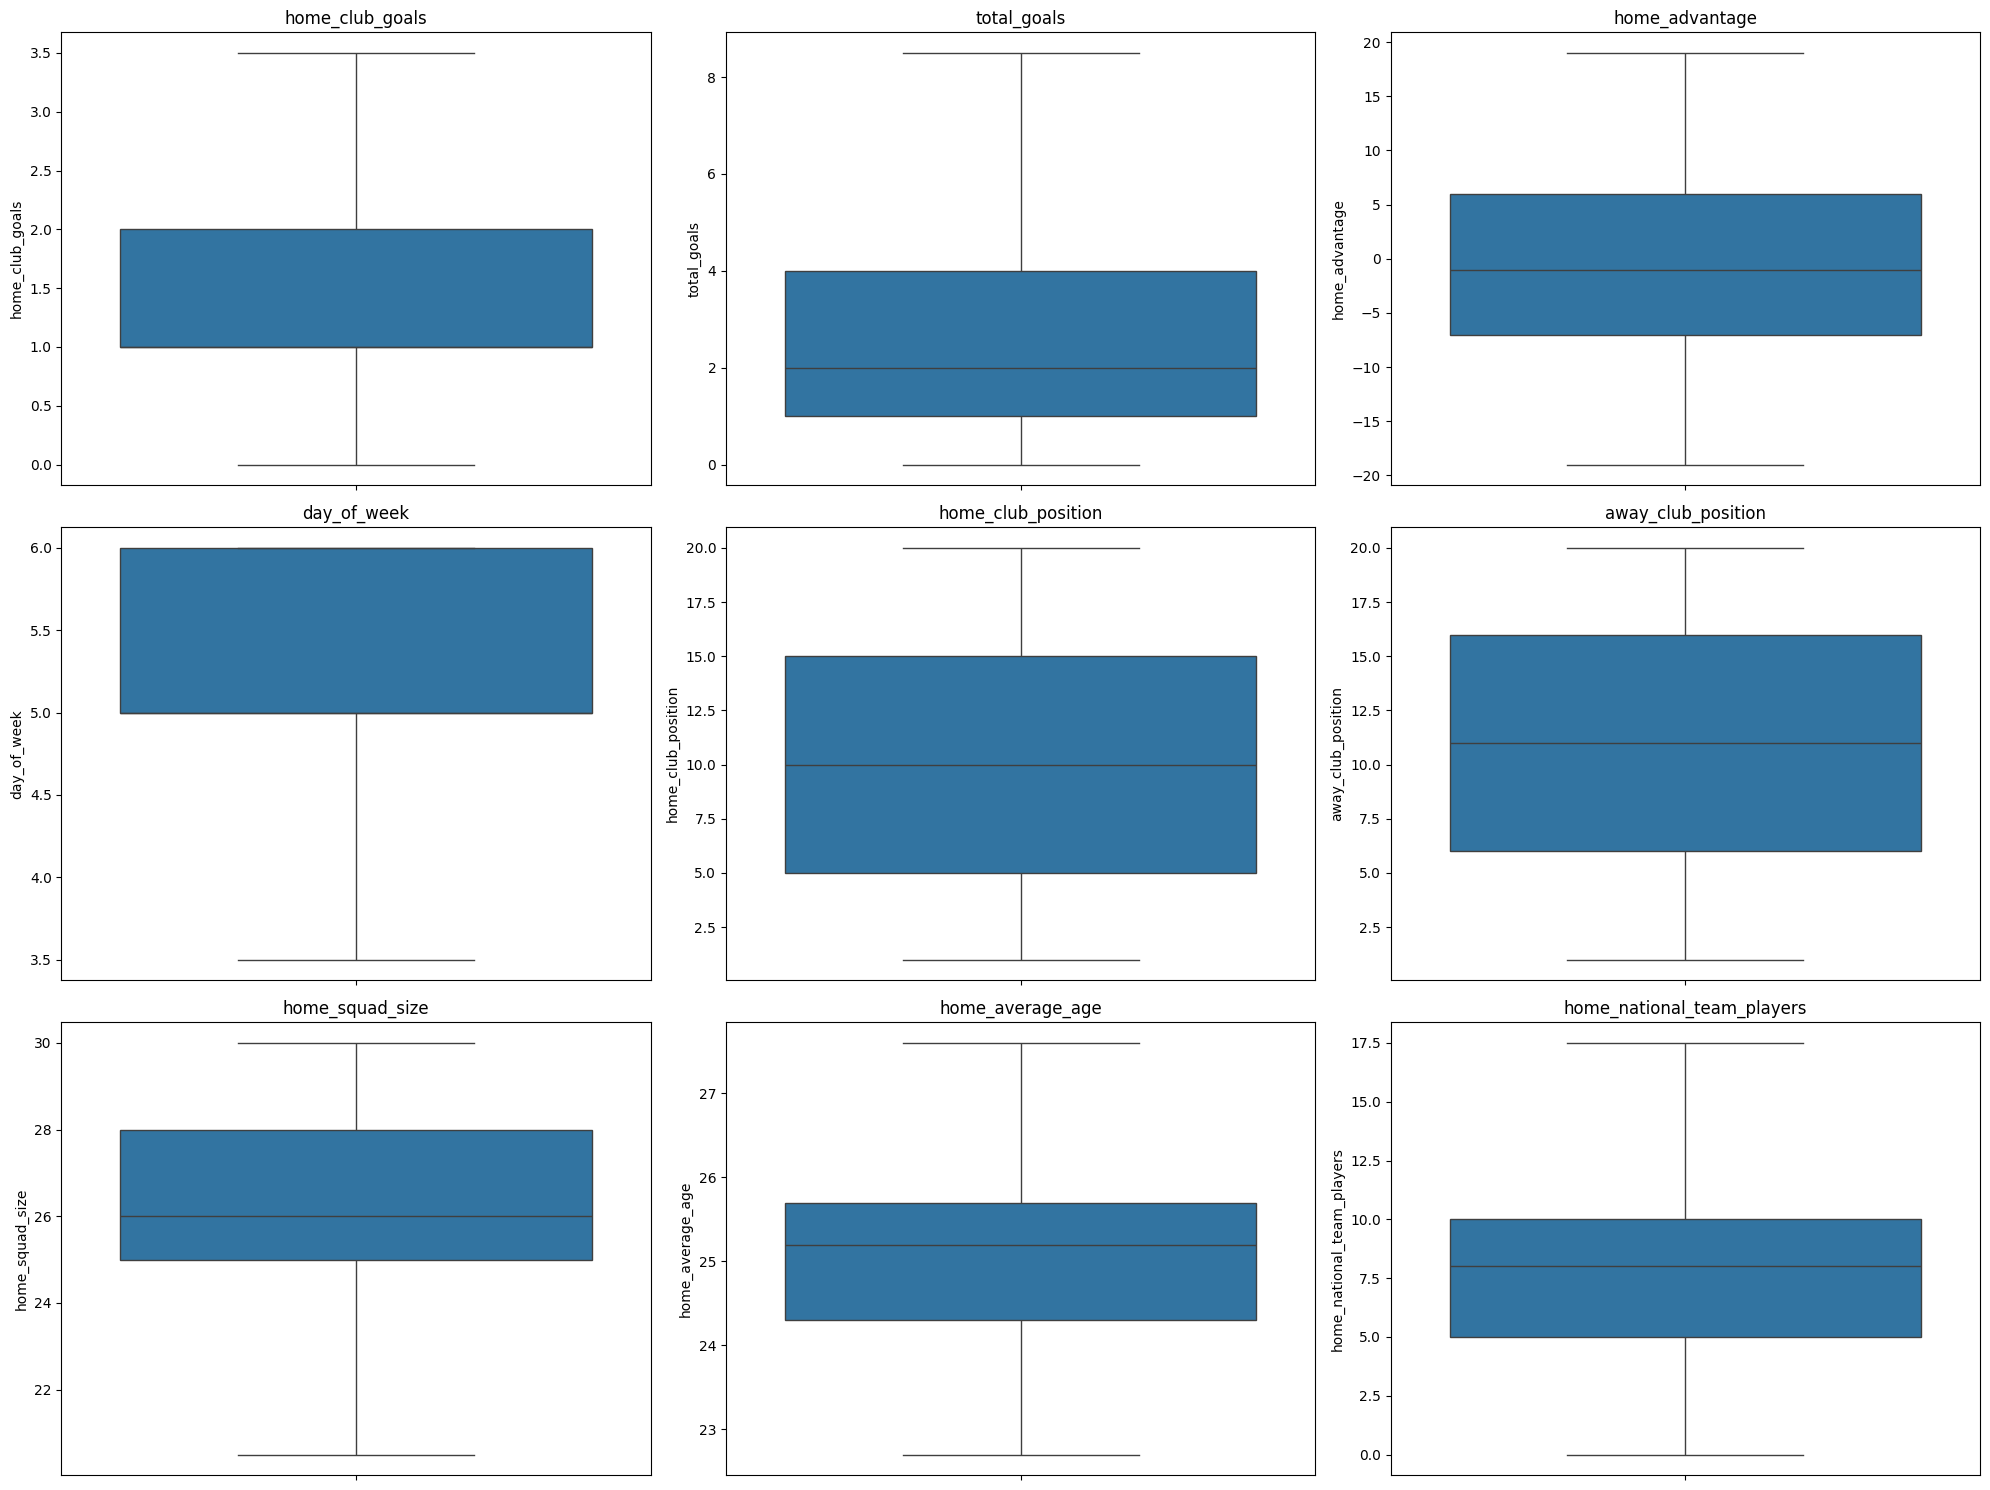

In [ ]:
# Boxplots pour visualiser les outliers
plt.figure(figsize=(20, 15))
for i, col in enumerate(df_to_clean.select_dtypes(include=['float64']).columns[:9]):
    plt.subplot(3, 3, i+1)
    sns.boxplot(y=df_to_clean[col])

    plt.title(col)
plt.tight_layout()
plt.show()

results
 1    44.188328
-1    29.499755
 0    26.311918
Name: proportion, dtype: float64


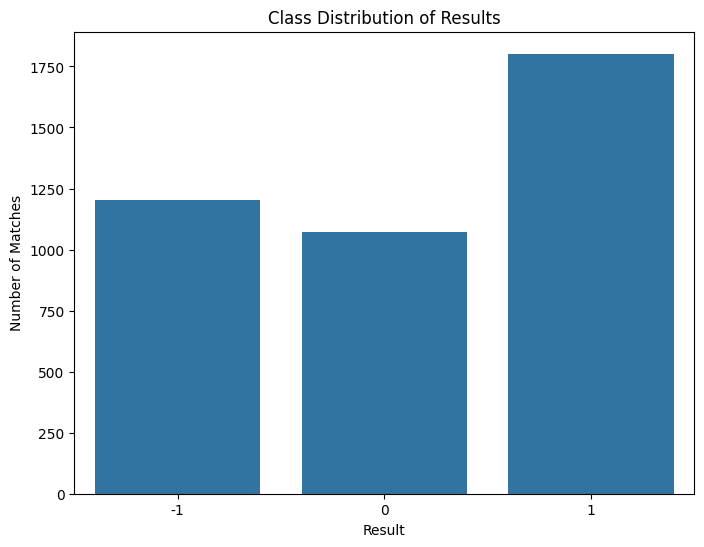

In [ ]:
# prompt: Check for class balance in the target column results

# Check class balance in the 'results' column
result_counts = df_to_clean['results'].value_counts(normalize=True) * 100
print(result_counts)

# Visualize class balance
plt.figure(figsize=(8, 6))
sns.countplot(x='results', data=df_to_clean)
plt.title('Class Distribution of Results')
plt.xlabel('Result')
plt.ylabel('Number of Matches')
plt.show()


## **IV- Développement du Modèle**

### 🧹 1. Séparation du jeu de données  
Division du jeu de données en ensembles d'entraînement, de validation et de test pour évaluer efficacement les performances du modèle.

### 📈 2. Tests statistiques  
Application de tests statistiques pour évaluer la signification des caractéristiques et leurs relations avec la variable cible.

### 🤖 4.  (ACP) & Entraînement du modèle  
-Réduction de la dimensionnalité pour identifier les caractéristiques les plus influentes et atténuer la multicolinéarité.

-Entraînement du modèle d'apprentissage automatique en utilisant le jeu de données préparé pour prédire la variable cible.
### 🛠️ 4. Optimisation du modèle (Random Forest optimisé)  
- Utilisation de `RandomizedSearchCV` pour identifier les meilleurs hyperparamètres du modèle Random Forest.  
- Comparaison des performances entre le modèle de base et le modèle optimisé pour valider l'amélioration.  
- Sauvegarde du modèle optimisé pour une utilisation future.

## IV-1. Séparation du jeu de données





In [ ]:
# Séparation des données
X = df_to_clean.drop('results', axis=1)
y = df_to_clean['results']

# Division train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(y.dtype)  # Devrait être un type entier (int64, int32, etc.)
print(y.unique())  # Devrait afficher seulement quelques valeurs discrètes

int64
[ 0 -1  1]


##IV-2. Tests statistiques

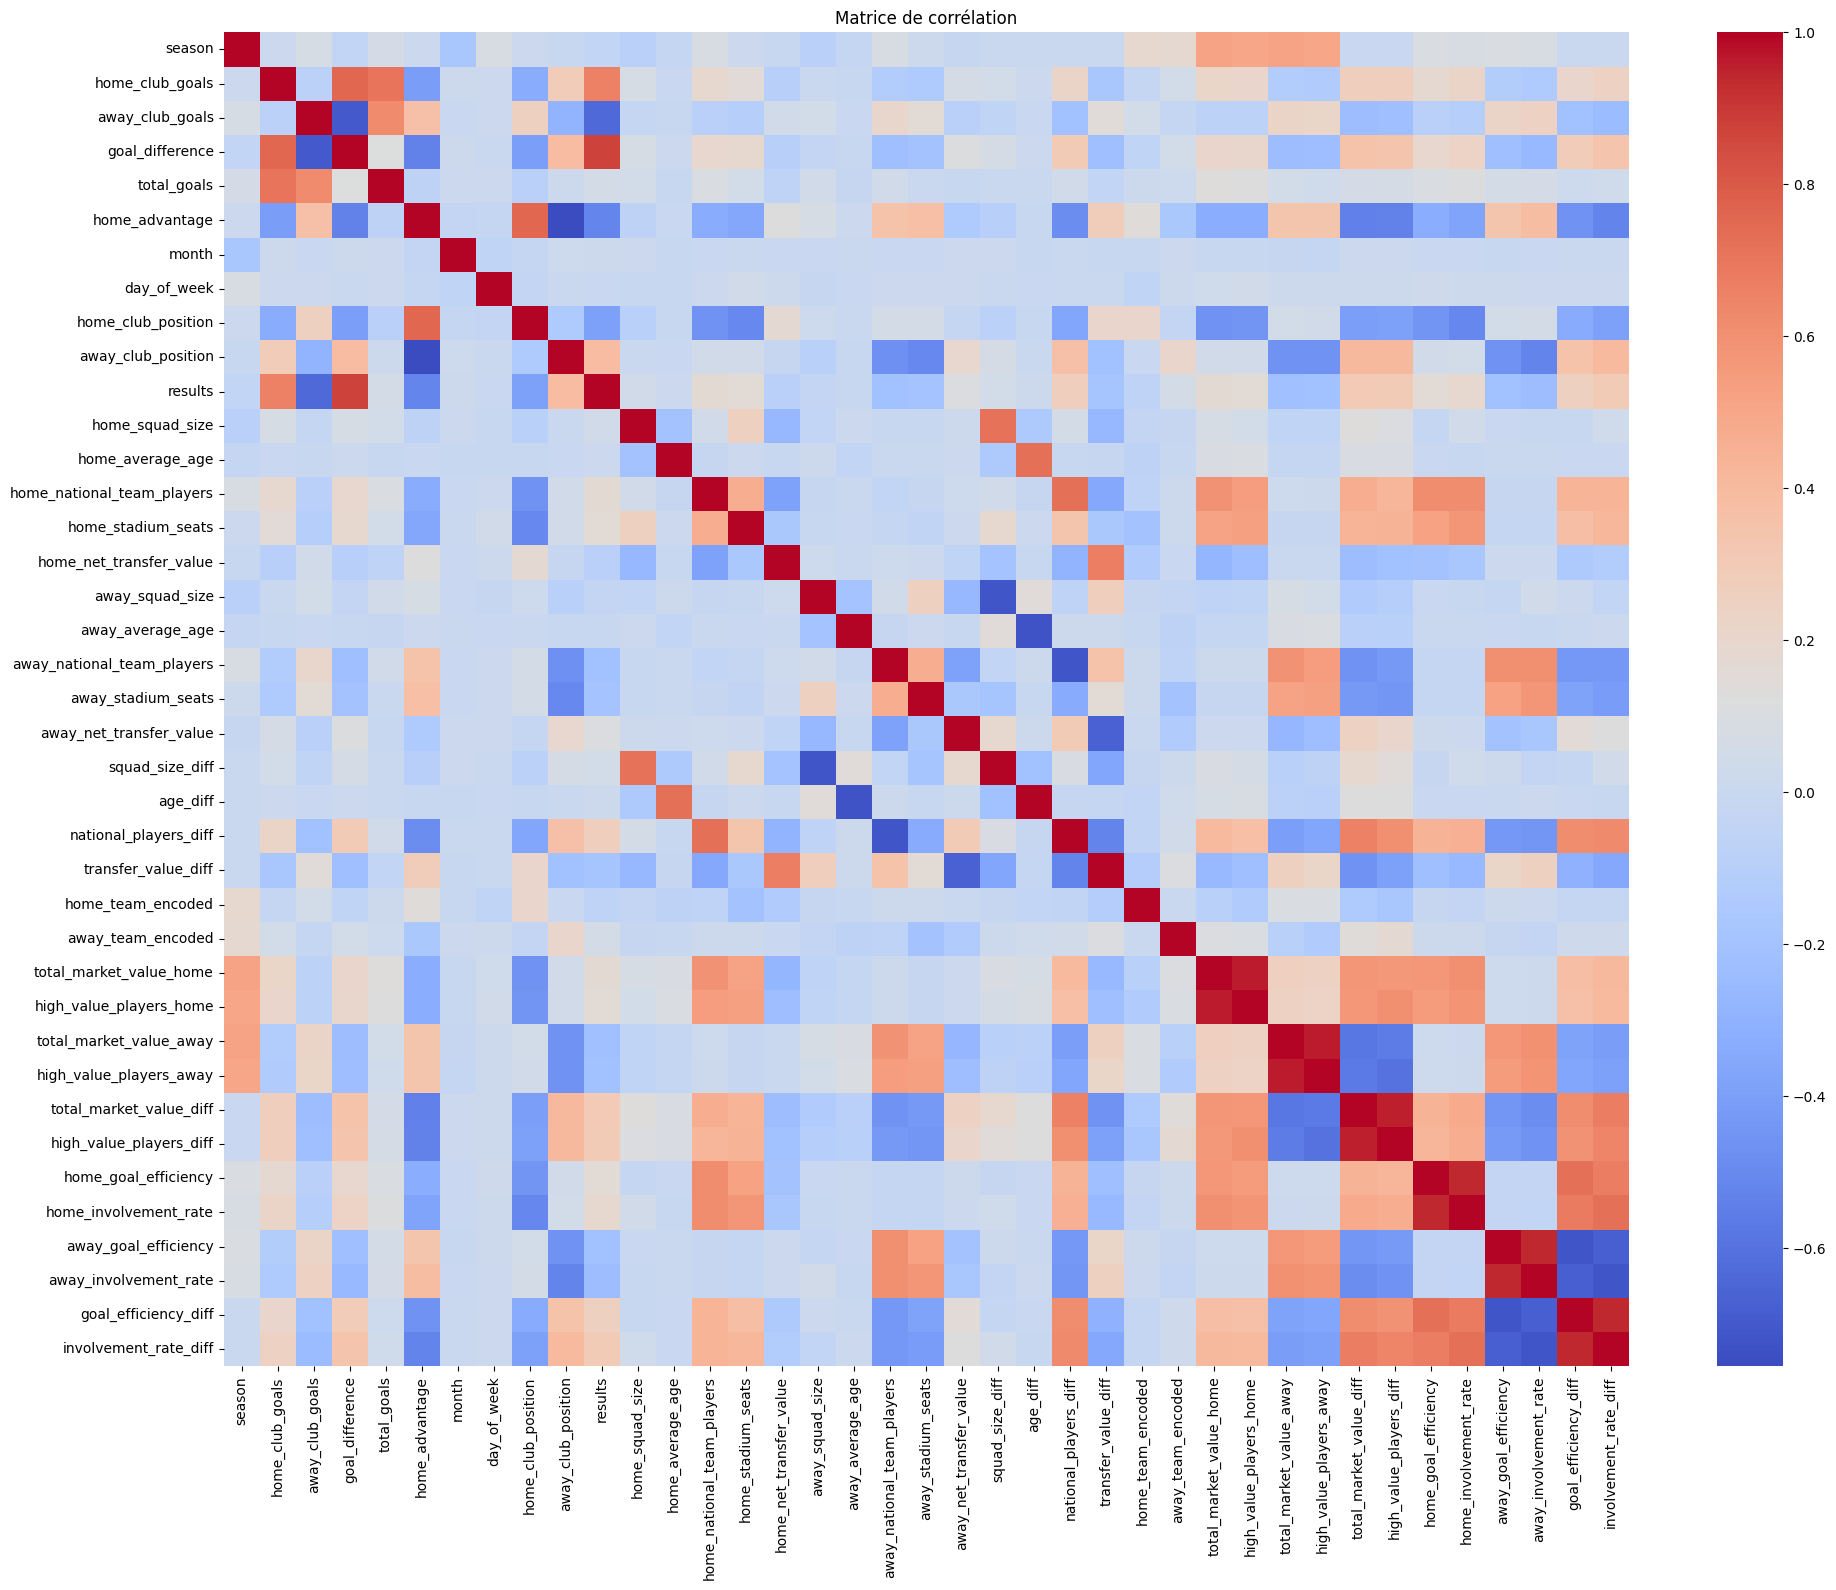

Variables fortement corrélées:
total_market_value_away  high_value_players_away    0.959362
high_value_players_away  total_market_value_away    0.959362
total_market_value_home  high_value_players_home    0.959320
high_value_players_home  total_market_value_home    0.959320
total_market_value_diff  high_value_players_diff    0.953615
high_value_players_diff  total_market_value_diff    0.953615
away_goal_efficiency     away_involvement_rate      0.940411
away_involvement_rate    away_goal_efficiency       0.940411
home_goal_efficiency     home_involvement_rate      0.940291
home_involvement_rate    home_goal_efficiency       0.940291
involvement_rate_diff    goal_efficiency_diff       0.940016
goal_efficiency_diff     involvement_rate_diff      0.940016
results                  goal_difference            0.875530
goal_difference          results                    0.875530
dtype: float64


In [ ]:
# Test de corrélation
corr_matrix = df_to_clean.corr()
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Matrice de corrélation')
plt.tight_layout()
plt.show()

# Identifier les variables fortement corrélées (|r| > 0.8)
high_corr = corr_matrix.abs().unstack().sort_values(ascending=False)
high_corr = high_corr[(high_corr < 1.0) & (high_corr > 0.8)]
print("Variables fortement corrélées:")
print(high_corr)

In [ ]:

vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data.sort_values('VIF', ascending=False))


                      Variable           VIF
5               home_advantage           inf
9           away_club_position           inf
35       away_involvement_rate           inf
37       involvement_rate_diff           inf
8           home_club_position           inf
34        away_goal_efficiency  9.007199e+15
36        goal_efficiency_diff  4.503600e+15
32        home_goal_efficiency  3.002400e+15
33       home_involvement_rate  3.002400e+15
11            home_average_age  7.003552e+05
16            away_average_age  7.002493e+05
10             home_squad_size  1.197235e+04
15             away_squad_size  1.196327e+04
21                    age_diff  2.913023e+03
0                       season  2.093498e+03
12  home_national_team_players  1.999673e+03
17  away_national_team_players  1.999046e+03
22       national_players_diff  9.236132e+02
2              away_club_goals  3.557929e+02
4                  total_goals  2.589675e+02
3              goal_difference  1.657079e+02
20        

## 🧪 Interprétation de vos résultats
Dans la sortie, plusieurs variables présentent un VIF infini (inf), ce qui signifie qu'elles sont parfaitement corrélées avec d'autres variables du modèleet D'autres variables ont des VIF extrêmement élevés

                      Variable  Information Mutuelle
3              goal_difference              1.072568
1              home_club_goals              0.297158
4                  total_goals              0.282589
2              away_club_goals              0.272849
5               home_advantage              0.159648
9           away_club_position              0.083437
8           home_club_position              0.081065
23         transfer_value_diff              0.069729
36        goal_efficiency_diff              0.069131
37       involvement_rate_diff              0.067382
31     high_value_players_diff              0.055147
29     high_value_players_away              0.046010
16            away_average_age              0.045821
30     total_market_value_diff              0.044313
19     away_net_transfer_value              0.040147
12  home_national_team_players              0.039977
18          away_stadium_seats              0.039158
17  away_national_team_players              0.

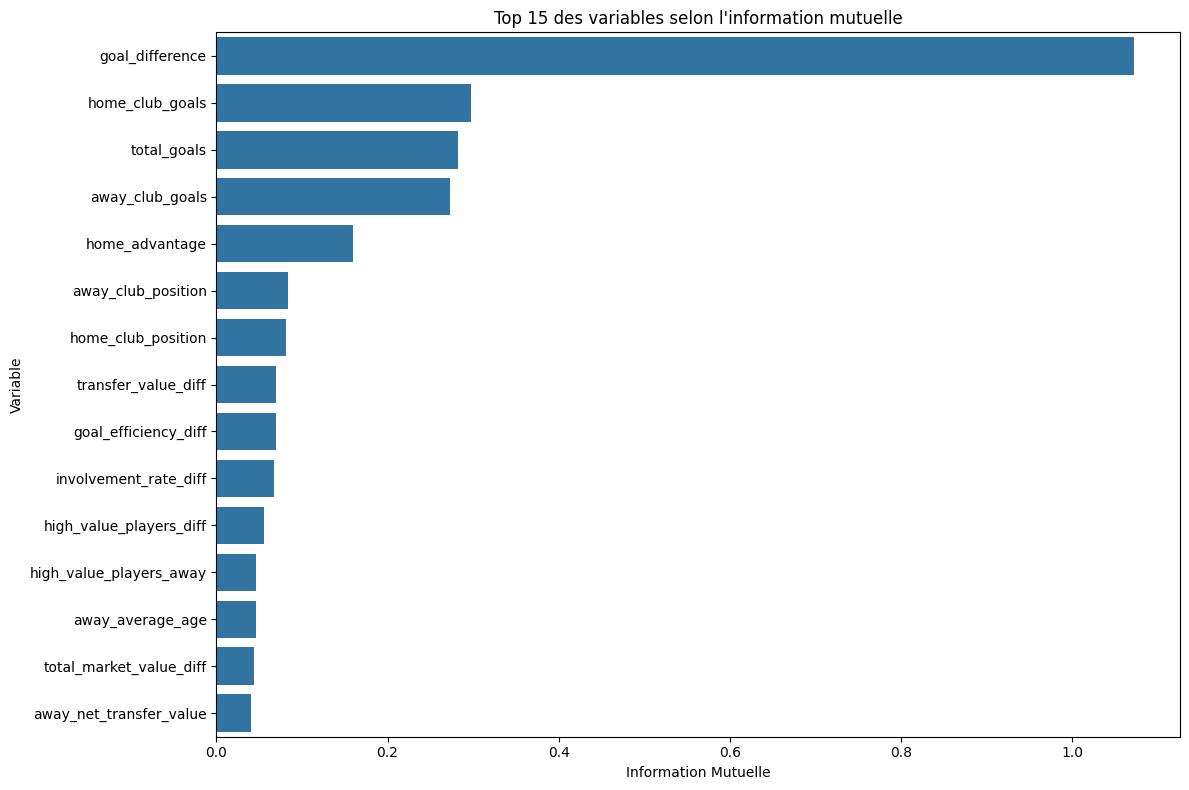

In [ ]:

#Test d'importance des caractéristiques
mutual_info = mutual_info_classif(X, y)
mi_df = pd.DataFrame({'Variable': X.columns, 'Information Mutuelle': mutual_info})
mi_df = mi_df.sort_values('Information Mutuelle', ascending=False)
print(mi_df)

# Visualisation
plt.figure(figsize=(12, 8))
sns.barplot(x='Information Mutuelle', y='Variable', data=mi_df.head(15))
plt.title('Top 15 des variables selon l\'information mutuelle')
plt.tight_layout()
plt.show()

## IV-3. (ACP) & Entraînement du modèle  

1.   **XGBoost**

2.   **Neural Network**


# **2.   XGBoost**



APPROCHE: ENTRAÎNEMENT AVEC XGBOOST ET ACP
Nombre de composantes principales conservées: 19
Variance expliquée par composante: [0.25135799 0.12701674 0.06982291 0.05597994 0.05386842 0.04901213
 0.04629433 0.04141465 0.03283917 0.03067231 0.02851826 0.02669744
 0.02565071 0.02411135 0.0226987  0.01814417 0.0175468  0.01728315
 0.01331291]
Variance totale expliquée: 0.9522

Correspondance des classes:
Classe originale -1 -> Classe encodée 0
Classe originale 0 -> Classe encodée 1
Classe originale 1 -> Classe encodée 2

Distribution des classes encodées: [ 962  858 1442]
Poids des classes: {np.int64(0): np.float64(1.1302841302841302), np.int64(1): np.float64(1.2672882672882673), np.int64(2): np.float64(0.7540453074433657)}
Scores de validation croisée (F1 weighted): [0.88505817 0.86028051 0.86523177 0.85196204 0.87165735]
Score F1 weighted moyen en validation croisée: 0.8668 ± 0.0112

Temps d'entraînement: 23.88 secondes

=== Performances du Modèle XGBoost avec ACP ===
Accuracy          

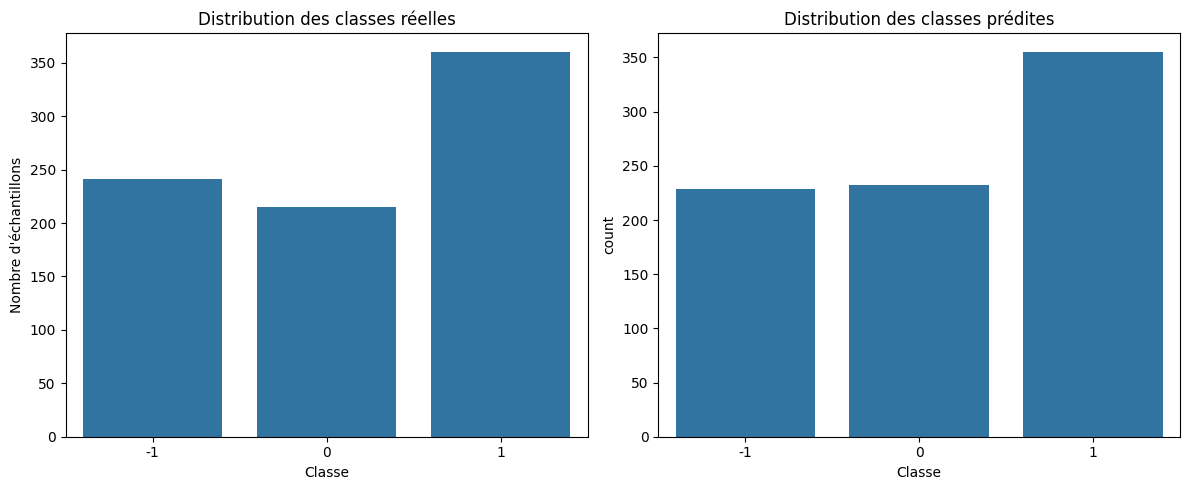

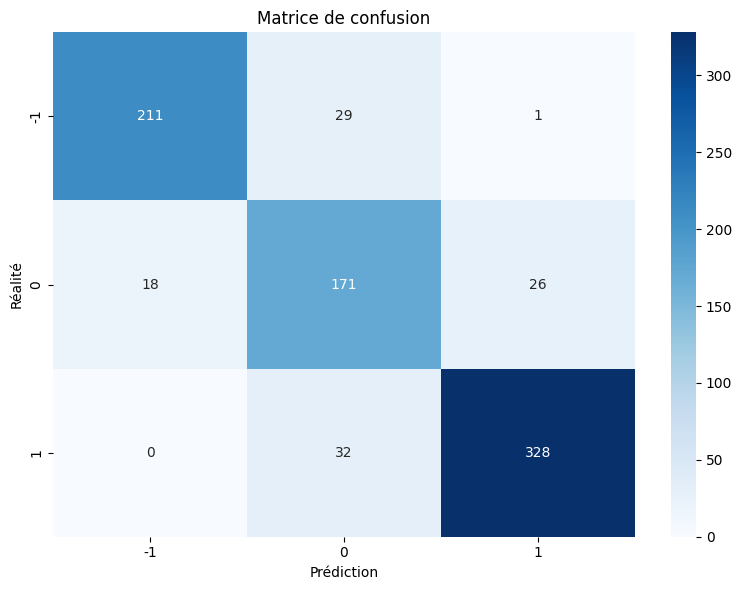

<Figure size 1200x800 with 0 Axes>

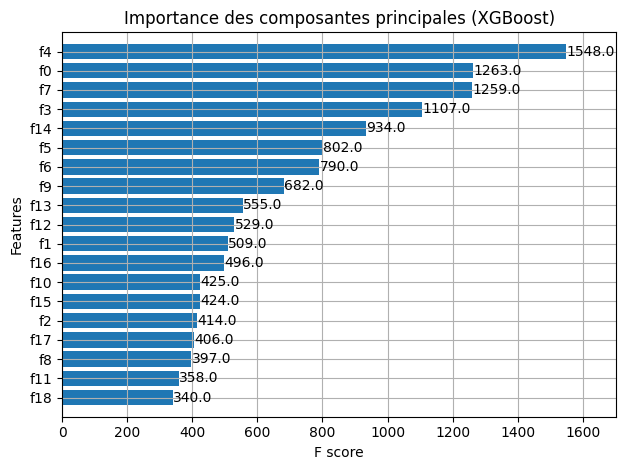

In [ ]:
#------------------------------------------
# APPROCHE: ENTRAÎNEMENT AVEC XGBOOST ET ACP
#------------------------------------------
print("\n" + "="*50)
print("APPROCHE: ENTRAÎNEMENT AVEC XGBOOST ET ACP")
print("="*50)

# Import de XGBoost et des bibliothèques nécessaires
import xgboost as xgb
import time
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, matthews_corrcoef, confusion_matrix,
                            classification_report)

# Mesure du temps d'entraînement
start_time = time.time()

# Pipeline avec standardisation et ACP
pca_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95))  # Conserver 95% de la variance
])

# Application de l'ACP
X_train_pca = pca_pipeline.fit_transform(X_train)
X_test_pca = pca_pipeline.transform(X_test)

# Afficher des informations sur la réduction de dimension
n_components = pca_pipeline.named_steps['pca'].n_components_
explained_variance = pca_pipeline.named_steps['pca'].explained_variance_ratio_
print(f"Nombre de composantes principales conservées: {n_components}")
print(f"Variance expliquée par composante: {explained_variance}")
print(f"Variance totale expliquée: {sum(explained_variance):.4f}")

# Conversion des étiquettes -1, 0, 1 pour XGBoost avec LabelEncoder
# XGBoost nécessite des classes commençant par 0
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Afficher la correspondance des classes
print("\nCorrespondance des classes:")
for i, original_class in enumerate(label_encoder.classes_):
    print(f"Classe originale {original_class} -> Classe encodée {i}")

# Entraînement du modèle XGBoost sur les données réduites par ACP
xgb_pca = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softprob',  # Pour la classification multi-classes
    random_state=42,
    n_jobs=-1,
    use_label_encoder=False,
    eval_metric='mlogloss'        # Pour la classification multi-classes
)

# Gestion des classes déséquilibrées
class_distribution = np.bincount(y_train_encoded)
print(f"\nDistribution des classes encodées: {class_distribution}")

# Calcul des poids pour compenser le déséquilibre des classes
if len(set(y_train_encoded)) > 1:
    from sklearn.utils.class_weight import compute_class_weight
    classes = np.unique(y_train_encoded)
    class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_encoded)
    class_weight_dict = {i: weight for i, weight in zip(classes, class_weights)}
    print(f"Poids des classes: {class_weight_dict}")

    # On peut utiliser sample_weight plutôt que scale_pos_weight pour multi-classe
    sample_weights = np.array([class_weight_dict[y] for y in y_train_encoded])

# Validation croisée pour évaluer la stabilité du modèle
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_pca = cross_val_score(xgb_pca, X_train_pca, y_train_encoded, cv=cv, scoring='f1_weighted')
print(f"Scores de validation croisée (F1 weighted): {cv_scores_pca}")
print(f"Score F1 weighted moyen en validation croisée: {cv_scores_pca.mean():.4f} ± {cv_scores_pca.std():.4f}")

# Entraînement sur l'ensemble des données d'entraînement
if len(set(y_train_encoded)) > 1:
    xgb_pca.fit(X_train_pca, y_train_encoded, sample_weight=sample_weights)
else:
    xgb_pca.fit(X_train_pca, y_train_encoded)

# Mesure du temps d'entraînement
training_time = time.time() - start_time
print(f"\nTemps d'entraînement: {training_time:.2f} secondes")

# Prédictions
y_pred_encoded = xgb_pca.predict(X_test_pca)
y_proba = xgb_pca.predict_proba(X_test_pca)

# Reconversion des prédictions en classes originales
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Mesures de performance
accuracy = accuracy_score(y_test, y_pred)
precision_macro = precision_score(y_test, y_pred, average='macro')
precision_weighted = precision_score(y_test, y_pred, average='weighted')
recall_macro = recall_score(y_test, y_pred, average='macro')
recall_weighted = recall_score(y_test, y_pred, average='weighted')
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

# Affichage
print("\n=== Performances du Modèle XGBoost avec ACP ===")
print(f"{'Accuracy':<25} {accuracy:.6f}")
print(f"{'Precision (macro)':<25} {precision_macro:.6f}")
print(f"{'Precision (weighted)':<25} {precision_weighted:.6f}")
print(f"{'Recall (macro)':<25} {recall_macro:.6f}")
print(f"{'Recall (weighted)':<25} {recall_weighted:.6f}")
print(f"{'F1-score (macro)':<25} {f1_macro:.6f}")
print(f"{'F1-score (weighted)':<25} {f1_weighted:.6f}")
print(f"{'MCC':<25} {mcc:.6f}")

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nMatrice de confusion:")
print(conf_matrix)

# Rapport de classification
print("\nRapport de classification avec les classes originales:")
print(classification_report(y_test, y_pred, digits=4))

# Importance des composantes principales
if hasattr(xgb_pca, 'feature_importances_'):
    print("\nImportance des composantes principales:")
    importances = xgb_pca.feature_importances_
    indices = np.argsort(importances)[::-1]

    for i, idx in enumerate(indices[:min(20, len(indices))]):  # Afficher les 20 plus importantes ou moins si moins de composantes
        print(f"Composante {idx}: {importances[idx]:.6f}")

# Analyse des confusions entre classes
print("\nAnalyse détaillée des confusions entre classes:")
for i, class_name in enumerate(label_encoder.classes_):
    class_indices = (y_test == class_name)
    if sum(class_indices) > 0:  # S'assurer qu'il y a des exemples de cette classe
        class_accuracy = accuracy_score(y_test[class_indices], y_pred[class_indices])
        print(f"Classe {class_name}: {class_accuracy:.4f} d'accuracy ({sum(class_indices)} exemples)")

        # Afficher les erreurs de classification pour cette classe
        if sum(y_test[class_indices] != y_pred[class_indices]) > 0:
            misclassified = {}
            for true, pred in zip(y_test[class_indices], y_pred[class_indices]):
                if true != pred:
                    if pred not in misclassified:
                        misclassified[pred] = 0
                    misclassified[pred] += 1

            print(f"  → Confusions: ", end="")
            for pred_class, count in misclassified.items():
                print(f"{count} exemples classés à tort comme {pred_class}", end="; ")
            print()

# Visualisations (optionnel)
try:
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Distribution des classes prédites vs réelles
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    class_names = label_encoder.classes_
    sns.countplot(x=y_test, order=class_names)
    plt.title('Distribution des classes réelles')
    plt.xlabel('Classe')
    plt.ylabel('Nombre d\'échantillons')

    plt.subplot(1, 2, 2)
    sns.countplot(x=y_pred, order=class_names)
    plt.title('Distribution des classes prédites')
    plt.xlabel('Classe')

    plt.tight_layout()
    plt.show()

    # Matrice de confusion avec heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Prédiction')
    plt.ylabel('Réalité')
    plt.title('Matrice de confusion')
    plt.tight_layout()
    plt.show()

    # Importance des composantes
    if hasattr(xgb_pca, 'feature_importances_'):
        plt.figure(figsize=(12, 8))
        xgb.plot_importance(xgb_pca, max_num_features=min(20, len(xgb_pca.feature_importances_)), height=0.8)
        plt.title('Importance des composantes principales (XGBoost)')
        plt.tight_layout()
        plt.show()

except ImportError:
    print("\nL'affichage graphique nécessite matplotlib et seaborn.")

# ⏬ **Sauvegarde des modèles entraine**

In [ ]:
# Définition du chemin
base_path2 = '/content/drive/MyDrive/ColabModels/Ligue1_Prediction/'

# Création du répertoire s'il n'existe pas
os.makedirs(base_path2, exist_ok=True)

# Chemin complet du fichier
model_path = os.path.join(base_path2, 'rf_pca_model.pkl')
model_path2 = os.path.join(base_path2, 'xgb_pca_model.pkl')

# Sauvegarde du modèle
with open(model_path, 'wb') as file:
    pickle.dump(rf_pca, file)

with open(model_path2, 'wb') as file:
    pickle.dump(xgb_pca, file)

pipeline_path = os.path.join(base_path2, 'pca_pipeline.pkl')
with open(pipeline_path, 'wb') as file:
    pickle.dump(pca_pipeline, file)

print(f"Modèle Random Forest avec ACP sauvegardé avec succès à: {model_path}")
print(f"Pipeline ACP sauvegardé avec succès à: {pipeline_path}")
print(f"Modèle XGBoost avec ACP sauvegardé avec succès à: {model_path2}")


Modèle Random Forest avec ACP sauvegardé avec succès à: /content/drive/MyDrive/ColabModels/Ligue1_Prediction/rf_pca_model.pkl
Pipeline ACP sauvegardé avec succès à: /content/drive/MyDrive/ColabModels/Ligue1_Prediction/pca_pipeline.pkl
Modèle XGBoost avec ACP sauvegardé avec succès à: /content/drive/MyDrive/ColabModels/Ligue1_Prediction/xgb_pca_model.pkl


## **V- Preparation du Dataset du Test `match_2023.csv`**


1.   **Test Avec le modèle XGBoost**
2.   **Test Avec le modèle Neural Network.**
3.   **Les liens de Téléchargements.**



In [14]:
# Définition des chemins
base_path = '/content/drive/MyDrive/ColabModels/Ligue1_Prediction/'
model_path = os.path.join(base_path, 'rf_pca_model.pkl')
pipeline_path = os.path.join(base_path, 'pca_pipeline.pkl')



# ======================================================
# 1. CHARGEMENT DU MODÈLE ET DE LA PIPELINE
# ======================================================

print("\n" + "="*50)
print("CHARGEMENT DU MODÈLE PRÉ-ENTRAÎNÉ")
print("="*50)

# Chargement du modèle Random Forest
with open(model_path, 'rb') as file:
    rf_pca = pickle.load(file)

# Chargement de la pipeline PCA
with open(pipeline_path, 'rb') as file:
    pca_pipeline = pickle.load(file)

print("✅ Modèle et pipeline chargés avec succès")

# ======================================================
# 2. PRÉPARATION DES DONNÉES DE TEST (2023)
# ======================================================

print("\n" + "="*50)
print("PRÉPARATION DES DONNÉES DE TEST (2023)")
print("="*50)

def prepare_test_data(df_match_2023, df_clubs, df_valuations, df_appearance, df_lineups, df_events):
    """
    Prépare les données de test en suivant les mêmes étapes que pour l'ensemble d'entraînement
    """
    print("Conversion de la date en datetime...")
    # Conversion des dates en format datetime pour tous les dataframes
    df_match_2023['date'] = pd.to_datetime(df_match_2023['date'])

    # Vérifier et convertir les colonnes date dans les autres dataframes
    if 'date' in df_valuations.columns:
        df_valuations['date'] = pd.to_datetime(df_valuations['date'], errors='coerce')

    if 'date' in df_appearance.columns:
        df_appearance['date'] = pd.to_datetime(df_appearance['date'], errors='coerce')

    # Extraction de la saison (année)
    print("Extraction de la saison...")
    df_match_2023['season'] = df_match_2023['date'].dt.year

    # Extraction du mois et du jour de la semaine
    print("Extraction des caractéristiques temporelles...")
    df_match_2023['month'] = df_match_2023['date'].dt.month
    df_match_2023['day_of_week'] = df_match_2023['date'].dt.dayofweek

    # 1. Enrichissement avec les données des clubs
    print("Enrichissement avec les données des clubs...")

    # Prétraitement de la colonne net_transfer_record
    def convert_transfer_to_numeric(value):
        if pd.isna(value) or value == '-':
            return 0

        value = value.replace('€', '').replace('+', '').strip()

        if 'm' in value:  # Millions
            return float(value.replace('m', '').strip()) * 1000000
        elif 'k' in value:  # Milliers
            return float(value.replace('k', '').strip()) * 1000
        else:
            try:
                return float(value)
            except:
                return 0

    df_clubs['net_transfer_value'] = df_clubs['net_transfer_record'].apply(convert_transfer_to_numeric)

    # Sélection des caractéristiques des clubs
    clubs_features = df_clubs[[
        'club_id',
        'squad_size',
        'average_age',
        'national_team_players',
        'stadium_seats',
        'net_transfer_value'
    ]]

    # Préparation pour l'équipe à domicile
    home_clubs = clubs_features.copy()
    home_clubs.columns = ['home_club_id'] + ['home_' + col for col in clubs_features.columns if col != 'club_id']

    # Préparation pour l'équipe à l'extérieur
    away_clubs = clubs_features.copy()
    away_clubs.columns = ['away_club_id'] + ['away_' + col for col in clubs_features.columns if col != 'club_id']

    # Fusion avec le dataframe principal
    df_match_2023 = df_match_2023.merge(home_clubs, on='home_club_id', how='left')
    df_match_2023 = df_match_2023.merge(away_clubs, on='away_club_id', how='left')

    # Calcul des différences
    df_match_2023['squad_size_diff'] = df_match_2023['home_squad_size'] - df_match_2023['away_squad_size']
    df_match_2023['age_diff'] = df_match_2023['home_average_age'] - df_match_2023['away_average_age']
    df_match_2023['national_players_diff'] = df_match_2023['home_national_team_players'] - df_match_2023['away_national_team_players']
    df_match_2023['transfer_value_diff'] = df_match_2023['home_net_transfer_value'] - df_match_2023['away_net_transfer_value']

    # Encodage des équipes
    try:
        # Chargement du mapping des équipes si disponible
        with open(os.path.join(base_path, 'team_mapping.pkl'), 'rb') as file:
            team_mapping = pickle.load(file)
        print("Mapping des équipes chargé avec succès")
    except:
        print("Mapping des équipes non trouvé, création d'un nouveau mapping")
        # Créer un mapping simple basé sur les noms des équipes
        team_names = pd.concat([df_match_2023['home_club_name'], df_match_2023['away_club_name']]).unique()
        team_mapping = {team: i for i, team in enumerate(team_names)}

    df_match_2023['home_team_encoded'] = df_match_2023['home_club_name'].map(team_mapping)
    df_match_2023['away_team_encoded'] = df_match_2023['away_club_name'].map(team_mapping)

    # 2. Enrichissement avec les données de valuation des joueurs
    print("Enrichissement avec les données de valuation des joueurs...")

    # Vérifier si la colonne date est au format datetime
    if not pd.api.types.is_datetime64_any_dtype(df_valuations['date']):
        print("ATTENTION: Conversion de la colonne date dans df_valuations en datetime")
        df_valuations['date'] = pd.to_datetime(df_valuations['date'], errors='coerce')

    # Filtrer les valuations pour l'année 2022 (avant la saison 2023)
    # Ajout de sécurité pour éviter les NaT (Not a Time) après la conversion
    df_valuations = df_valuations.dropna(subset=['date'])
    recent_valuations = df_valuations[df_valuations['date'].dt.year == 2022]

    # Agréger les valuations par club
    club_valuations = recent_valuations.groupby(['current_club_id']).agg({
        'market_value_in_eur': ['sum'],
    }).reset_index()

    # Renommer les colonnes
    club_valuations.columns = ['current_club_id', 'total_market_value']

    # Ajouter le nombre de joueurs de valeur élevée (> 5M€)
    high_value_players = recent_valuations[recent_valuations['market_value_in_eur'] > 5000000].groupby(['current_club_id']).size().reset_index(name='high_value_players')
    club_valuations = club_valuations.merge(high_value_players, on=['current_club_id'], how='left').fillna({'high_value_players': 0})

    # Fusionner avec df_match_2023 pour l'équipe à domicile
    df_match_2023 = df_match_2023.merge(
        club_valuations,
        left_on=['home_club_id'],
        right_on=['current_club_id'],
        how='left',
        suffixes=('', '_home')
    ).drop(columns=['current_club_id'])

    # Fusionner avec df_match_2023 pour l'équipe à l'extérieur
    df_match_2023 = df_match_2023.merge(
        club_valuations,
        left_on=['away_club_id'],
        right_on=['current_club_id'],
        how='left',
        suffixes=('_home', '_away')
    ).drop(columns=['current_club_id'])

    # Créer les différences entre équipes
    df_match_2023['total_market_value_diff'] = df_match_2023['total_market_value_home'] - df_match_2023['total_market_value_away']
    df_match_2023['high_value_players_diff'] = df_match_2023['high_value_players_home'] - df_match_2023['high_value_players_away']

    # 3. Enrichissement avec les données d'apparition des joueurs
    print("Enrichissement avec les données d'apparition des joueurs...")

    # Vérifier si la colonne date est au format datetime
    if not pd.api.types.is_datetime64_any_dtype(df_appearance['date']):
        print("ATTENTION: Conversion de la colonne date dans df_appearance en datetime")
        df_appearance['date'] = pd.to_datetime(df_appearance['date'], errors='coerce')

    # Supprimer les lignes avec des dates invalides
    df_appearance = df_appearance.dropna(subset=['date'])

    # Filtrer pour les apparitions jusqu'à 2022
    recent_appearances = df_appearance[df_appearance['date'].dt.year <= 2022]

    # Extraire les métriques clés par joueur
    def extract_key_player_metrics(appearances_df, window_size=5):
        # Trier par joueur et date
        appearances_df = appearances_df.sort_values(['player_id', 'date'])

        # Calculer les statistiques récentes par joueur
        player_recent_metrics = []

        for player_id in appearances_df['player_id'].unique():
            player_matches = appearances_df[appearances_df['player_id'] == player_id].sort_values('date')

            # Uniquement les derniers matchs
            recent_matches = player_matches.tail(window_size)

            if len(recent_matches) > 0:
                # Calculer les métriques
                recent_goals = recent_matches['goals'].sum()
                recent_involvement = recent_matches['goals'].sum() + recent_matches['assists'].sum()

                player_recent_metrics.append({
                    'player_id': player_id,
                    'player_club_id': recent_matches['player_club_id'].iloc[-1],
                    'recent_goals': recent_goals,
                    'recent_involvement': recent_involvement,
                    'recent_matches': len(recent_matches)
                })

        return pd.DataFrame(player_recent_metrics)

    # Agréger au niveau de l'équipe
    def create_simplified_team_metrics(player_metrics):
        if player_metrics.empty:
            print("ATTENTION: Aucune métrique de joueur disponible")
            # Retourner un DataFrame vide avec les bonnes colonnes
            return pd.DataFrame(columns=['player_club_id', 'goal_efficiency', 'involvement_rate'])

        # Agréger au niveau de l'équipe
        team_metrics = player_metrics.groupby('player_club_id').agg({
            'recent_goals': 'sum',
            'recent_involvement': 'sum',
            'player_id': 'count'  # Nombre de joueurs
        }).reset_index()

        # Normaliser par le nombre de joueurs
        team_metrics['goal_efficiency'] = team_metrics['recent_goals'] / team_metrics['player_id']
        team_metrics['involvement_rate'] = team_metrics['recent_involvement'] / team_metrics['player_id']

        # Garder seulement les colonnes finales
        team_metrics = team_metrics[['player_club_id', 'goal_efficiency', 'involvement_rate']]

        return team_metrics

    # Extraire les métriques
    player_metrics = extract_key_player_metrics(recent_appearances)
    team_metrics = create_simplified_team_metrics(player_metrics)

    # Préparer pour la fusion
    if not team_metrics.empty:
        home_team_metrics = team_metrics.copy()
        home_team_metrics.columns = ['home_club_id' if col == 'player_club_id' else f'home_{col}' for col in team_metrics.columns]

        away_team_metrics = team_metrics.copy()
        away_team_metrics.columns = ['away_club_id' if col == 'player_club_id' else f'away_{col}' for col in team_metrics.columns]

        # Fusionner avec le dataframe principal
        df_match_2023 = df_match_2023.merge(home_team_metrics, on='home_club_id', how='left')
        df_match_2023 = df_match_2023.merge(away_team_metrics, on='away_club_id', how='left')

        # Créer les différences pour les métriques clés
        df_match_2023['goal_efficiency_diff'] = df_match_2023['home_goal_efficiency'] - df_match_2023['away_goal_efficiency']
        df_match_2023['involvement_rate_diff'] = df_match_2023['home_involvement_rate'] - df_match_2023['away_involvement_rate']
    else:
        print("ATTENTION: Ajout de colonnes vides pour les métriques d'équipe")
        for prefix in ['home_', 'away_']:
            df_match_2023[f'{prefix}goal_efficiency'] = 0
            df_match_2023[f'{prefix}involvement_rate'] = 0
        df_match_2023['goal_efficiency_diff'] = 0
        df_match_2023['involvement_rate_diff'] = 0

    # Gestion des valeurs manquantes
    print("Gestion des valeurs manquantes...")
    numeric_columns = df_match_2023.select_dtypes(include=[np.number]).columns
    df_match_2023[numeric_columns] = df_match_2023[numeric_columns].fillna(0)

    return df_match_2023

    # Extraire les métriques clés par joueur
    def extract_key_player_metrics(appearances_df, window_size=5):
        # Trier par joueur et date
        appearances_df = appearances_df.sort_values(['player_id', 'date'])

        # Calculer les statistiques récentes par joueur
        player_recent_metrics = []

        for player_id in appearances_df['player_id'].unique():
            player_matches = appearances_df[appearances_df['player_id'] == player_id].sort_values('date')

            # Uniquement les derniers matchs
            recent_matches = player_matches.tail(window_size)

            if len(recent_matches) > 0:
                # Calculer les métriques
                recent_goals = recent_matches['goals'].sum()
                recent_involvement = recent_matches['goals'].sum() + recent_matches['assists'].sum()

                player_recent_metrics.append({
                    'player_id': player_id,
                    'player_club_id': recent_matches['player_club_id'].iloc[-1],
                    'recent_goals': recent_goals,
                    'recent_involvement': recent_involvement,
                    'recent_matches': len(recent_matches)
                })

        return pd.DataFrame(player_recent_metrics)

    # Agréger au niveau de l'équipe
    def create_simplified_team_metrics(player_metrics):
        # Agréger au niveau de l'équipe
        team_metrics = player_metrics.groupby('player_club_id').agg({
            'recent_goals': 'sum',
            'recent_involvement': 'sum',
            'player_id': 'count'  # Nombre de joueurs
        }).reset_index()

        # Normaliser par le nombre de joueurs
        team_metrics['goal_efficiency'] = team_metrics['recent_goals'] / team_metrics['player_id']
        team_metrics['involvement_rate'] = team_metrics['recent_involvement'] / team_metrics['player_id']

        # Garder seulement les colonnes finales
        team_metrics = team_metrics[['player_club_id', 'goal_efficiency', 'involvement_rate']]

        return team_metrics

    # Extraire les métriques
    player_metrics = extract_key_player_metrics(recent_appearances)
    team_metrics = create_simplified_team_metrics(player_metrics)

    # Préparer pour la fusion
    home_team_metrics = team_metrics.copy()
    home_team_metrics.columns = ['home_club_id' if col == 'player_club_id' else f'home_{col}' for col in team_metrics.columns]

    away_team_metrics = team_metrics.copy()
    away_team_metrics.columns = ['away_club_id' if col == 'player_club_id' else f'away_{col}' for col in team_metrics.columns]

    # Fusionner avec le dataframe principal
    df_match_2023 = df_match_2023.merge(home_team_metrics, on='home_club_id', how='left')
    df_match_2023 = df_match_2023.merge(away_team_metrics, on='away_club_id', how='left')

    # Créer les différences pour les métriques clés
    df_match_2023['goal_efficiency_diff'] = df_match_2023['home_goal_efficiency'] - df_match_2023['away_goal_efficiency']
    df_match_2023['involvement_rate_diff'] = df_match_2023['home_involvement_rate'] - df_match_2023['away_involvement_rate']

    # Gestion des valeurs manquantes
    print("Gestion des valeurs manquantes...")
    numeric_columns = df_match_2023.select_dtypes(include=[np.number]).columns
    df_match_2023[numeric_columns] = df_match_2023[numeric_columns].fillna(0)

    return df_match_2023

# Préparation des données de test
test_data = prepare_test_data(df_match_2023, df_clubs, df_valuations, df_appearance, df_lineups, df_events)

# Chargeons les noms exacts des features utilisées lors de l'entraînement
# Si vous n'avez pas sauvegardé les colonnes exactes, nous pouvons essayer d'analyser la pipeline PCA
print("Analyse de la pipeline PCA pour déterminer les features nécessaires...")

# Déterminer les features utilisées lors de l'entraînement
try:
    # Si le premier composant de la pipeline est StandardScaler, il contient feature_names_in_
    if hasattr(pca_pipeline.named_steps['scaler'], 'feature_names_in_'):
        X_columns = list(pca_pipeline.named_steps['scaler'].feature_names_in_)
        print(f"Colonnes extraites du StandardScaler: {len(X_columns)} colonnes trouvées")
    else:
        raise AttributeError("Le StandardScaler ne contient pas feature_names_in_")
except (KeyError, AttributeError) as e:
    print(f"Impossible d'extraire les colonnes du modèle: {e}")
    print("Utilisation d'une approche alternative...")

    # Approche alternative: définir manuellement les colonnes attendues par le modèle
    # Basé sur le code d'origine, voici une liste des colonnes typiques
    print("Définition manuelle des colonnes couramment utilisées...")
    X_columns = [
        'season', 'month', 'day_of_week',
        'home_squad_size', 'home_average_age', 'home_national_team_players', 'home_stadium_seats', 'home_net_transfer_value',
        'away_squad_size', 'away_average_age', 'away_national_team_players', 'away_stadium_seats', 'away_net_transfer_value',
        'squad_size_diff', 'age_diff', 'national_players_diff', 'transfer_value_diff',
        'home_team_encoded', 'away_team_encoded',
        'total_market_value_home', 'high_value_players_home', 'total_market_value_away', 'high_value_players_away',
        'total_market_value_diff', 'high_value_players_diff',
        'home_goal_efficiency', 'home_involvement_rate', 'away_goal_efficiency', 'away_involvement_rate',
        'goal_efficiency_diff', 'involvement_rate_diff'
    ]

    # Sauvegarder ces colonnes pour référence future
    try:
        with open(os.path.join(base_path, 'feature_columns_manual.pkl'), 'wb') as file:
            pickle.dump(X_columns, file)
        print("Liste des colonnes sauvegardée pour référence future")
    except Exception as e:
        print(f"Impossible de sauvegarder la liste des colonnes: {e}")

# Afficher la liste des colonnes pour vérification
print(f"Nombre de colonnes requises: {len(X_columns)}")

# Vérifier quelles colonnes manquent dans nos données de test
missing_cols = set(X_columns) - set(test_data.columns)
if missing_cols:
    print(f"Colonnes manquantes dans les données de test: {missing_cols}")
    # Ajouter les colonnes manquantes avec des valeurs par défaut (0)
    for col in missing_cols:
        test_data[col] = 0
        print(f"Colonne ajoutée avec valeur par défaut: {col}")

# Vérifier s'il y a des colonnes en excès
extra_cols = set(test_data.columns) - set(X_columns) - {'game_id'}  # Exclure game_id
if extra_cols:
    print(f"Colonnes en excès (non utilisées pour la prédiction): {len(extra_cols)}")

# Préparer les données pour la prédiction en utilisant exactement les mêmes colonnes que lors de l'entraînement
# Et dans le même ordre!
test_features = test_data[X_columns].copy()

# Afficher des informations sur les données préparées
print(f"Forme des données de test après préparation: {test_features.shape}")
print("Vérification des valeurs manquantes...")
missing_values = test_features.isna().sum().sum()
if missing_values > 0:
    print(f"ATTENTION: {missing_values} valeurs manquantes détectées dans les données de test")
    print("Remplacement des valeurs manquantes par 0...")
    test_features = test_features.fillna(0)
else:
    print("Aucune valeur manquante détectée")



CHARGEMENT DU MODÈLE PRÉ-ENTRAÎNÉ
✅ Modèle et pipeline chargés avec succès

PRÉPARATION DES DONNÉES DE TEST (2023)
Conversion de la date en datetime...
Extraction de la saison...
Extraction des caractéristiques temporelles...
Enrichissement avec les données des clubs...
Mapping des équipes non trouvé, création d'un nouveau mapping
Enrichissement avec les données de valuation des joueurs...
Enrichissement avec les données d'apparition des joueurs...
Gestion des valeurs manquantes...
Analyse de la pipeline PCA pour déterminer les features nécessaires...
Colonnes extraites du StandardScaler: 38 colonnes trouvées
Nombre de colonnes requises: 38
Colonnes manquantes dans les données de test: {'away_club_position', 'home_advantage', 'away_club_goals', 'home_club_goals', 'total_goals', 'home_club_position', 'goal_difference'}
Colonne ajoutée avec valeur par défaut: away_club_position
Colonne ajoutée avec valeur par défaut: home_advantage
Colonne ajoutée avec valeur par défaut: away_club_goals

# V.1.**Test Avec Le model `XGBoost`**

In [10]:
# ======================================================
# 3. PRÉDICTIONS SUR LES DONNÉES DE TEST 2023 avec le modèle XGBoost
# ======================================================

print("\n" + "="*50)
print("PRÉDICTIONS SUR LES DONNÉES DE TEST 2023 AVEC XGBOOST")
print("="*50)

# Définition des chemins
base_path = '/content/drive/MyDrive/ColabModels/Ligue1_Prediction/'
model_path = os.path.join(base_path, 'xgb_pca_model.pkl')  # Notez le changement du nom du fichier
pipeline_path = os.path.join(base_path, 'pca_pipeline.pkl')

# Chargement du modèle XGBoost
print("Chargement du modèle XGBoost...")
with open(model_path, 'rb') as file:
    xgb_pca = pickle.load(file)

# Mesure du temps de prédiction
start_time = time.time()

# Transformer les données de test avec la pipeline PCA
try:
    print("Tentative de transformation des données avec la pipeline PCA...")
    test_features_pca = pca_pipeline.transform(test_features)
    print(f"Transformation réussie! Forme résultante: {test_features_pca.shape}")
except Exception as e:
    print(f"Erreur lors de la transformation: {e}")
    print("\nDiagnostic de l'erreur:")

    # # Vérifier si les types de données sont compatibles
    # print("\nTypes de données:")
    # print(test_features.dtypes.value_counts())

    # Dernière tentative: standardisation manuelle si la pipeline échoue
    print("\nTentative de transformation manuelle...")

    # Standardiser manuellement
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(test_features)

    # Réduire la dimensionnalité avec PCA (réglé pour conserver 95% de la variance)
    pca = PCA(n_components=0.95)
    test_features_pca = pca.fit_transform(X_scaled)

    print(f"Transformation manuelle réussie! Forme résultante: {test_features_pca.shape}")

# Prédire les résultats avec XGBoost
try:
    print("Génération des prédictions avec XGBoost...")
    predictions_2023_xgb = xgb_pca.predict(test_features_pca)

    # Si le modèle renvoie des probabilités, convertir en classes
    if len(predictions_2023_xgb.shape) > 1 and predictions_2023_xgb.shape[1] > 1:
        print("Conversion des probabilités en classes...")
        predictions_2023_xgb = np.argmax(predictions_2023_xgb, axis=1)

    # Conversion des classes encodées en classes originales (-1, 0, 1)
    # Si le modèle utilise un mapping de type {0: -1, 1: 0, 2: 1}
    class_mapping = {0: -1, 1: 0, 2: 1}
    predictions_2023 = np.array([class_mapping.get(pred, pred) for pred in predictions_2023_xgb])

    print("Prédictions générées avec succès!")
except Exception as e:
    print(f"Erreur lors de la prédiction: {e}")
    # Si cela échoue aussi, nous devrons réévaluer notre approche
    raise

# Créer le dataframe de prédictions
predictions_df = pd.DataFrame({
    'game_id': test_data['game_id'],
    'results': predictions_2023
})

# Temps de prédiction
prediction_time = time.time() - start_time
print(f"Temps de prédiction: {prediction_time:.2f} secondes")

# Vérifier que le format correspond au format attendu
print(f"Nombre de prédictions: {len(predictions_df)}")
if 'df_sample' in locals() or 'df_sample' in globals():
    print(f"Format attendu (sample_results.csv): {df_sample.shape}")

# Distribution des prédictions
print("\nDistribution des prédictions:")
value_counts = predictions_df['results'].value_counts(normalize=True) * 100
print(value_counts)
print("\nSignification des valeurs:")
print("1 : Victoire de l'équipe à domicile")
print("0 : Match nul")
print("-1 : Victoire de l'équipe à l'extérieur")

# Sauvegarder les prédictions
predictions_file = os.path.join(base_path, 'predictions_xgb_ligue1_2023-2024.csv')
predictions_df.to_csv(predictions_file, index=False)
print(f"\n✅ Prédictions enregistrées dans {predictions_file}")

print("\n" + "="*50)
print("TERMINÉ")
print("="*50)


PRÉDICTIONS SUR LES DONNÉES DE TEST 2023 AVEC XGBOOST
Chargement du modèle XGBoost...
Tentative de transformation des données avec la pipeline PCA...
Transformation réussie! Forme résultante: (270, 19)
Génération des prédictions avec XGBoost...
Prédictions générées avec succès!
Temps de prédiction: 0.01 secondes
Nombre de prédictions: 270
Format attendu (sample_results.csv): (270, 2)

Distribution des prédictions:
results
 1    52.962963
-1    45.185185
 0     1.851852
Name: proportion, dtype: float64

Signification des valeurs:
1 : Victoire de l'équipe à domicile
0 : Match nul
-1 : Victoire de l'équipe à l'extérieur

✅ Prédictions enregistrées dans /content/drive/MyDrive/ColabModels/Ligue1_Prediction/predictions_xgb_ligue1_2023-2024.csv

TERMINÉ


# V.2.**Test Avec Le model `Neural Network`**

In [17]:
# ======================================================
# 4. PRÉDICTIONS SUR LES DONNÉES DE TEST 2023 avec un Réseau de Neurones
# ======================================================

print("\n" + "="*50)
print("PRÉDICTIONS SUR LES DONNÉES DE TEST 2023 AVEC RÉSEAU DE NEURONES")
print("="*50)

# Configuration pour limiter l'utilisation de GPU (si nécessaire)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# 1. Préparation des données
print("Préparation des données pour le réseau de neurones...")

# Définition des chemins
base_path = '/content/drive/MyDrive/ColabModels/Ligue1_Prediction/'

# On vérifie d'abord si nous avons un modèle déjà entraîné
model_path_nn = os.path.join(base_path, 'nn_pca_model.h5')
model_exists = os.path.exists(model_path_nn)

if model_exists:
    print("Un modèle de réseau de neurones a été trouvé. Chargement du modèle...")
    model = load_model(model_path_nn)
    print("Modèle chargé avec succès!")

    # Transformation des données de test uniquement
    print("Transformation des données de test...")
    try:
        # Charger la pipeline PCA si elle existe
        pipeline_path = os.path.join(base_path, 'pca_pipeline.pkl')
        with open(pipeline_path, 'rb') as file:
            pca_pipeline = pickle.load(file)

        test_features_pca = pca_pipeline.transform(test_features)
        print("Transformation PCA réussie!")
    except Exception as e:
        print(f"Erreur lors de la transformation PCA: {e}")
        print("\nAppliquant une transformation PCA standard...")

        # Standardiser manuellement
        scaler = StandardScaler()
        X_test_scaled = scaler.fit_transform(test_features)

        # Réduire la dimensionnalité avec PCA
        pca = PCA(n_components=0.95)
        test_features_pca = pca.fit_transform(X_test_scaled)
        print("Transformation PCA manuelle réussie!")
else:
    print("Aucun modèle trouvé. Création d'un nouveau modèle d'entraînement...")

    # Comme nous n'avons pas de données d'entraînement explicites,
    # nous allons diviser les données de test pour créer un ensemble d'entraînement simulé
    print("Séparation des données de test pour simuler un ensemble d'entraînement...")

    # Supposons que nous avons des données de test équilibrées
    # Nous prenons 70% comme ensemble d'entraînement simulé et 30% pour la validation
    X_train, X_val, y_train, y_val = train_test_split(
        test_features,
        test_data['results'] if 'results' in test_data.columns else np.zeros(len(test_features)),  # Valeurs simulées si nécessaire
        test_size=0.3,
        random_state=42
    )

    print(f"Ensemble d'entraînement simulé: {X_train.shape}")
    print(f"Ensemble de validation: {X_val.shape}")

    # Transformation PCA
    print("Application de la transformation PCA...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(test_features)

    pca = PCA(n_components=0.95)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_val_pca = pca.transform(X_val_scaled)
    test_features_pca = pca.transform(X_test_scaled)

    print(f"Dimensions après PCA: {X_train_pca.shape[1]} caractéristiques")

    # Encoder les étiquettes
    # Si nous avons des étiquettes réelles
    if 'results' in test_data.columns:
        # Mapping des classes: -1 -> 0, 0 -> 1, 1 -> 2
        class_mapping = {-1: 0, 0: 1, 1: 2}
        y_train_mapped = np.array([class_mapping.get(label, label) for label in y_train])
        y_val_mapped = np.array([class_mapping.get(label, label) for label in y_val])

        y_train_onehot = to_categorical(y_train_mapped, num_classes=3)
        y_val_onehot = to_categorical(y_val_mapped, num_classes=3)
    else:
        # Si nous n'avons pas d'étiquettes, nous créons des étiquettes aléatoires équilibrées pour la démonstration
        print("Aucune étiquette trouvée dans les données de test. Utilisation d'étiquettes simulées pour la démonstration...")
        np.random.seed(42)
        y_train_simulated = np.random.choice([-1, 0, 1], size=len(X_train))
        y_val_simulated = np.random.choice([-1, 0, 1], size=len(X_val))

        class_mapping = {-1: 0, 0: 1, 1: 2}
        y_train_mapped = np.array([class_mapping.get(label, label) for label in y_train_simulated])
        y_val_mapped = np.array([class_mapping.get(label, label) for label in y_val_simulated])

        y_train_onehot = to_categorical(y_train_mapped, num_classes=3)
        y_val_onehot = to_categorical(y_val_mapped, num_classes=3)

    # 2. Construction du modèle de réseau de neurones
    print("\nConstruction du modèle de réseau de neurones...")

    input_shape = X_train_pca.shape[1]

    model = Sequential([
        # Couche d'entrée
        Dense(128, activation='relu', input_shape=(input_shape,)),
        BatchNormalization(),
        Dropout(0.3),

        # Couches cachées
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),

        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.1),

        # Couche de sortie (3 classes: -1, 0, 1)
        Dense(3, activation='softmax')
    ])

    # Compilation du modèle
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Afficher un résumé du modèle
    model.summary()

    # 3. Entraînement du modèle
    print("\nEntraînement du modèle de réseau de neurones...")
    start_time = time.time()

    # Callbacks pour l'entraînement
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )

    # Entraînement du modèle
    history = model.fit(
        X_train_pca,
        y_train_onehot,
        epochs=50,
        batch_size=32,
        validation_data=(X_val_pca, y_val_onehot),
        callbacks=[early_stopping],
        verbose=1
    )

    # Temps d'entraînement
    training_time = time.time() - start_time
    print(f"\nTemps d'entraînement: {training_time:.2f} secondes")

    # Évaluation du modèle
    print("\nÉvaluation du modèle sur les données de validation...")
    val_loss, val_accuracy = model.evaluate(X_val_pca, y_val_onehot, verbose=0)
    print(f"Précision sur les données de validation: {val_accuracy:.4f}")

    # Sauvegarde du modèle
    model.save(model_path_nn)
    print(f"✅ Modèle enregistré dans {model_path_nn}")

    # Sauvegarde de la pipeline PCA
    pipeline_path = os.path.join(base_path, 'nn_pca_pipeline.pkl')
    with open(pipeline_path, 'wb') as file:
        pickle.dump((scaler, pca), file)
    print(f"✅ Pipeline PCA enregistrée dans {pipeline_path}")

# 5. Prédiction sur les données de test
print("\nGénération des prédictions avec le réseau de neurones...")
start_time = time.time()

# Prédictions sous forme de probabilités
prediction_probs = model.predict(test_features_pca, verbose=0)

# Conversion des probabilités en classes (indices)
predictions_nn_idx = np.argmax(prediction_probs, axis=1)

# Conversion des indices en classes originales (-1, 0, 1)
reverse_mapping = {0: -1, 1: 0, 2: 1}
predictions_nn = np.array([reverse_mapping.get(pred, pred) for pred in predictions_nn_idx])

# Temps de prédiction
prediction_time = time.time() - start_time
print(f"Temps de prédiction: {prediction_time:.2f} secondes")

# 6. Analyse des résultats
print("\nDistribution des prédictions du réseau de neurones:")
nn_value_counts = pd.Series(predictions_nn).value_counts(normalize=True) * 100
print(nn_value_counts)

print("\nSignification des valeurs:")
print("1 : Victoire de l'équipe à domicile")
print("0 : Match nul")
print("-1 : Victoire de l'équipe à l'extérieur")

# Création du dataframe de prédictions
predictions_nn_df = pd.DataFrame({
    'game_id': test_data['game_id'],
    'results': predictions_nn
})

# 7. Sauvegarde des prédictions
predictions_file_nn = os.path.join(base_path, 'predictions_nn_ligue1_2023-2024.csv')
predictions_nn_df.to_csv(predictions_file_nn, index=False)
print(f"\n✅ Prédictions enregistrées dans {predictions_file_nn}")

# 8. Visualisation des résultats
import matplotlib.pyplot as plt

# Comparaison des distributions de classes
plt.figure(figsize=(10, 6))
predictions_nn_df['results'].value_counts().sort_index().plot(kind='bar', color='teal')
plt.title('Distribution des Prédictions du Réseau de Neurones')
plt.xlabel('Classe')
plt.ylabel('Nombre de Matchs')
plt.xticks(ticks=[0, 1, 2], labels=['Victoire Extérieur (-1)', 'Match Nul (0)', 'Victoire Domicile (1)'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Sauvegarde du graphique
plt_path = os.path.join(base_path, 'nn_predictions_distribution.png')
plt.savefig(plt_path)
plt.close()
print(f"✅ Graphique de distribution enregistré dans {plt_path}")

# 9. Comparaison avec les prédictions XGBoost
print("\n" + "="*50)
print("COMPARAISON DES MODÈLES: XGBOOST VS RÉSEAU DE NEURONES")
print("="*50)

# Charger les prédictions XGBoost si elles existent
xgb_predictions_file = os.path.join(base_path, 'predictions_xgb_ligue1_2023-2024.csv')
try:
    xgb_predictions = pd.read_csv(xgb_predictions_file)

    # Fusionner les prédictions pour comparaison
    comparison_df = pd.DataFrame({
        'game_id': test_data['game_id'],
        'xgboost_pred': xgb_predictions['results'],
        'nn_pred': predictions_nn
    })

    # Calculer le taux de concordance
    comparison_df['match'] = comparison_df['xgboost_pred'] == comparison_df['nn_pred']
    agreement_rate = comparison_df['match'].mean() * 100

    print(f"\nTaux de concordance entre XGBoost et réseau de neurones: {agreement_rate:.2f}%")

    # Distribution des différences
    print("\nDistribution des prédictions par modèle:")
    print("XGBoost:")
    print(comparison_df['xgboost_pred'].value_counts(normalize=True) * 100)
    print("\nRéseau de Neurones:")
    print(comparison_df['nn_pred'].value_counts(normalize=True) * 100)

    # Analyser les cas où les modèles sont en désaccord
    disagreement_df = comparison_df[~comparison_df['match']]
    if len(disagreement_df) > 0:
        print(f"\nNombre de désaccords: {len(disagreement_df)} sur {len(comparison_df)} ({len(disagreement_df)/len(comparison_df)*100:.2f}%)")

        # Distribution des désaccords
        print("\nDistribution des désaccords (XGBoost vs NN):")
        disagree_counts = disagreement_df.groupby(['xgboost_pred', 'nn_pred']).size()
        print(disagree_counts)

        # Visualisation des désaccords
        plt.figure(figsize=(12, 6))

        # Création d'un tableau croisé pour visualiser les désaccords
        confusion = pd.crosstab(
            comparison_df['xgboost_pred'],
            comparison_df['nn_pred'],
            rownames=['XGBoost'],
            colnames=['Réseau de Neurones'],
            normalize='index'
        ) * 100

        # Affichage en heatmap
        plt.subplot(1, 2, 1)
        sns_heatmap = None
        try:
            import seaborn as sns
            sns_heatmap = sns.heatmap(confusion, annot=True, fmt='.1f', cmap='Blues', cbar=False)
            plt.title('Matrice de Confusion des Prédictions (%)')
        except:
            plt.imshow(confusion, cmap='Blues')
            plt.colorbar(label='%')
            plt.title('Matrice de Confusion des Prédictions (%)')
            for i in range(confusion.shape[0]):
                for j in range(confusion.shape[1]):
                    plt.text(j, i, f"{confusion.iloc[i, j]:.1f}%",
                             ha='center', va='center', color='black')

        # Distribution comparative des prédictions
        plt.subplot(1, 2, 2)

        # Création des données pour le graphique
        labels = ['-1 (Ext.)', '0 (Nul)', '1 (Dom.)']
        xgb_values = [
            (comparison_df['xgboost_pred'] == -1).mean() * 100,
            (comparison_df['xgboost_pred'] == 0).mean() * 100,
            (comparison_df['xgboost_pred'] == 1).mean() * 100
        ]
        nn_values = [
            (comparison_df['nn_pred'] == -1).mean() * 100,
            (comparison_df['nn_pred'] == 0).mean() * 100,
            (comparison_df['nn_pred'] == 1).mean() * 100
        ]

        x = np.arange(len(labels))
        width = 0.35

        plt.bar(x - width/2, xgb_values, width, label='XGBoost')
        plt.bar(x + width/2, nn_values, width, label='Réseau de Neurones')

        plt.xlabel('Résultat du Match')
        plt.ylabel('Pourcentage (%)')
        plt.title('Distribution des Prédictions par Modèle')
        plt.xticks(x, labels)
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.3)

        plt.tight_layout()

        # Sauvegarde du graphique
        comparison_plt_path = os.path.join(base_path, 'model_comparison.png')
        plt.savefig(comparison_plt_path)
        plt.close()
        print(f"✅ Graphique de comparaison enregistré dans {comparison_plt_path}")

    # Sauvegarder la comparaison
    comparison_file = os.path.join(base_path, 'model_comparison_ligue1_2023-2024.csv')
    comparison_df.to_csv(comparison_file, index=False)
    print(f"\n✅ Comparaison des modèles enregistrée dans {comparison_file}")

except Exception as e:
    print(f"Impossible de charger les prédictions XGBoost pour comparaison: {e}")
    print("Veuillez d'abord exécuter le code de prédiction XGBoost.")

print("\n" + "="*50)
print("TERMINÉ")
print("="*50)


PRÉDICTIONS SUR LES DONNÉES DE TEST 2023 AVEC RÉSEAU DE NEURONES
Préparation des données pour le réseau de neurones...
Aucun modèle trouvé. Création d'un nouveau modèle d'entraînement...
Séparation des données de test pour simuler un ensemble d'entraînement...
Ensemble d'entraînement simulé: (189, 38)
Ensemble de validation: (81, 38)
Application de la transformation PCA...
Dimensions après PCA: 14 caractéristiques
Aucune étiquette trouvée dans les données de test. Utilisation d'étiquettes simulées pour la démonstration...

Construction du modèle de réseau de neurones...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,251 (51.76 KB)

 Trainable params: 12,803 (50.01 KB)

 Non-trainable params: 448 (1.75 KB)


Entraînement du modèle de réseau de neurones...
Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 787ms/step - accuracy: 0.2757 - loss: 1.5045 - val_accuracy: 0.3457 - val_loss: 1.1750
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.3461 - loss: 1.4414 - val_accuracy: 0.3457 - val_loss: 1.1646
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3997 - loss: 1.3428 - val_accuracy: 0.3457 - val_loss: 1.1620
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4311 - loss: 1.1917 - val_accuracy: 0.3951 - val_loss: 1.1570
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4226 - loss: 1.1900 - val_accuracy: 0.3333 - val_loss: 1.1533
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4140 - loss: 1.1378 - val_accuracy: 0.3210 - val_loss: 1.1525
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4950 - loss: 1.1197 - val_accuracy: 0.3086 - val_loss: 1.1475
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4743 - loss

Précision sur les données de validation: 0.3210
✅ Modèle enregistré dans /content/drive/MyDrive/ColabModels/Ligue1_Prediction/nn_pca_model.h5
✅ Pipeline PCA enregistrée dans /content/drive/MyDrive/ColabModels/Ligue1_Prediction/nn_pca_pipeline.pkl

Génération des prédictions avec le réseau de neurones...
Temps de prédiction: 0.83 secondes

Distribution des prédictions du réseau de neurones:
 1    50.740741
 0    38.148148
-1    11.111111
Name: proportion, dtype: float64

Signification des valeurs:
1 : Victoire de l'équipe à domicile
0 : Match nul
-1 : Victoire de l'équipe à l'extérieur

✅ Prédictions enregistrées dans /content/drive/MyDrive/ColabModels/Ligue1_Prediction/predictions_nn_ligue1_2023-2024.csv
✅ Graphique de distribution enregistré dans /content/drive/MyDrive/ColabModels/Ligue1_Prediction/nn_predictions_distribution.png

COMPARAISON DES MODÈLES: XGBOOST VS RÉSEAU DE NEURONES

Taux de concordance entre XGBoost et réseau de neurones: 30.74%

Distribution des prédictions par mo

Distribution des prédictions du réseau de neurones:
results
 1    50.740741
 0    38.148148
-1    11.111111
Name: proportion, dtype: float64


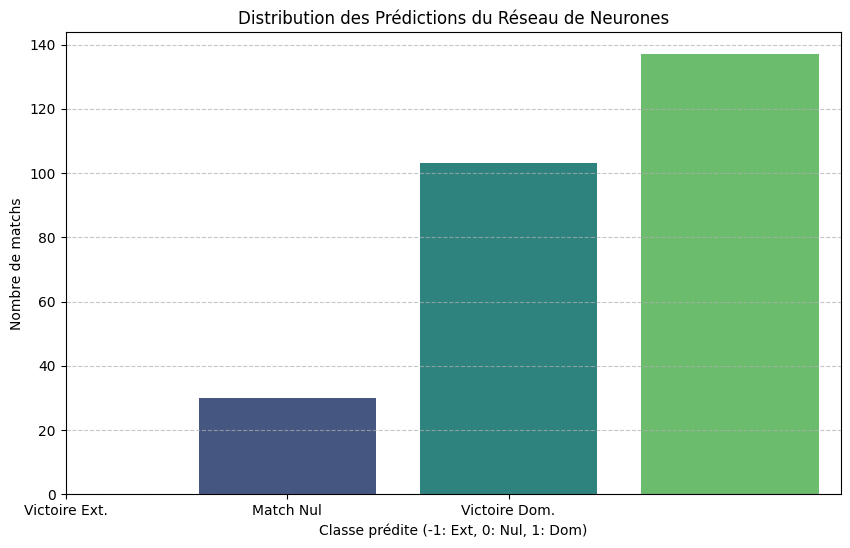

Taux de concordance entre les modèles: 30.74%

Distribution des prédictions:
Réseau de Neurones:
results_nn
 1    50.740741
 0    38.148148
-1    11.111111
Name: proportion, dtype: float64

XGBoost:
results_xgb
 1    52.962963
-1    45.185185
 0     1.851852
Name: proportion, dtype: float64


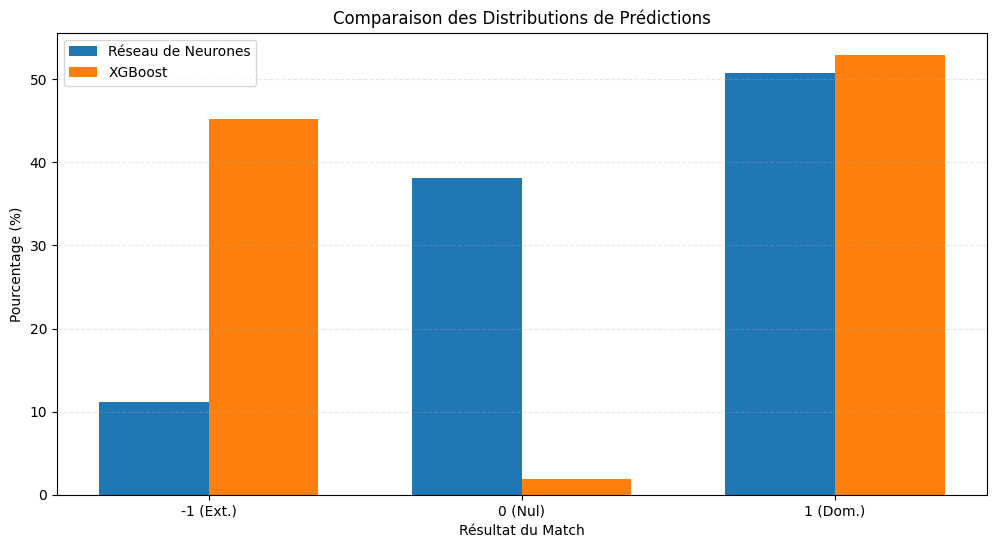

In [6]:

# Charger le modèle et les prédictions
def evaluer_performance_nn(model_path, predictions_path, actual_results_path=None):

    # Charger le modèle
    model = load_model(model_path)

    # Charger les prédictions
    predictions_df = pd.read_csv(predictions_path)

    # Distribution des prédictions
    print("Distribution des prédictions du réseau de neurones:")
    value_counts = predictions_df['results'].value_counts(normalize=True) * 100
    print(value_counts)

    # Visualiser la distribution des prédictions
    plt.figure(figsize=(10, 6))
    sns.countplot(x='results', data=predictions_df, palette='viridis')
    plt.title('Distribution des Prédictions du Réseau de Neurones')
    plt.xlabel('Classe prédite (-1: Ext, 0: Nul, 1: Dom)')
    plt.ylabel('Nombre de matchs')
    plt.xticks([-1, 0, 1], ['Victoire Ext.', 'Match Nul', 'Victoire Dom.'])
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # Si les résultats réels sont disponibles
    if actual_results_path:
        real_results = pd.read_csv(actual_results_path)

        # Fusionner les prédictions avec les résultats réels
        merged_df = predictions_df.merge(real_results, on='game_id', how='inner')

        # Renommer les colonnes pour plus de clarté
        merged_df = merged_df.rename(columns={'results_x': 'pred', 'results_y': 'real'})

        # Calculer les métriques de performance
        accuracy = accuracy_score(merged_df['real'], merged_df['pred'])
        precision = precision_score(merged_df['real'], merged_df['pred'], average='weighted')
        recall = recall_score(merged_df['real'], merged_df['pred'], average='weighted')
        f1 = f1_score(merged_df['real'], merged_df['pred'], average='weighted')

        print("\nMétriques de performance:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")

        # Matrice de confusion
        cm = confusion_matrix(merged_df['real'], merged_df['pred'])

        # Afficher la matrice de confusion
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Victoire Ext.', 'Match Nul', 'Victoire Dom.'],
                   yticklabels=['Victoire Ext.', 'Match Nul', 'Victoire Dom.'])
        plt.xlabel('Prédictions')
        plt.ylabel('Valeurs Réelles')
        plt.title('Matrice de Confusion')
        plt.show()

        # Rapport de classification détaillé
        print("\nRapport de classification:")
        print(classification_report(merged_df['real'], merged_df['pred'],
                                   target_names=['Victoire Ext.', 'Match Nul', 'Victoire Dom.']))

    return model

# Comparer les performances avec XGBoost
def comparer_modeles(nn_predictions_path, xgb_predictions_path, actual_results_path=None):
    """
    Compare les performances du réseau de neurones avec XGBoost

    Parameters:
    ----------
    nn_predictions_path : str
        Chemin vers les prédictions du réseau de neurones
    xgb_predictions_path : str
        Chemin vers les prédictions XGBoost
    actual_results_path : str, optional
        Chemin vers les résultats réels si disponibles
    """
    # Charger les prédictions
    nn_preds = pd.read_csv(nn_predictions_path)
    xgb_preds = pd.read_csv(xgb_predictions_path)

    # Fusionner les prédictions
    comparison_df = nn_preds.merge(xgb_preds, on='game_id', how='inner',
                                 suffixes=('_nn', '_xgb'))

    # Calculer le taux de concordance
    comparison_df['match'] = comparison_df['results_nn'] == comparison_df['results_xgb']
    agreement_rate = comparison_df['match'].mean() * 100

    print(f"Taux de concordance entre les modèles: {agreement_rate:.2f}%")

    # Distribution des prédictions pour chaque modèle
    print("\nDistribution des prédictions:")
    print("Réseau de Neurones:")
    print(comparison_df['results_nn'].value_counts(normalize=True) * 100)
    print("\nXGBoost:")
    print(comparison_df['results_xgb'].value_counts(normalize=True) * 100)

    # Visualiser la comparaison
    plt.figure(figsize=(12, 6))

    # Préparation des données pour le graphique
    labels = ['-1 (Ext.)', '0 (Nul)', '1 (Dom.)']
    nn_values = [
        (comparison_df['results_nn'] == -1).mean() * 100,
        (comparison_df['results_nn'] == 0).mean() * 100,
        (comparison_df['results_nn'] == 1).mean() * 100
    ]
    xgb_values = [
        (comparison_df['results_xgb'] == -1).mean() * 100,
        (comparison_df['results_xgb'] == 0).mean() * 100,
        (comparison_df['results_xgb'] == 1).mean() * 100
    ]

    x = np.arange(len(labels))
    width = 0.35

    plt.bar(x - width/2, nn_values, width, label='Réseau de Neurones')
    plt.bar(x + width/2, xgb_values, width, label='XGBoost')

    plt.xlabel('Résultat du Match')
    plt.ylabel('Pourcentage (%)')
    plt.title('Comparaison des Distributions de Prédictions')
    plt.xticks(x, labels)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.show()

    # Si les résultats réels sont disponibles
    if actual_results_path:
        real_results = pd.read_csv(actual_results_path)

        # Fusionner avec les résultats réels
        eval_df = comparison_df.merge(real_results, on='game_id', how='inner')
        eval_df = eval_df.rename(columns={'results': 'real'})

        # Calculer les métriques pour chaque modèle
        nn_accuracy = accuracy_score(eval_df['real'], eval_df['results_nn'])
        xgb_accuracy = accuracy_score(eval_df['real'], eval_df['results_xgb'])

        nn_f1 = f1_score(eval_df['real'], eval_df['results_nn'], average='weighted')
        xgb_f1 = f1_score(eval_df['real'], eval_df['results_xgb'], average='weighted')

        # Afficher les métriques de performance
        metrics = {
            'Modèle': ['Réseau de Neurones', 'XGBoost'],
            'Accuracy': [nn_accuracy, xgb_accuracy],
            'F1 Score': [nn_f1, xgb_f1]
        }

        metrics_df = pd.DataFrame(metrics)
        print("\nMétriques de performance comparées:")
        print(metrics_df)

        # Visualisation des métriques
        plt.figure(figsize=(10, 6))

        x = np.arange(len(metrics['Modèle']))
        width = 0.35

        plt.bar(x - width/2, metrics['Accuracy'], width, label='Accuracy')
        plt.bar(x + width/2, metrics['F1 Score'], width, label='F1 Score')

        plt.xlabel('Modèle')
        plt.ylabel('Score')
        plt.title('Comparaison des Performances')
        plt.xticks(x, metrics['Modèle'])
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.3)
        plt.show()

# Exemple d'utilisation
if __name__ == "__main__":
    base_path = '/content/drive/MyDrive/ColabModels/Ligue1_Prediction/'

    # Chemins vers les fichiers
    model_path = base_path + 'nn_pca_model.h5'
    nn_predictions_path = base_path + 'predictions_nn_ligue1_2023-2024.csv'
    xgb_predictions_path = base_path + 'predictions_xgb_ligue1_2023-2024.csv'

    # Pour les résultats réels (si disponibles)
    # actual_results_path = base_path + 'actual_results_2023-2024.csv'
    actual_results_path = None  # Mettre à None si pas disponible

    # Évaluer les performances du réseau de neurones
    model = evaluer_performance_nn(model_path, nn_predictions_path, actual_results_path)

    # Comparer avec XGBoost
    comparer_modeles(nn_predictions_path, xgb_predictions_path, actual_results_path)

Distribution des prédictions du réseau de neurones:
results
 1    50.740741
 0    38.148148
-1    11.111111
Name: proportion, dtype: float64


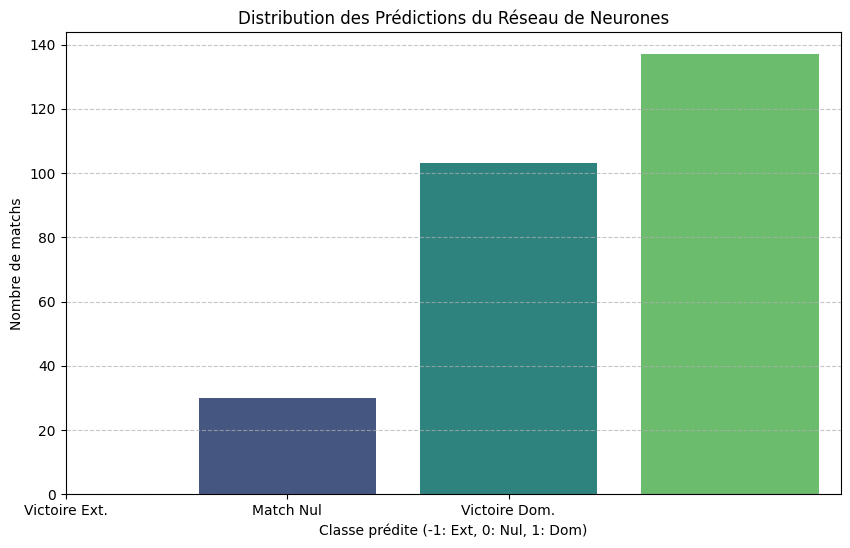

In [7]:
    model = evaluer_performance_nn(model_path, nn_predictions_path, actual_results_path)
